<a href="https://colab.research.google.com/github/arpanbiswas52/MOBO_Unconstrained/blob/main/MOBOtutorial(BoTorch_Unconstrained)v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Unconstrained Multi-Objective Bayesian Optimization (MOBO) tutorials 

MOBO tutorial framework developed by **Arpan Biswas**

**Physics Based Numerical Model Examples**

FerroSim Model -- developed by **Rama Vasudevan**


In [1]:
!pip install botorch
!pip install gpytorch
!pip install pymoo
!pip install atomai

     |████████████████████████████████| 475 kB 8.2 MB/s 
     |████████████████████████████████| 498 kB 59.9 MB/s 
     |████████████████████████████████| 3.7 MB 8.8 MB/s 
     |████████████████████████████████| 239 kB 54.7 MB/s 
  Created wheel for pymoo: filename=pymoo-0.4.2.2-cp37-cp37m-linux_x86_64.whl size=4940007 sha256=bf383cd9661970e1f860afe89980ace4fa8426d8b05cd902a588e18df5e9b11d
  Stored in directory: /root/.cache/pip/wheels/ab/8c/89/c450ad360fc24cb70fec0388e8d95b51021eae5dab248ab76e
Successfully built pymoo
     |████████████████████████████████| 143 kB 7.9 MB/s 
     |████████████████████████████████| 193 kB 60.8 MB/s 
     |████████████████████████████████| 865 kB 60.6 MB/s 
  Created wheel for mendeleev: filename=mendeleev-0.6.1-py2.py3-none-any.whl size=174981 sha256=111c80147136815a243d21a7865376746a122bace8529a1014185057be244526
  Stored in directory: /root/.cache/pip/wheels/f4/4e/dd/06777c90710ce1766376ecc87979967fe69ff3affc29c0b530
Successfully built mendeleev


In [2]:
import torch as to
import numpy as np
import gpytorch as gpt
import matplotlib.pyplot as plt
import random
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import sympy as sym
import pymoo
import atomai as aoi

from botorch.models import SingleTaskGP, ModelListGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.utils import standardize
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.sampling import IIDNormalSampler
from gpytorch.likelihoods.likelihood import Likelihood
from gpytorch.constraints import GreaterThan
from numpy import linalg as LA
from scipy import optimize
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from botorch.generation import get_best_candidates, gen_candidates_torch
from botorch.optim import gen_batch_initial_conditions
from gpytorch.models import ExactGP
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch.optim import SGD
from torch.optim import Adam
from scipy.stats import norm
from botorch.utils.transforms import unnormalize
from botorch.utils.sampling import draw_sobol_samples
from botorch.optim.optimize import optimize_acqf, optimize_acqf_list
from botorch.acquisition.objective import GenericMCObjective
from botorch.utils.multi_objective.scalarization import get_chebyshev_scalarization
from botorch.utils.multi_objective.box_decompositions.non_dominated import NondominatedPartitioning
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.utils.sampling import sample_simplex
from botorch import fit_gpytorch_model
from botorch.acquisition.monte_carlo import qExpectedImprovement, qNoisyExpectedImprovement
from botorch.sampling.samplers import SobolQMCNormalSampler
from botorch.exceptions import BadInitialCandidatesWarning
from botorch.utils.multi_objective.pareto import is_non_dominated
from botorch.utils.multi_objective.hypervolume import Hypervolume
from matplotlib.cm import ScalarMappable

#matplotlib inline

import time
import warnings

<h1> GP and multi-objective acquistion functions

In [3]:
class SimpleCustomGP(ExactGP, GPyTorchModel):
    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y):
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


########## MOBO acquisition function ###########################
# q-Expected Improvement acquistion function ###########
def optimize_qehvi(model, train_X, train_obj, rf, BATCH_SIZE):
    """Optimizes the qEHVI acquisition function, and returns a new candidate and observation."""
    # partition non-dominated space into disjoint rectangles
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    partitioning = NondominatedPartitioning(ref_point=rf, Y=train_obj)
    acq_func = qExpectedHypervolumeImprovement(
        model=model,
        ref_point=rf.tolist(),  # use known reference point
        partitioning=partitioning,
        sampler=sampler,
    )
    # optimize
    new_x, value = optimize_acqf(
        acq_function=acq_func,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        q=BATCH_SIZE,
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200, "nonnegative": True},
        sequential=True,
    )


    return new_x, value

# q-PAREGO acquistion function ###########
def optimize_qparego(model, train_X, train_obj, BATCH_SIZE):
    """Samples a set of random weights for each candidate in the batch, performs sequential greedy optimization
    of the qParEGO acquisition function, and returns a new candidate and observation."""
    sampler = SobolQMCNormalSampler(num_samples=500, seed=0, resample=False)
    #BATCH_SIZE = 4
    acq_func_list = []
    for _ in range(BATCH_SIZE):
        n_obj = train_obj.dim()
        weights = sample_simplex(n_obj, **tkwargs).squeeze()
        objective = GenericMCObjective(get_chebyshev_scalarization(weights=weights, Y=train_obj))
        acq_func = qExpectedImprovement(  # pyre-ignore: [28]
            model=model,
            objective=objective,
            best_f=objective(train_obj).max(),
            sampler=sampler,
        )
        acq_func_list.append(acq_func)
    # optimize
    new_x, value = optimize_acqf_list(
        acq_function_list=acq_func_list,
        bounds=to.tensor([[0.0] * 2, [1.0] * 2]),
        num_restarts=20,
        raw_samples=1000,  # used for intialization heuristic
        options={"batch_limit": 5, "maxiter": 200},
    )


    return new_x, value


<h1> Optimize and train GP, calculate Posterior distribution

In [4]:
def optimize_hyperparam_trainGP(train_X_norm, train_Y_norm):
    # Gp model fit

    gp_surro1 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 0])
    gp_surro2 = SimpleCustomGP(train_X_norm, train_Y_norm[:, 1])
    gp_surro = ModelListGP(gp_surro1, gp_surro2)
    gp_surro = gp_surro.double()
    gp_surro.likelihood.likelihoods[0].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    gp_surro.likelihood.likelihoods[1].noise_covar.register_constraint("raw_noise", GreaterThan(1e-1))
    mll1 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[0], gp_surro.models[0])
    mll2 = ExactMarginalLogLikelihood(gp_surro.likelihood.likelihoods[1], gp_surro.models[1])
    # fit_gpytorch_model(mll)
    mll1 = mll1.to(train_X_norm)
    mll2 = mll2.to(train_X_norm)
    gp_surro.models[0].train()
    gp_surro.likelihood.likelihoods[0].train()
    gp_surro.models[1].train()
    gp_surro.likelihood.likelihoods[1].train()

    optimizer1 = Adam([{'params': gp_surro.models[0].parameters()}], lr=0.2)
    optimizer2 = Adam([{'params': gp_surro.models[1].parameters()}], lr=0.2)

    NUM_EPOCHS = 150

    for epoch in range(NUM_EPOCHS):
        # clear gradients
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        # forward pass through the model to obtain the output MultivariateNormal
        output1 = gp_surro.models[0](train_X_norm)
        output2 = gp_surro.models[1](train_X_norm)
        # Compute negative marginal log likelihood
        loss1 = - mll1(output1, gp_surro.models[0].train_targets)
        loss2 = - mll2(output2, gp_surro.models[1].train_targets)
        # back prop gradients
        loss1.backward(retain_graph=True)
        # back prop gradients
        loss2.backward(retain_graph=True)
        # print last iterations
        if (epoch + 1) > NUM_EPOCHS: #Stopping the print for now
            print("GP Model trained:")
            print("Iteration:" + str(epoch + 1))
            print("Loss for ob1:" + str(loss1.item()))
            print("Loss for ob2:" + str(loss2.item()))
            # print("Length Scale:" +str(gp_PZO.covar_module.base_kernel.lengthscale.item()))
            print("noise for obj1:" + str(gp_surro.likelihood.likelihoods[0].noise.item()))
            print("noise for obj2:" + str(gp_surro.likelihood.likelihoods[1].noise.item()))

        optimizer1.step()
        optimizer2.step()

    gp_surro.models[0].eval()
    gp_surro.likelihood.likelihoods[0].eval()
    gp_surro.models[1].eval()
    gp_surro.likelihood.likelihoods[1].eval()
    return gp_surro

#GP posterior prediction
def cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows):
    y_pred_means = to.empty(num_rows, num_rows, 2)
    y_pred_vars = to.empty(num_rows, num_rows, 2)
    for t1, (x1, x2, y1, y2) in enumerate(zip(testX1_norm, testX2_norm, t_y[:, :, 0], t_y[:, :, 1])):
        for t2, (xx1, xx2, yy1, yy2) in enumerate(zip(x1, x2, y1, y2)):

            if (xx1 == -1 and xx2 == -1):
                y_pred_means[t1, t2, 0] = yy1
                y_pred_vars[t1, t2, 0] = 1e-8
                y_pred_means[t1, t2, 1] = yy2
                y_pred_vars[t1, t2, 1] = 1e-8
            else:
                test_X = to.empty(1, 2)
                test_X[:, 0] = xx1
                test_X[:, 1] = xx2
                test_X = test_X.double()
                with to.no_grad(), gpt.settings.max_lanczos_quadrature_iterations(32), \
                     gpt.settings.fast_computations(covar_root_decomposition=False, log_prob=False,
                                                    solves=True), \
                     gpt.settings.max_cg_iterations(100), \
                     gpt.settings.max_preconditioner_size(80), \
                     gpt.settings.num_trace_samples(128):
                    y1_pred_surro, y2_pred_surro = gp_surro.models[0].posterior(test_X), gp_surro.models[1].posterior(test_X)
                    y_pred_means[t1, t2, 0] = y1_pred_surro.mean
                    y_pred_vars[t1, t2, 0] = y1_pred_surro.variance
                    y_pred_means[t1, t2, 1] = y2_pred_surro.mean
                    y_pred_vars[t1, t2, 1] = y2_pred_surro.variance

    return y_pred_means, y_pred_vars

Plots for Predicted Phase diagrams and Pareto Solutions

In [5]:
def plot_exploration_results(X1, X2, Gp_y_mu, Gp_y_var, train_X, train_Y, iter, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]

    _, ax = plt.subplots(3, 2, figsize=(12, 15))
    ax[0, 0].imshow(X1, origin='bottom', cmap='gist_stern')
    ax[0, 1].imshow(X2, origin='bottom', cmap='gist_stern')
    ax[1, 0].imshow(Gp_y_mu[:, :, 0].detach().numpy(), origin='bottom', cmap='gist_stern')
    ax[1, 1].imshow(Gp_y_var[:, :, 0].detach().numpy(), origin='bottom', cmap='gist_stern')
    ax[2, 0].imshow(Gp_y_mu[:, :, 1].detach().numpy(), origin='bottom', cmap='gist_stern')
    ax[2, 1].imshow(Gp_y_var[:, :, 1].detach().numpy(), origin='bottom', cmap='gist_stern')
    ax[0, 0].set_title(str(param1))
    ax[0, 1].set_title(str(param2))
    ax[1, 0].set_title(str(obj1)+" (GP), iter=" + str(iter))
    ax[1, 1].set_title("Uncertainty, iter=" + str(iter))
    ax[2, 0].set_title(str(obj2)+" (GP), iter=" + str(iter))
    ax[2, 1].set_title("Uncertainty, iter=" + str(iter))
    plt.show()
    # plt.colorbar()

    #train_X = train_X.detach().numpy()
    #train_Y = train_Y.detach().numpy()
    fig1, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    ax[0].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,0], cmap='viridis', linewidth=0.2)
    ax[0].set_xlabel(str(param1))
    ax[0].set_ylabel(str(param2))
    ax[0].set_title(str(obj1)+" (cmap), iter=" + str(iter))
    ax[1].scatter(train_X[:, 0], train_X[:, 1], c=train_Y[:,1], cmap='viridis', linewidth=0.2)
    ax[1].set_xlabel(str(param1))
    #ax[1].set_ylabel(str(param2))
    ax[1].set_title(str(obj2)+" (cmap), iter=" + str(iter))
    plt.show()

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 0] = -Gp_y_mu[:, :, 0]
        train_Y[:,0] = -train_Y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        Gp_y_mu[:, :, 1] = -Gp_y_mu[:, :, 1]
        train_Y[:,1] = -train_Y[:,1]
    

def plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, n_initial, N_BO, BATCH_SIZE, param1, param2, obj1, obj2, problem):
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]
    batch_number = to.cat([to.zeros(n_initial), to.arange(1, N_BO + 1).repeat(BATCH_SIZE, 1).t().reshape(-1)]).numpy()
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_Y_norm[:, 0], train_Y_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(obj1))
    axes[0,0].set_ylabel(str(obj2))
    axes[0,0].set_title('Samples over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_Y[:, 0], train_Y[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(obj1))
    #axes[0,1].set_ylabel(str(obj2))
    axes[0,1].set_title('Samples over (real)objective space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_y_norm[:, 0], pareto_y_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(obj1))
    axes[1,0].set_ylabel(str(obj2))
    axes[1,0].set_title('Pareto frontier over (normalized)objective space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_y[:, 0], pareto_y[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(obj1))
    #axes[1,1].set_ylabel(str(obj2))
    axes[1,1].set_title('Pareto frontier over (real)objective space, iter=' + str(N_BO + 1))


    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes[0,0].scatter(train_X_norm[:, 0], train_X_norm[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,0].set_xlabel(str(param1))
    axes[0,0].set_ylabel(str(param2))
    axes[0,0].set_title('Samples over over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[0,1].scatter(train_X[:, 0], train_X[:, 1], c= batch_number, cmap='viridis',linewidth=0.2)
    axes[0,1].set_xlabel(str(param1))
    #axes[0,1].set_ylabel(str(param2))
    axes[0,1].set_title('Samples over over (real)parameter space, iter=' + str(N_BO + 1))
    axes[1,0].scatter(pareto_x_norm[:, 0], pareto_x_norm[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,0].set_xlabel(str(param1))
    axes[1,0].set_ylabel(str(param2))
    axes[1,0].set_title('Pareto frontier over (normalized)parameter space, iter=' + str(N_BO + 1))
    axes[1,1].scatter(pareto_x[:, 0], pareto_x[:, 1], c= pareto_y_norm[:, 0], cmap='gist_rainbow',linewidth=0.2)
    axes[1,1].set_xlabel(str(param1))
    #axes[1,1].set_ylabel(str(param2))
    axes[1,1].set_title('Pareto frontier over (real)parameter space, iter=' + str(N_BO + 1))

    #Retransforming for the optimization problem
    if (problem[0]=='min'): #Transform to original function value
        train_Y[:,0] = -train_Y[:,0]
        train_Y_norm[:,0] = -train_Y_norm[:,0]
        pareto_y[:,0] = -pareto_y[:,0]
        pareto_y_norm[:,0] = -pareto_y_norm[:,0]
    if (problem[1]=='min'): #Transform to original function value
        train_Y[:,1] = -train_Y[:,1]
        train_Y_norm[:, 1] = -train_Y_norm[:, 1]
        pareto_y[:,1] = -pareto_y[:,1]
        pareto_y_norm[:,1] = -pareto_y_norm[:,1]

    plt.show()

<h1> MOBO framework (2D case - 2 objectives)

Test problems- ZDT1, Six hump Camel back- Inversed Ackley's Path function

In [20]:
##Toy model 1## - ZDT1

def ZDT1(x1, x2):
    f1 = x1
    g = 1 + 9*x2
    f2 = 1- np.sqrt(f1/g)
    return f1, f2

##Toy model 2## - 6-hump Camel back- Inversed Ackley's path
def Sixhump_Camelback_inverse_Ackley(x1, x2):
    a = 20
    b = 0.2
    c = 2*np.pi
    f1 = (4 - 2.1*x1**2 +(x1**4)/3)*x1**2 + x1*x2 + (-4 + 4*x2**2)*x2**2
    f2 = a*np.exp(-b*np.sqrt((x1**2 + x2**2)/2)) + np.exp((np.cos(c*x1) + np.cos(c*x2))/2) -a -np.exp(1)
    return f1, f2


def normalize_get_initialdata_testfunc(X1, X2, test_X1, test_X2, num_rows, num, problem, testfunction, m):
    # Normalize X
    minX1 = min(X1)
    maxX1 = max(X1)
    minX2 = min(X2)
    maxX2 = max(X2)
    Xmin = np.hstack((minX1, minX2))
    Xmax = np.hstack((maxX1, maxX2))
    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)
    X1_norm = (X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    X2_norm = (X2 - Xmin[1]) / (Xmax[1] - Xmin[1])
    testX1_norm = (test_X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    testX2_norm = (test_X2 - Xmin[1]) / (Xmax[1] - Xmin[1])

    # Select starting samples randomly as training data
    testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
    testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
    test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
    test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
    np.random.seed(10)
    ind_start = np.random.choice(len(testX1_norm) - 1, size=num, replace=False)
    train_X = np.zeros((num, 2))
    train_X_norm = np.zeros((num, 2))
    train_y = np.zeros((num, 2))
    t_y = np.zeros((num_rows ** 2, 2))
    m = 0
    print("Function evaluaton for initial randomly selected samples")
    for i in range(0, num):
        train_X_norm[i, 0] = testX1_norm[ind_start[i]]
        train_X_norm[i, 1] = testX2_norm[ind_start[i]]
        train_X[i, 0] = test_X1[ind_start[i]]
        train_X[i, 1] = test_X2[ind_start[i]]
        print("Function eval #" + str(m + 1))
        if (testfunction == 'ZDT1'):
            f1, f2 = ZDT1(train_X[i, 0], train_X[i, 1])
        elif (testfunction == '6HC-IAP'):
            f1, f2 = Sixhump_Camelback_inverse_Ackley(train_X[i, 0], train_X[i, 1])
        else:
            print("Invalid test functions")

        if (problem[0] == 'min'):
            train_y[i, 0] = -f1  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 0] = -f1  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 0] = f1
            t_y[ind_start[i], 0] = f1

        if (problem[1] == 'min'):
            train_y[i, 1] = -f2  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 1] = -f2  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 1] = f2
            t_y[ind_start[i], 1] = f2

        # testX1_norm[ind_start[i]] =-1
        # testX2_norm[ind_start[i]] =-1
        m = m + 1

    testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
    testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))
    t_y = np.reshape(t_y, (num_rows, num_rows, 2))

    # Convert to torch
    train_X_norm = to.from_numpy(train_X_norm)
    train_X_norm = train_X_norm.double()
    train_Y = to.from_numpy(train_y)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm

    return X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m

def augment_newdata_testfunc(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, testfunction, m):
    nextX_norm = acq_X
    nextX = nextX_norm * (to.from_numpy(Xmax) - to.from_numpy(Xmin)) + to.from_numpy(Xmin)
    nextX = nextX.detach().numpy()
    train_X_norm = to.cat((train_X_norm, nextX_norm), 0)
    train_X_norm = train_X_norm.double()
    train_X = np.vstack((train_X, nextX))
    next_feval = to.empty(BATCH_SIZE, 2)
    print("Batch Function eval #" + str(m + 1))

    for j in range(0, BATCH_SIZE):
        # Function evaluation for new data
        print("Within batch: Function eval: " + str(j + 1) + " of " + str(BATCH_SIZE))
        if (testfunction == 'ZDT1'):
            f1, f2 = ZDT1(nextX[j, 0], nextX[j, 1])
        elif (testfunction == '6HC-IAP'):
            f1, f2 = Sixhump_Camelback_inverse_Ackley(nextX[j, 0], nextX[j, 1])
        else:
            print("Invalid test function")

        if (problem[0] == 'min'):
            next_feval[j, 0] = -f1
        else:
            next_feval[j, 0] = f1
        if (problem[1] == 'min'):
            next_feval[j, 1] = -f2
        else:
            next_feval[j, 1] = f2

    train_Y = to.cat((train_Y, next_feval), 0)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm
    m = m + 1
    return train_X, train_X_norm, train_Y, train_Y_norm, m

In [21]:
def MOBO_testfunc(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, testfunction):
        ##MOBO framework#######
    m=0
    X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m=\
        normalize_get_initialdata_testfunc(X1, X2, test_X1, test_X2, num_rows, num, problem, testfunction, m)

    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)

    print("Initial evaluation complete. Start BO- acq func: " +str(acquisition))
    # Gp model fit
    gp_surro= optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    # compute pareto front
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_x = train_X[pareto_mask]
    pareto_y = train_Y[pareto_mask]
    # compute hypervolume
    hvs = []
    rf= to.tensor([0.0] * 2)-0.001
    hv = Hypervolume(ref_point=rf)
    volume = hv.compute(pareto_y_norm)
    hvs.append(volume)


    for i in range(1, N + 1):

        if (i == 1 or i == 10 or i == 20 or i == 30 or i == 40 or i == 90 or i == 140 or i == 190 or i == 240):
            #Calculate posterior for analysis for intermidiate iterations
            y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
            plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
            plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i-1, BATCH_SIZE, param1, param2, obj1, obj2, problem)

        # List of acquisition functions as per user choice- functions from BOtorch packages
        if (acquisition == 'qEHVI'):

            acq_X, acq_val = optimize_qehvi(gp_surro, train_X_norm, train_Y_norm, rf, BATCH_SIZE)
            val = to.mean(acq_val)

        elif (acquisition == 'qParEGO'):

            acq_X, acq_val = optimize_qparego(gp_surro, train_X_norm, train_Y_norm, BATCH_SIZE)
            val = to.mean(acq_val)

    ################################################################
        ## Find next point which maximizes the learning through exploration
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, train_Y_norm, m = augment_newdata_testfunc(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, testfunction, m)

            #Update Pareto front, compute hypervolume
            # compute pareto front
            pareto_mask_norm = is_non_dominated(train_Y_norm)
            pareto_y_norm = train_Y_norm[pareto_mask_norm]
            pareto_x_norm = train_X_norm[pareto_mask_norm]
            pareto_mask = is_non_dominated(train_Y)
            pareto_x = train_X[pareto_mask]
            pareto_y = train_Y[pareto_mask]
            # compute hypervolume
            volume = hv.compute(pareto_y_norm)
            hvs.append(volume)

            # Updating GP model, conditioning on new data
            # Gp model fit
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)


    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
    plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)


    # Plotting pareto frontier #

    # compute pareto front
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_x = train_X[pareto_mask]
    pareto_y = train_Y[pareto_mask]
    if (i == N):
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, N, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    else:
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i-1, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    # plot hypervolume
    #volume = hv.compute(pareto_y_norm)
    #hvs.append(volume)
    plt.plot(hvs)
    plt.ylabel("Hypervolume")
    plt.show()

    print(val_ini)
    print(val)

    #Compare with Pareto solutions using NGSA2 (this is only for test purpose- not a part of MOBO framework)
    print("Run NSGA 2 for test function-- Without MOBO")
    from pymoo.algorithms.nsga2 import NSGA2
    from pymoo.model.problem import Problem
    from pymoo.optimize import minimize
    from pymoo.visualization.scatter import Scatter


    if (testfunction == 'ZDT1'):
        class MyProblem(Problem):

            def __init__(self):
                super().__init__(n_var=2,
                                n_obj=2,
                                n_constr=0,
                                xl=np.array([0, 0]),
                                xu=np.array([1, 1]),
                                elementwise_evaluation=True)

            def _evaluate(self, x, out, *args, **kwargs):

                x1 = x[0]
                x2 = x[1]

                # ZDT1
                f1 = x1
                g = 1 + 9 * x2
                f2 = 1 - np.sqrt(f1 / g)

                #Transform to minimization problem
                f1 = -f1
                f2 = -f2
                out["F"] = [f1, f2]
                #out["G"] = [g1, g2]
    elif (testfunction == '6HC-IAP'):

        class MyProblem(Problem):

            def __init__(self):
                super().__init__(n_var=2,
                                n_obj=2,
                                n_constr=0,
                                xl=np.array([-3, -2]),
                                xu=np.array([3, 2]),
                                elementwise_evaluation=True)

            def _evaluate(self, x, out, *args, **kwargs):

                x1 = x[0]
                x2 = x[1]

                #6-hump Camel back- Inversed Ackley's path
                a = 20
                b = 0.2
                c = 2 * np.pi
                f1 = (4 - 2.1 * x1 ** 2 + (x1 ** 4) / 3) * x1 ** 2 + x1 * x2 + (-4 + 4 * x2 ** 2) * x2 ** 2
                f2 = a * np.exp(-b * np.sqrt((x1 ** 2 + x2 ** 2) / 2)) + np.exp((np.cos(c * x1) + np.cos(c * x2)) / 2) - a - np.exp(1)
                #Transform to minimization problem
                f1 = -f1
                f2 = -f2

                out["F"] = [f1, f2]
                #out["G"] = [g1, g2]

    problem = MyProblem()

    algorithm = NSGA2(pop_size=100)

    res = minimize(problem,
                  algorithm,
                  ("n_gen", 100),
                  verbose=True,
                  seed=1,
                  save_history=True)


    #plot = Scatter()
    #Transforming to true values for maximization problem
    res.F = -res.F
    #plot.add(res.F, color='red', label = 'NSGA2')
    #plot.add(pareto_y[:, 0], pareto_y[:, 1], color='green', label = str(acquisition))

    plt.scatter(res.F[:, 0], res.F[:, 1], color='red', label = 'NSGA2')
    plt.scatter(pareto_y[:, 0], pareto_y[:, 1], color='green', label = str(acquisition))

    plt.xlabel("f1")
    plt.ylabel("f2")
   
    plt.legend(loc="best")
    plt.show()


<h1>User Inputs

**Provide BATCH_SIZE #** (default = 4)

**We include 2 acquistion functions-**
1. qEHVI 
2. qParEGO

**We have two test multi-objective functions**
1. 'ZDT1'
2. '6HC-IAP'- Six hump Camel back - Inversed Ackley's path

**We can switch the optimization problem for objective 1 and 2 individually-**
1. Maximization problem (Default setting in BO)
2. Minimization problem

Example: problem =['min','max'] means obj 1 and 2 will be minimized and maximized respectively

**Other user inputs-**
1. num_rows (define the image map density (num_rows X num_rows), default = 20)
2. num (# of starting samples, default = 20)
3. N (maximum BO iteration, default =45)

<h1> Analysis 1a

Test function- **ZDT1**, acquistion function - **qParEGO**, num_rows =50, num = 10, N= 50

Maximize f1, f2

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Initial evaluation complete. Start BO- acq func: qParEGO


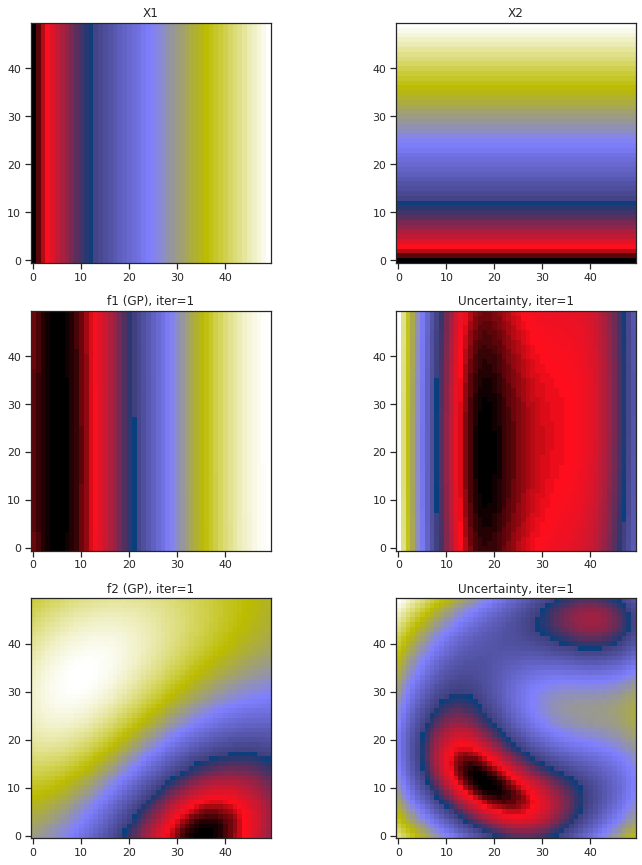

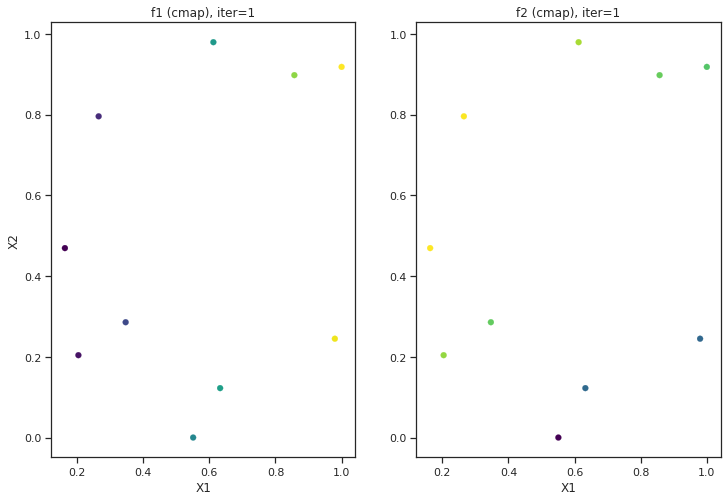

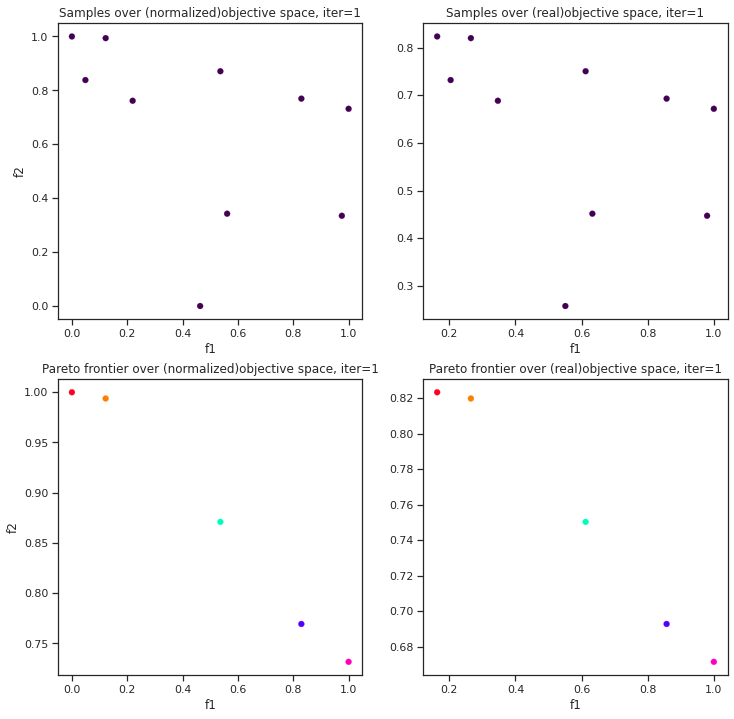

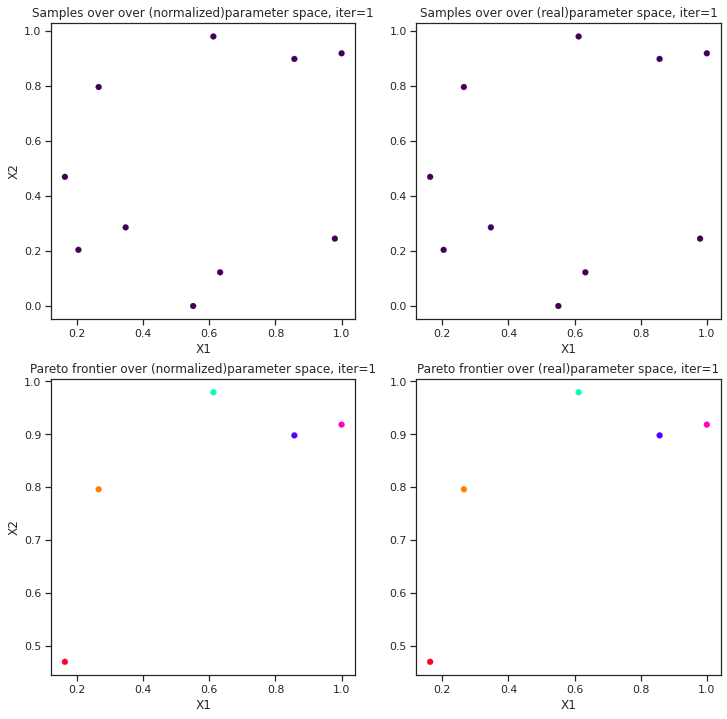

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #11
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #12
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #13
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #14
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #15
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #16
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #17
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #18
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #19
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


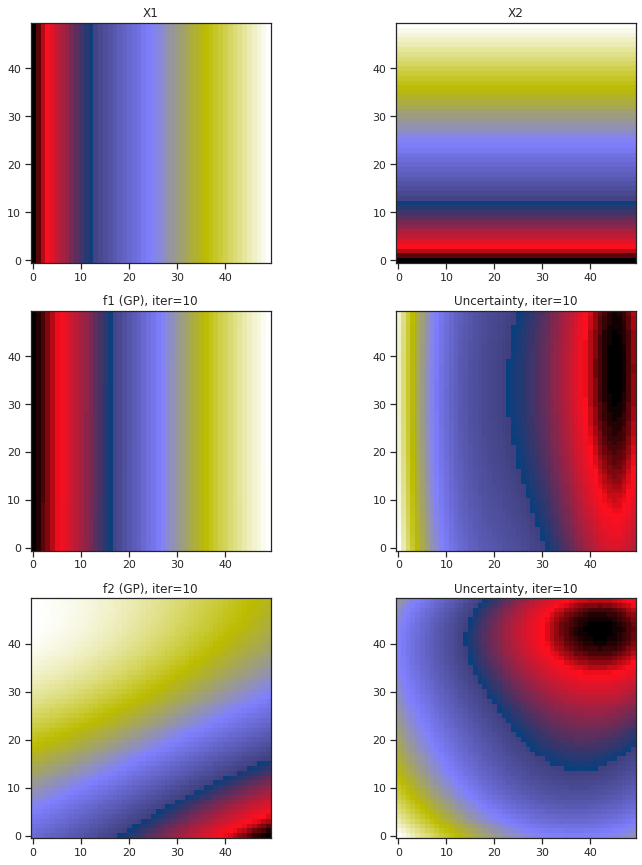

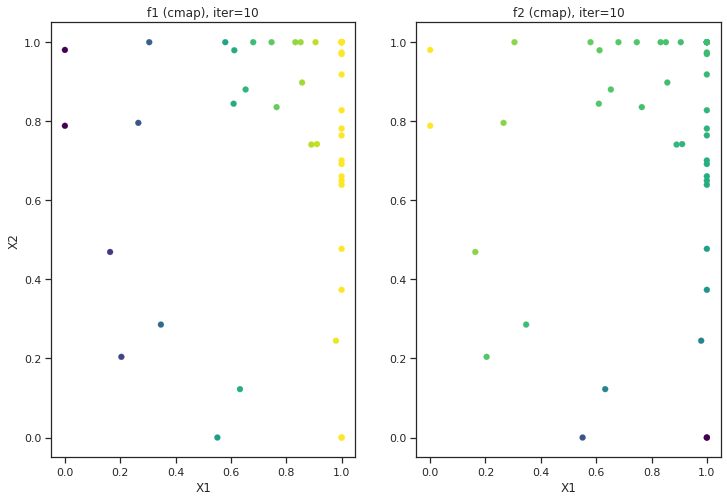

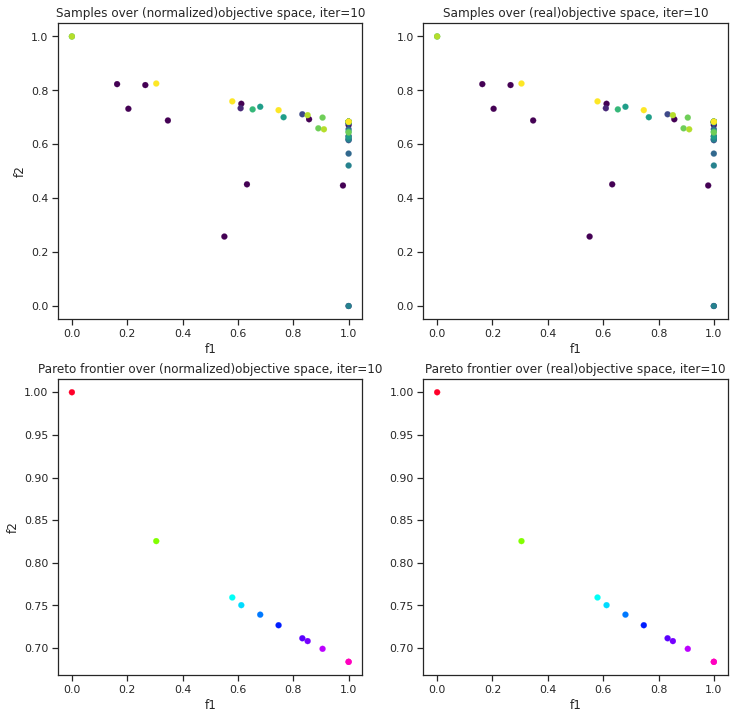

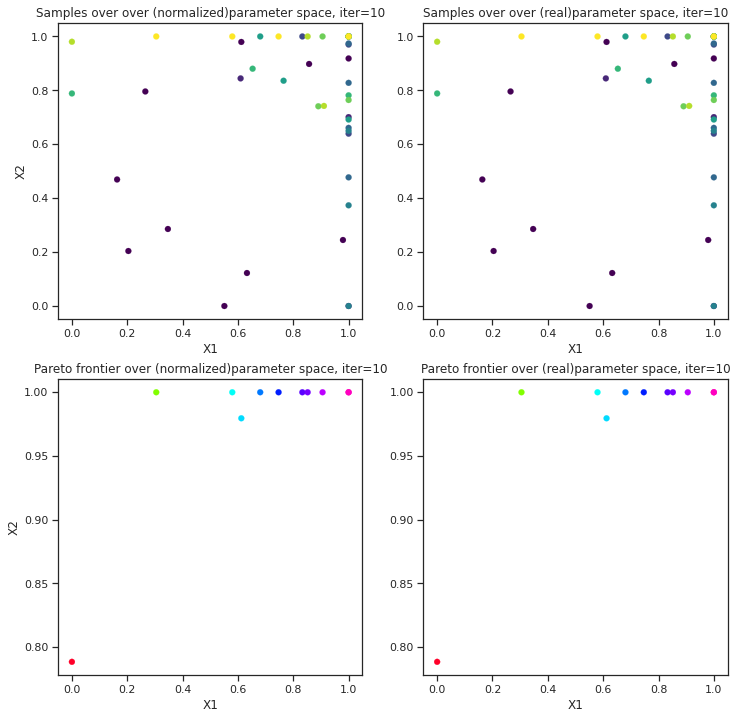

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #20
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


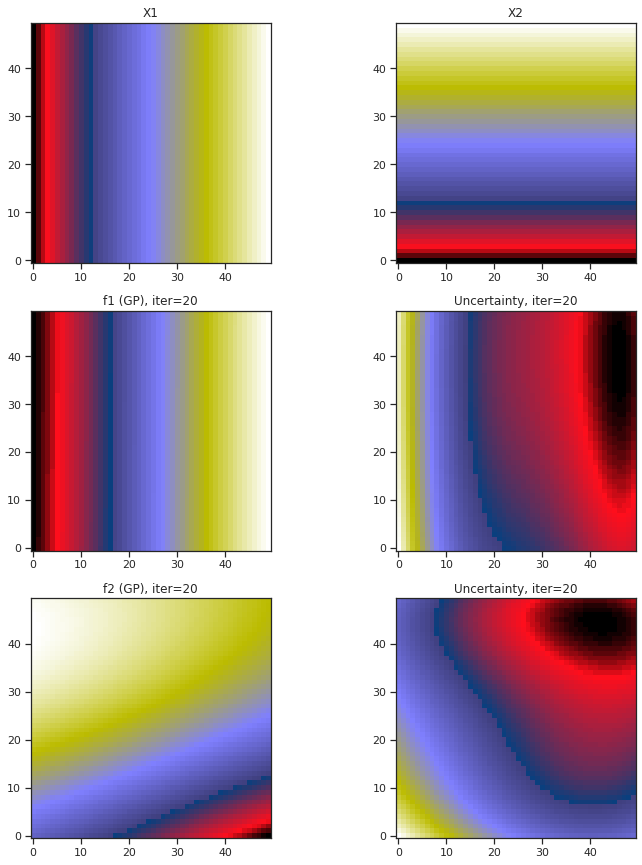

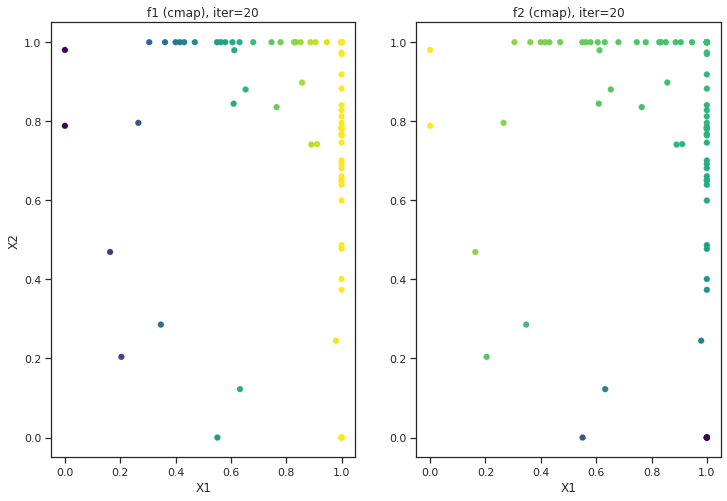

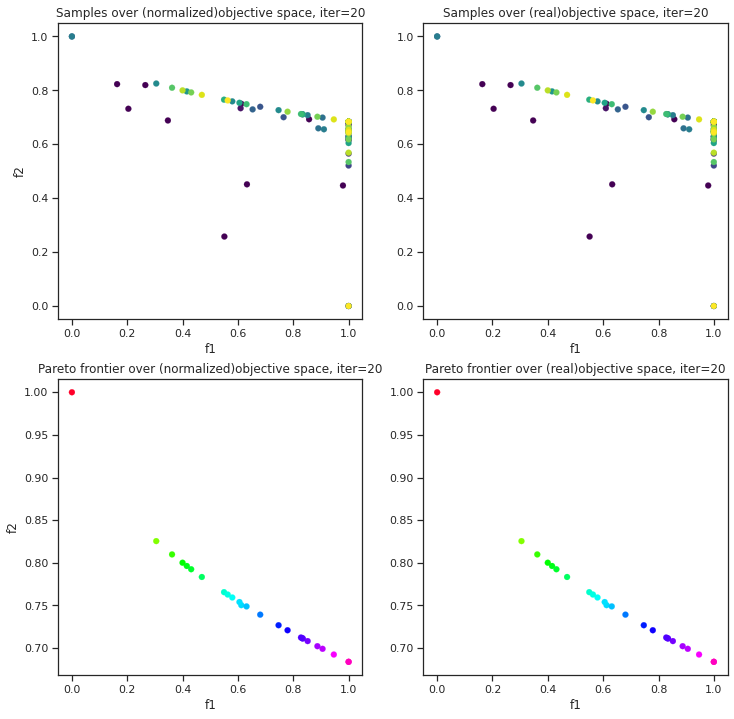

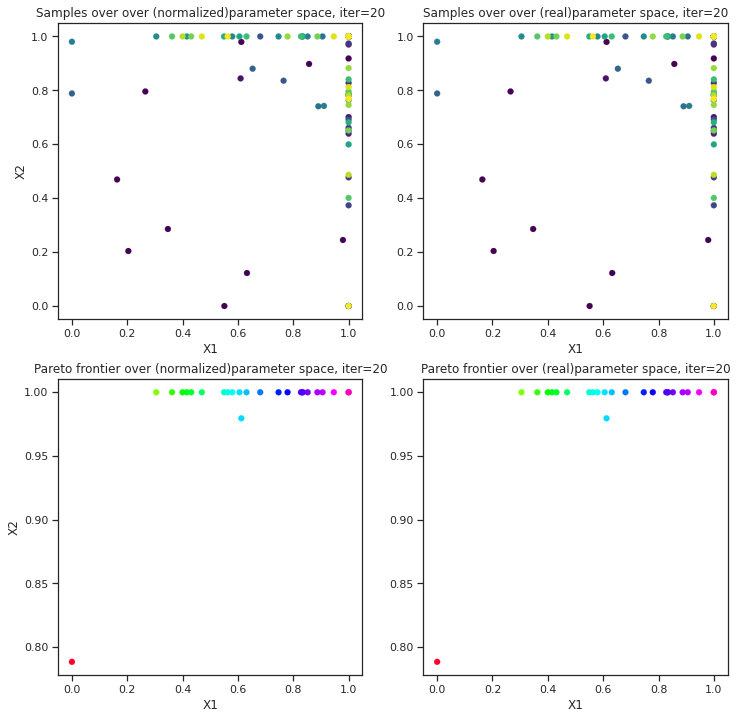

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


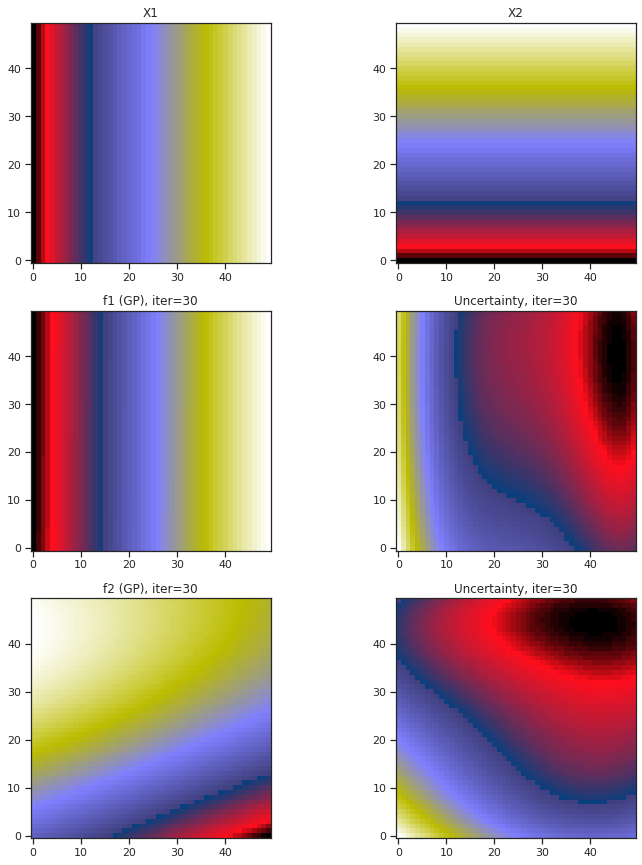

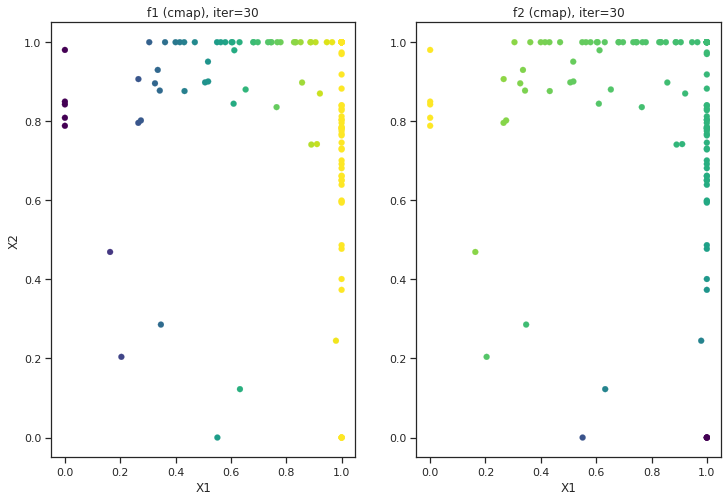

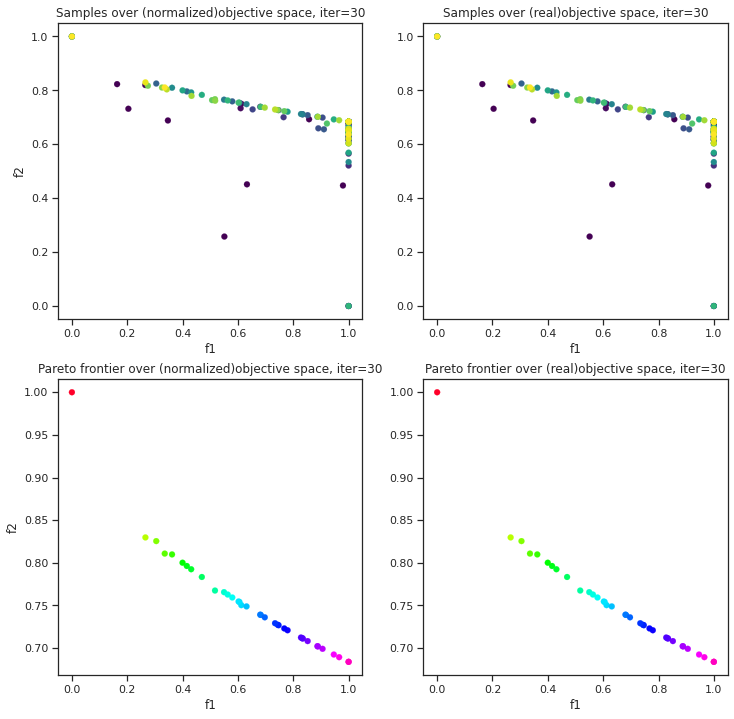

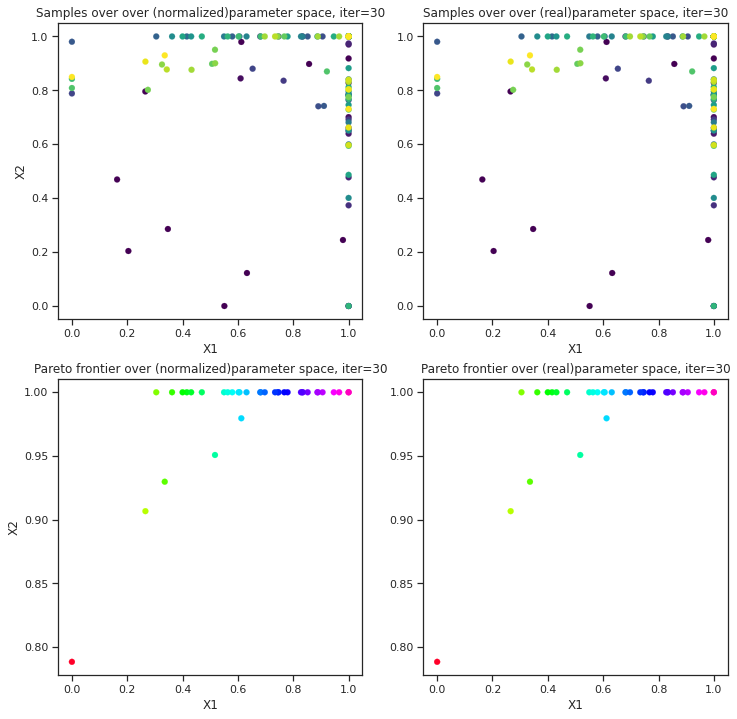

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


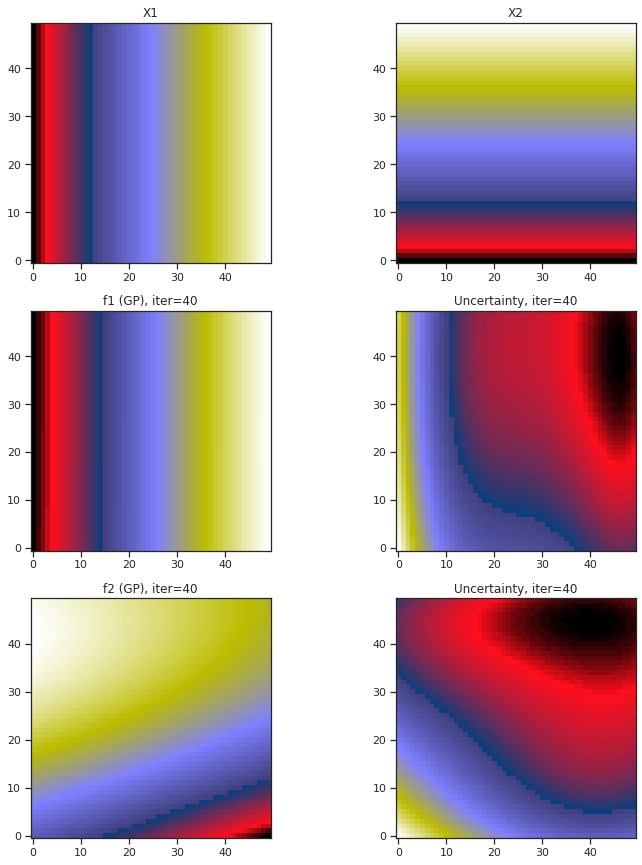

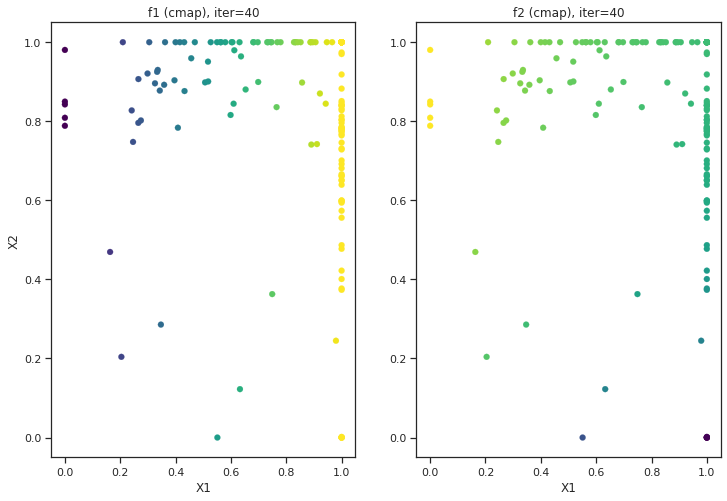

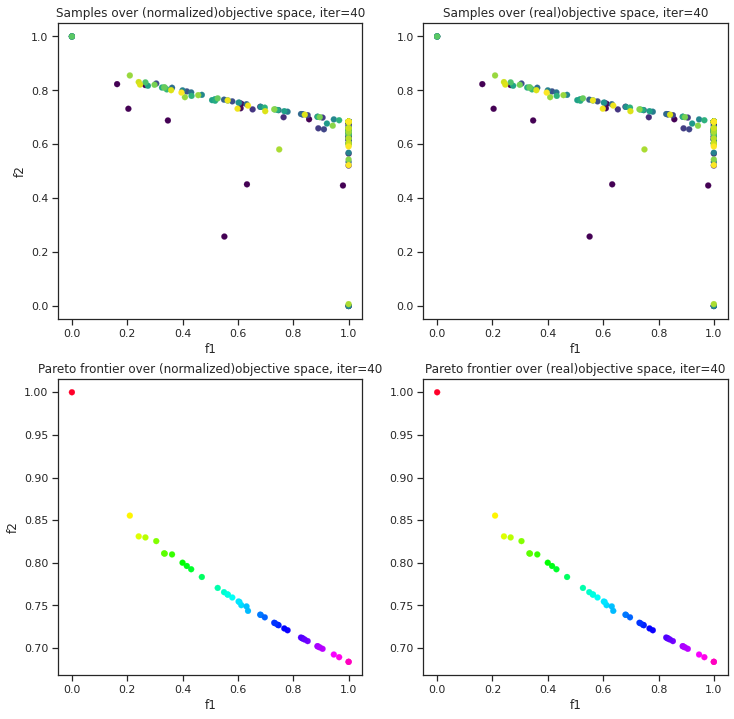

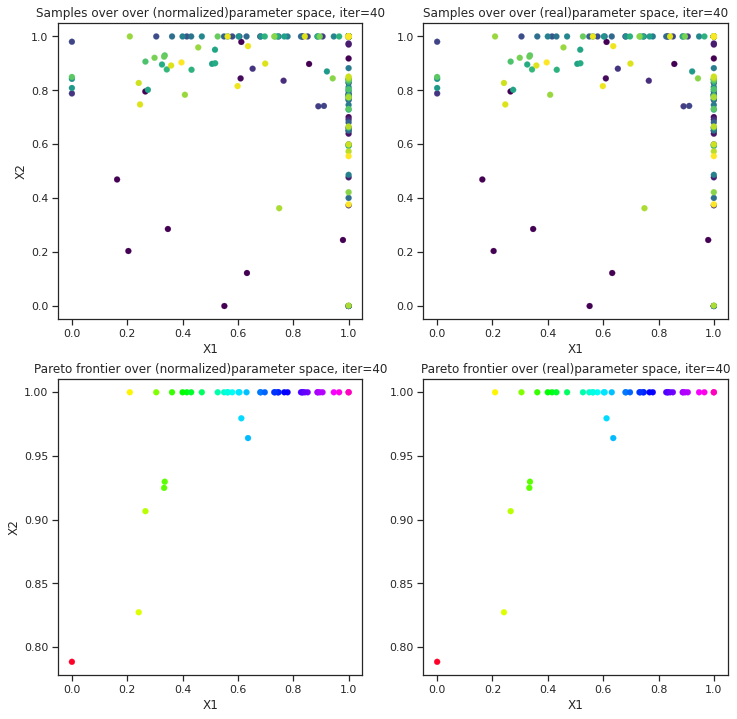

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


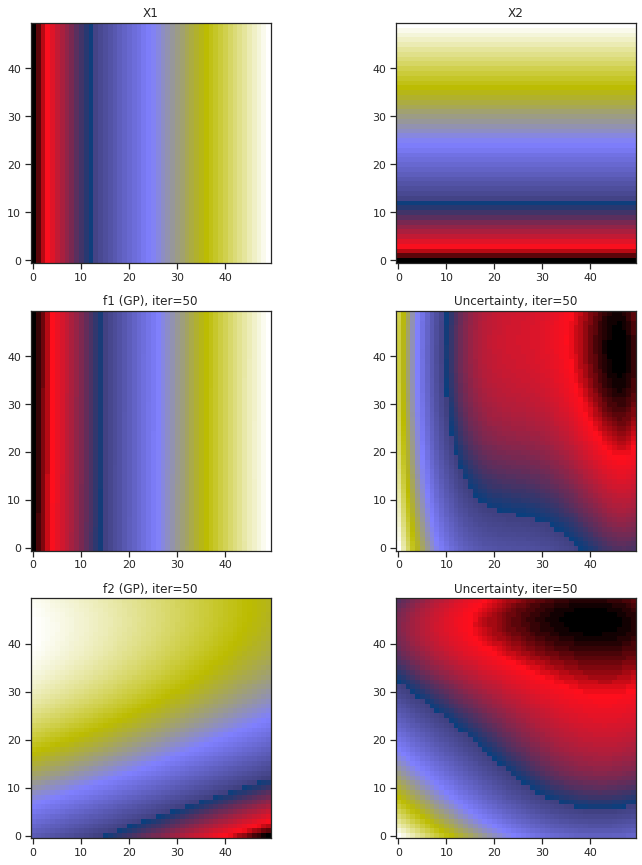

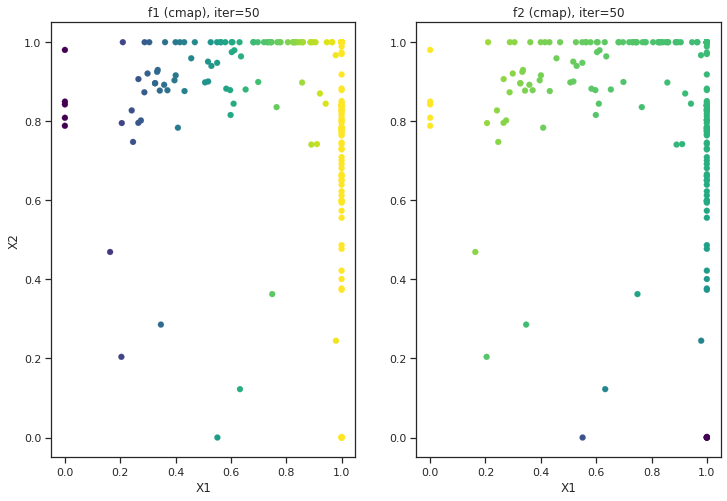

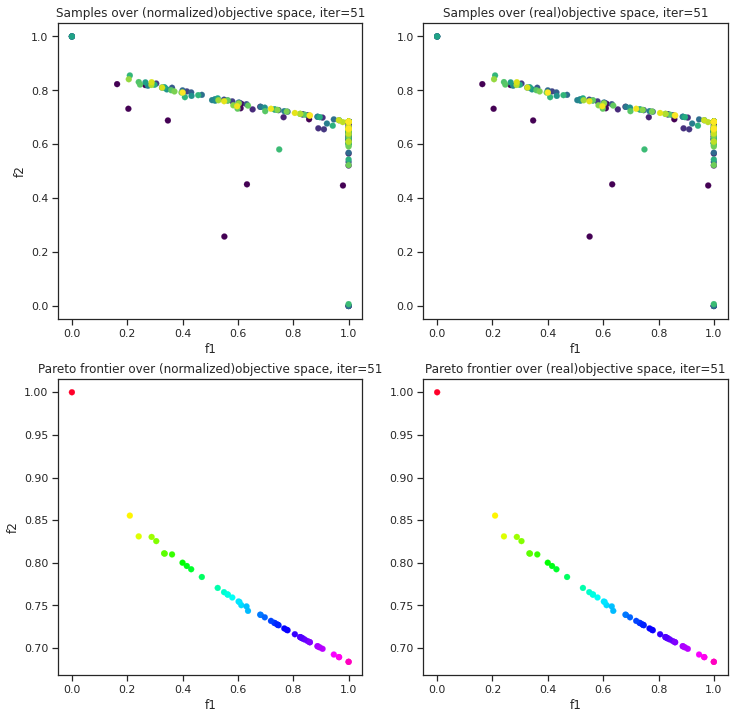

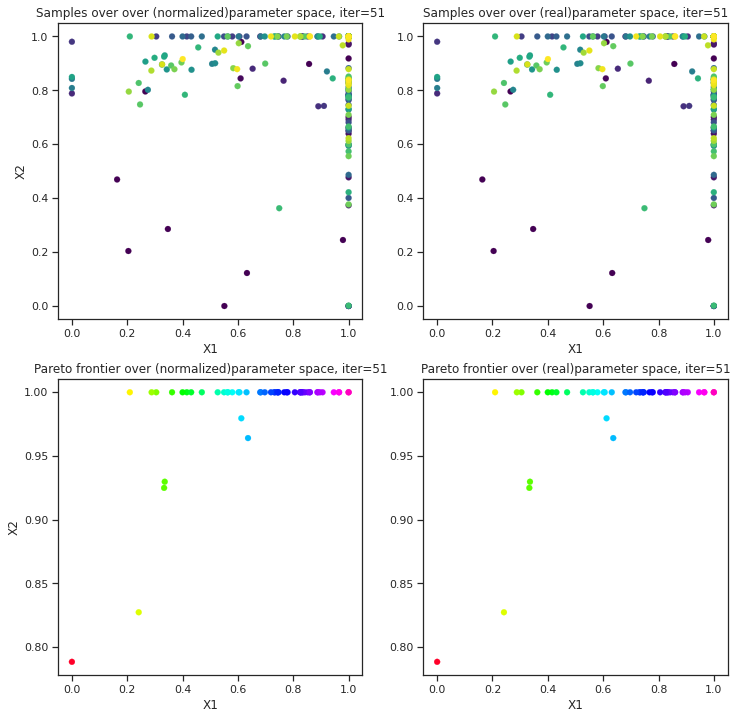

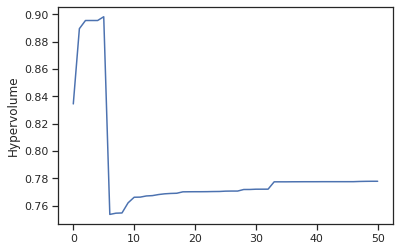

tensor(0.0058, dtype=torch.float64)
tensor(0.0029, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |      23 |            - |            -
    2 |     200 |      27 |  0.107969634 |        nadir
    3 |     300 |      50 |  0.008406783 |            f
    4 |     400 |      79 |  0.008501667 |        ideal
    5 |     500 |     100 |  0.003794414 |        nadir
    6 |     600 |     100 |  0.003901667 |            f
    7 |     700 |     100 |  0.002164742 |            f
    8 |     800 |     100 |  0.002300958 |            f
    9 |     900 |     100 |  0.002034865 |            f
   10 |    1000 |     100 |  0.002201031 |            f
   11 |    1100 |     100 |  0.005970354 |        nadir
   12 |    1200 |     100 |  0.001558952 |            f
   13 |    1300 |     100 |  0.030812556 |        nadir
   14 |    1400 |     100 |  0.001602627 |            f
   15 |    1500 |     100 |  0.001488781 |  

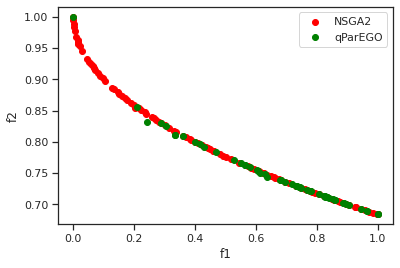

In [54]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qParEGO'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'X1'
param2 = 'X2'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'f1'
obj2 = 'f2'

#List of toy test functions
# 'ZDT1'
# '6HC-IAP'- Six hump Camel back - Inversed Ackley's path
testfunction = 'ZDT1'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#Define parameter space based on above choice of params (2D only)
num_rows =50
num = 10  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

if (testfunction =='ZDT1'):
    X1 = np.linspace(0, 1, num_rows)
    test_X1 = np.linspace(0, 1, num_rows)
    X2 = np.linspace(0, 1, num_rows)
    test_X2 = np.linspace(0, 1, num_rows)
elif (testfunction =='6HC-IAP'):
    X1 = np.linspace(-3, 3, num_rows)
    test_X1 = np.linspace(-3, 3, num_rows)
    X2 = np.linspace(-2, 2, num_rows)
    test_X2 = np.linspace(-2, 2, num_rows)
else:
    print("Invalid test function")

MOBO_testfunc(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, testfunction)

<h1> Analysis 1b

Test function- **6HC-IAP**, acquistion function - **qParEGO**, num_rows =50, num = 10, N= 50

Maximize f1, f2

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Initial evaluation complete. Start BO- acq func: qParEGO


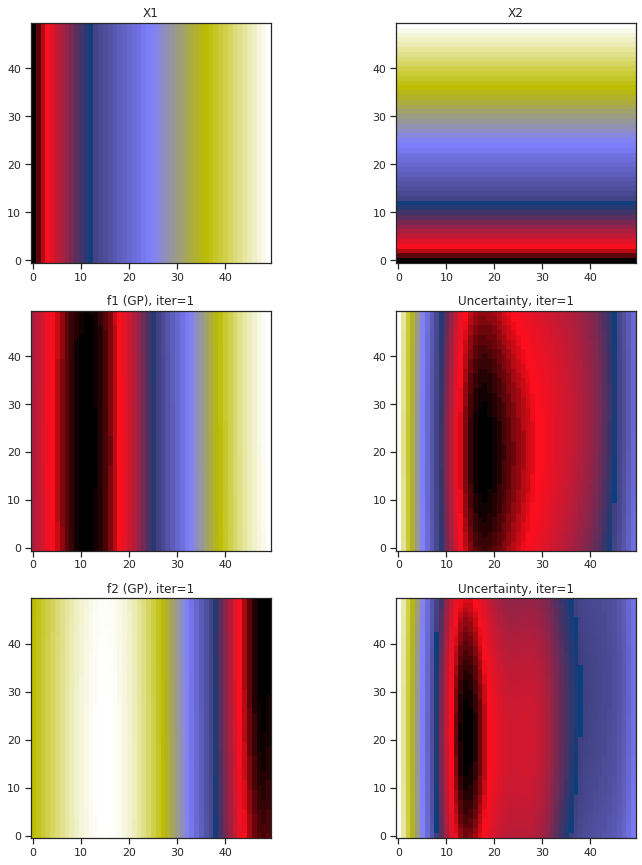

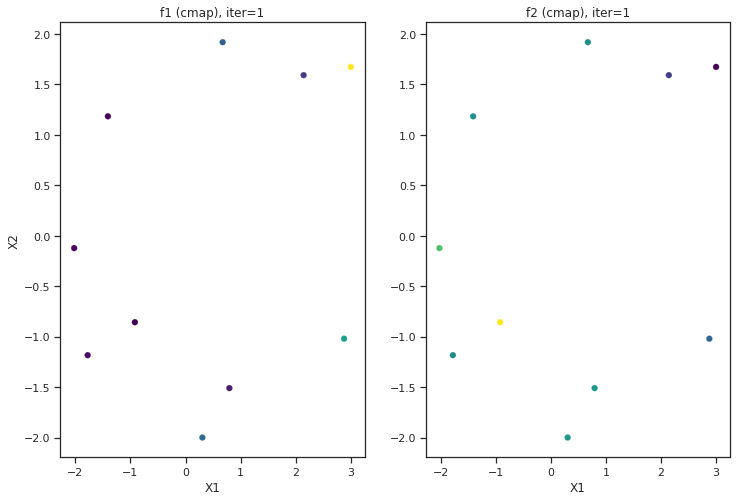

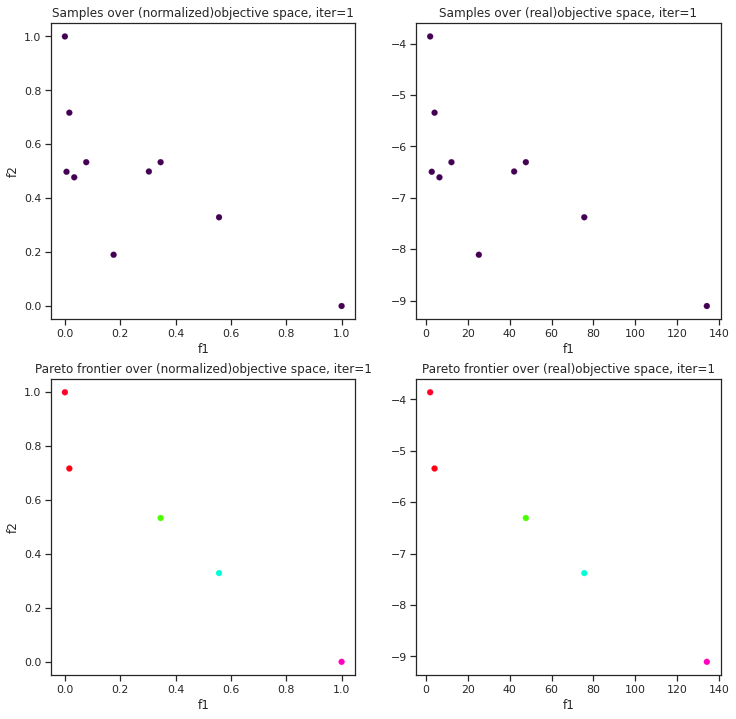

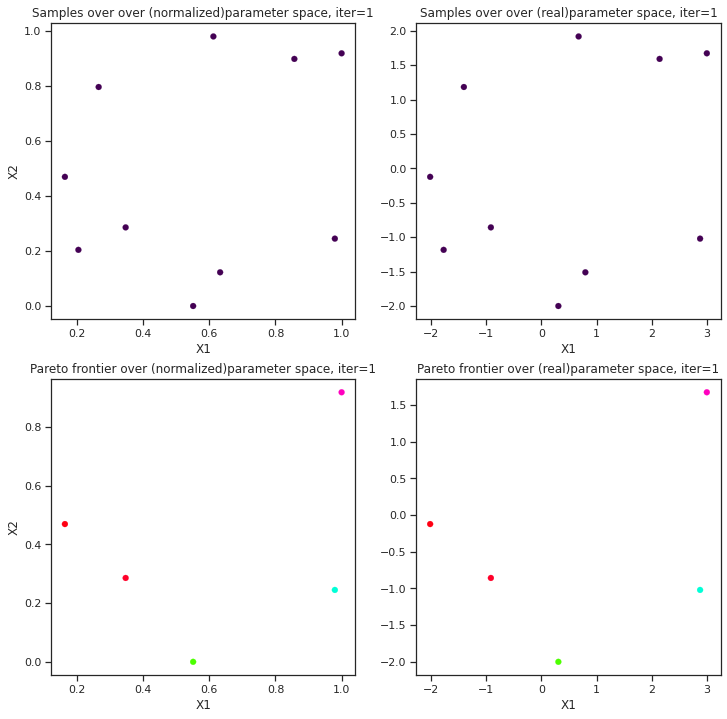

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #11
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #12
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #13
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #14
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #15
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #16
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #17
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #18
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #19
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


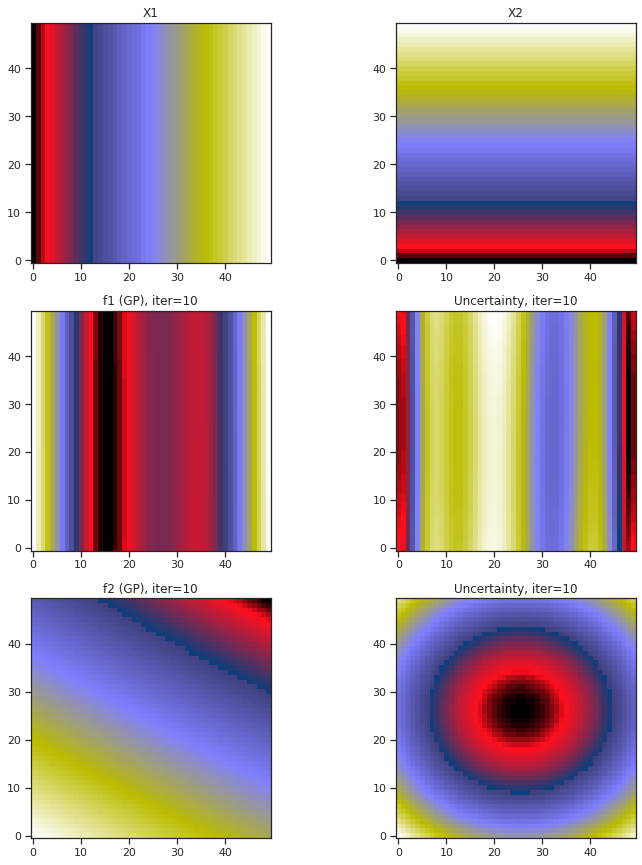

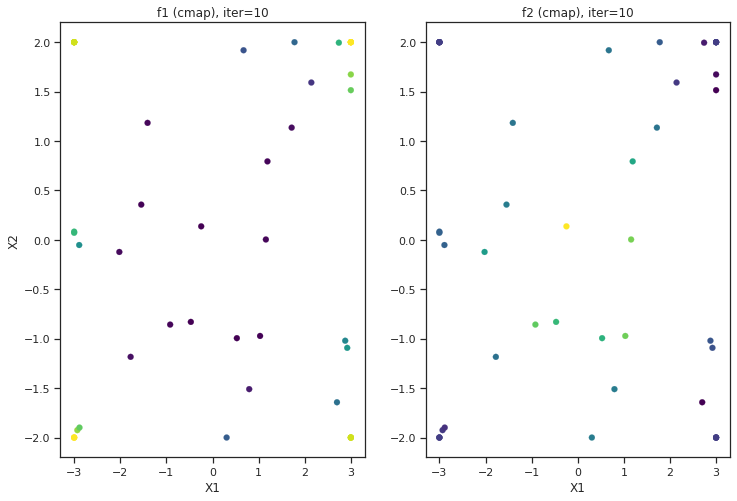

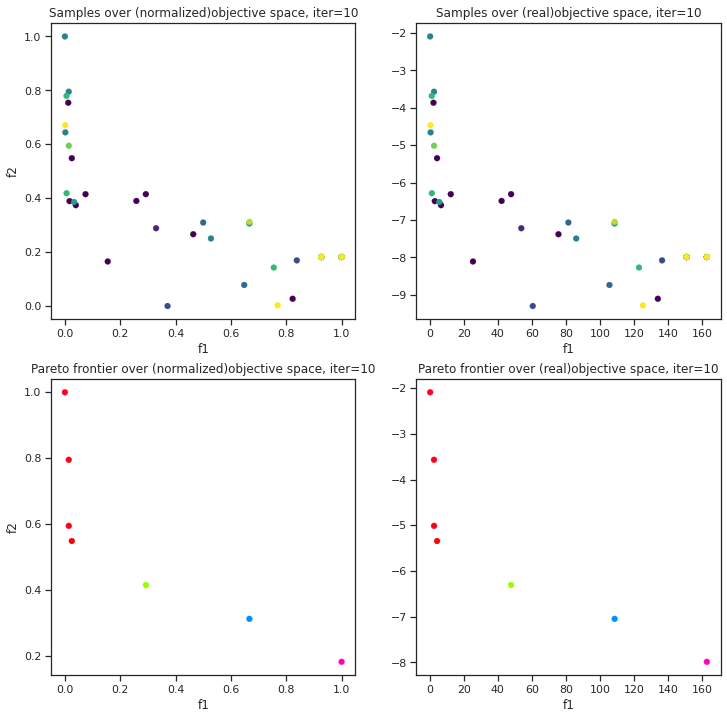

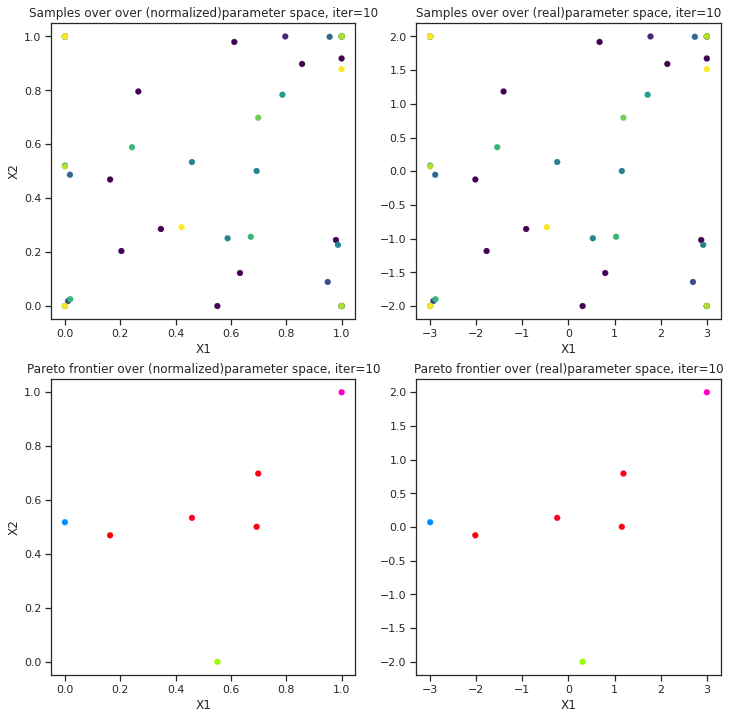

Batch Function eval #20
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


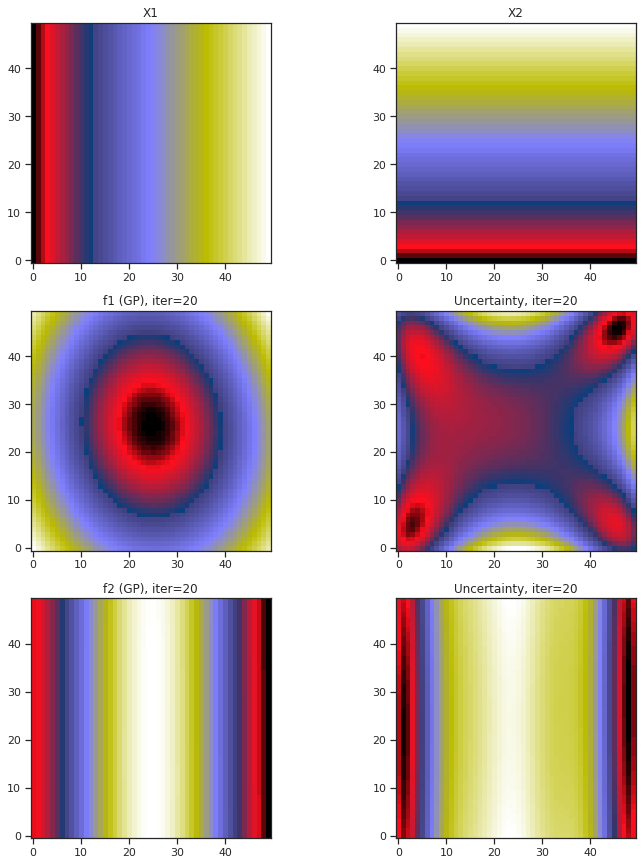

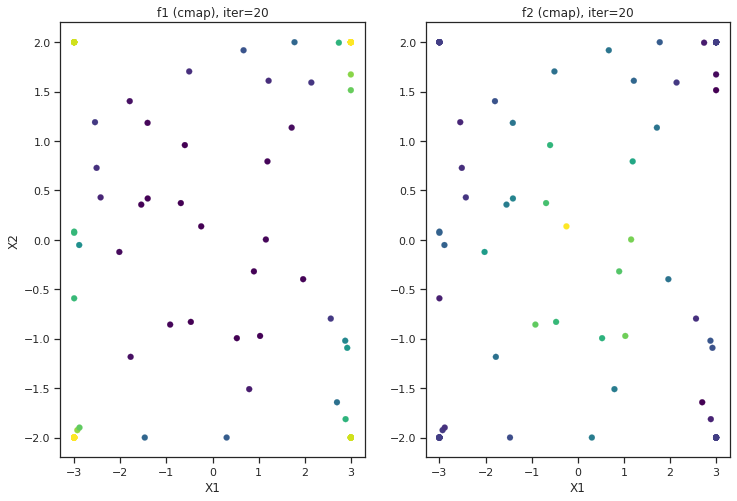

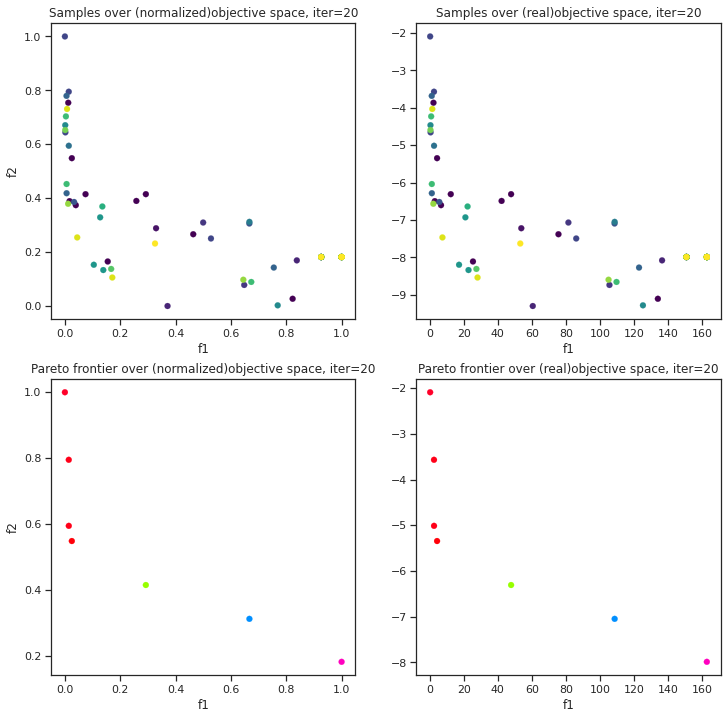

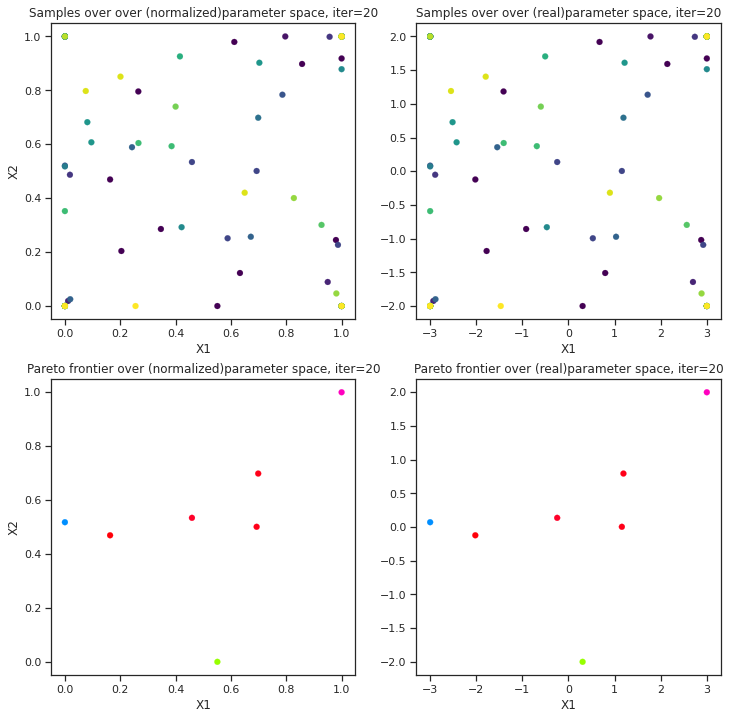

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


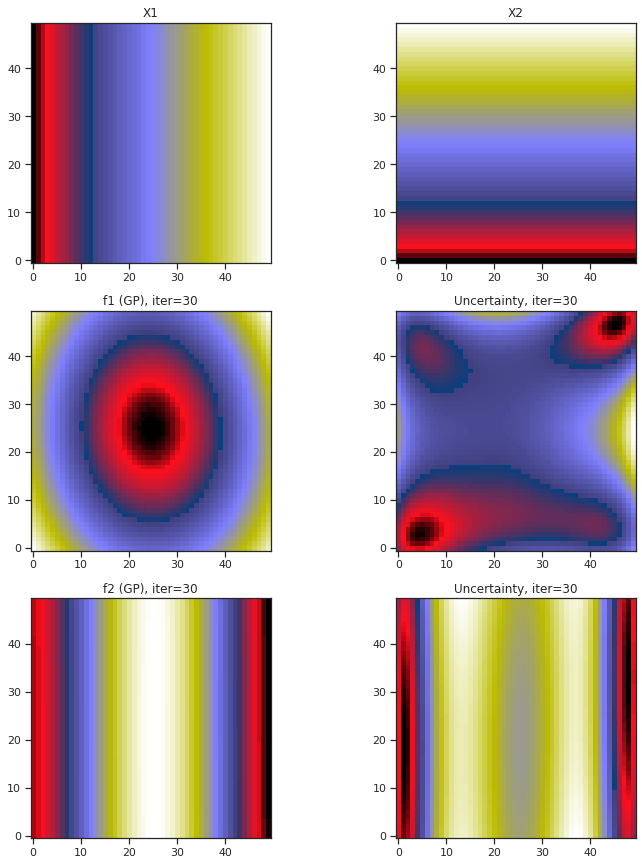

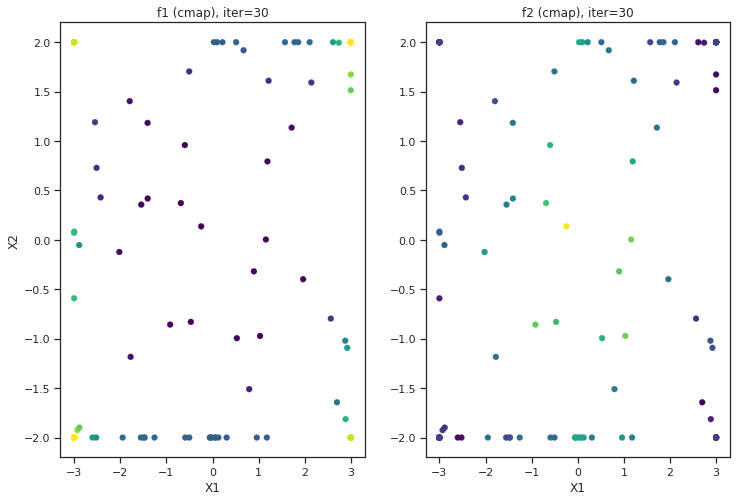

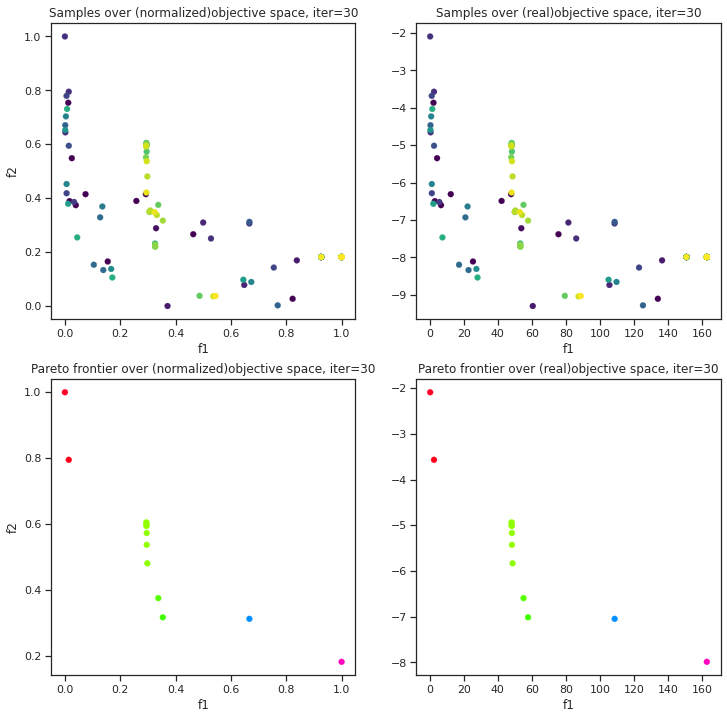

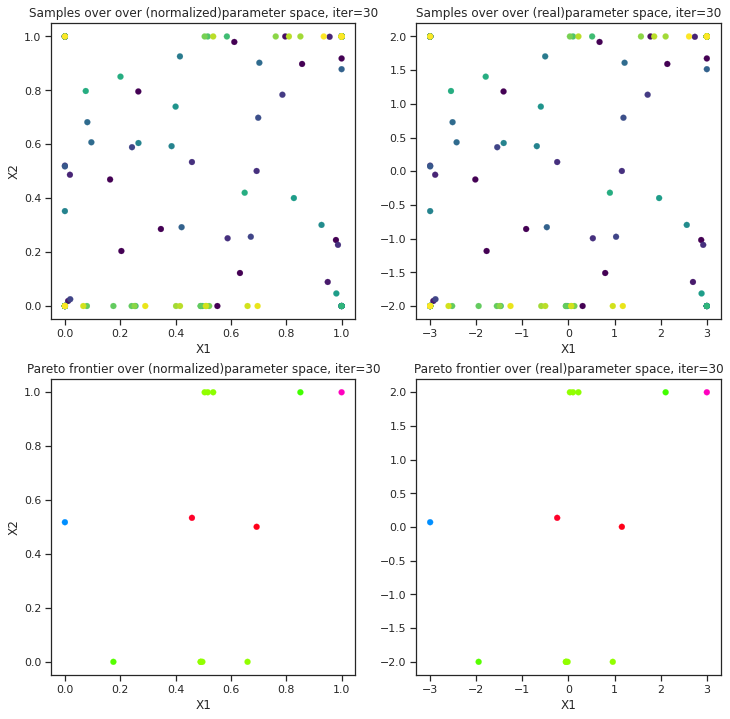

Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


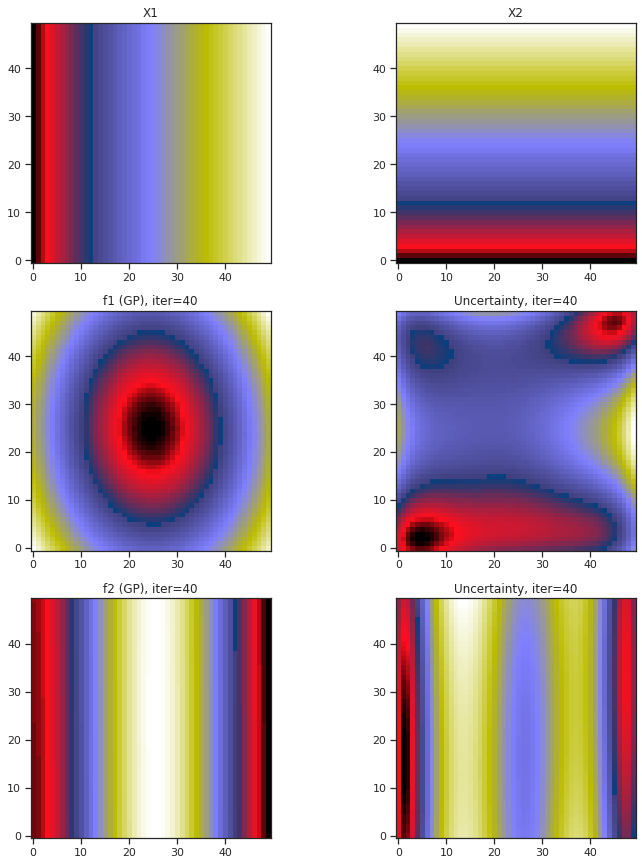

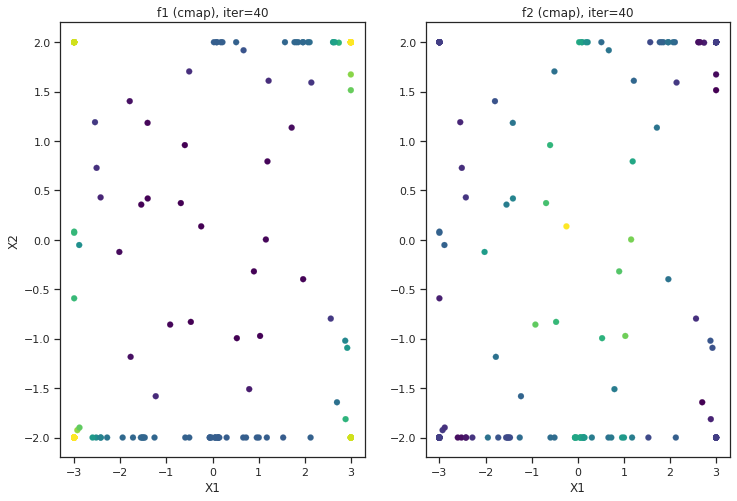

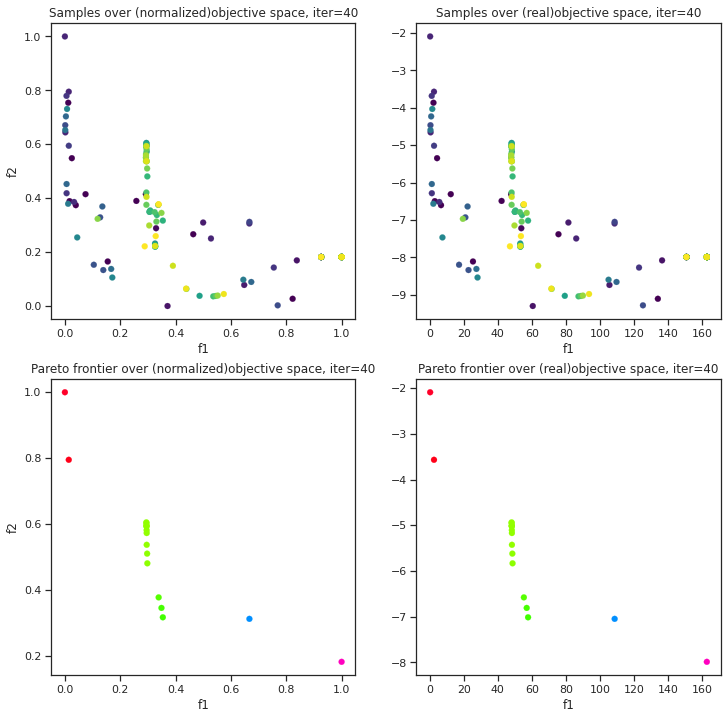

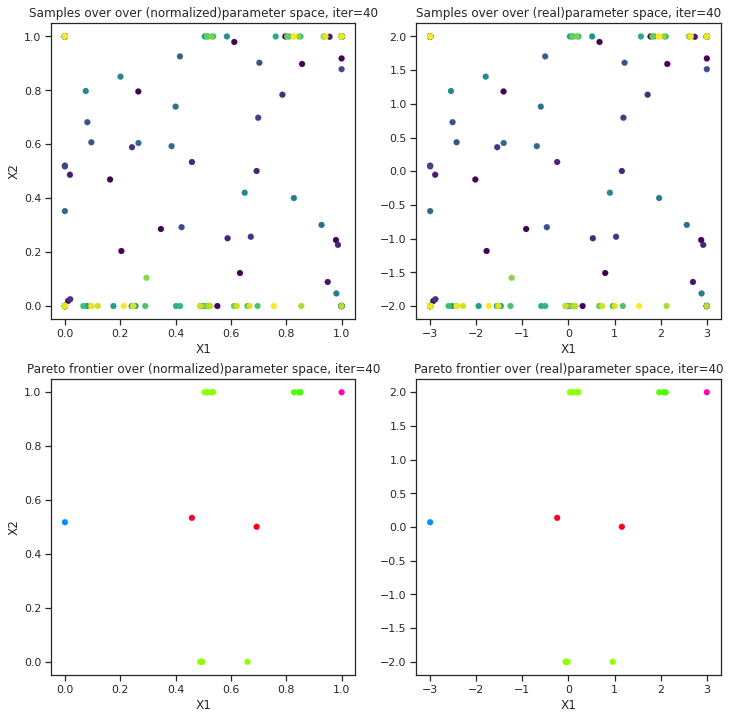

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


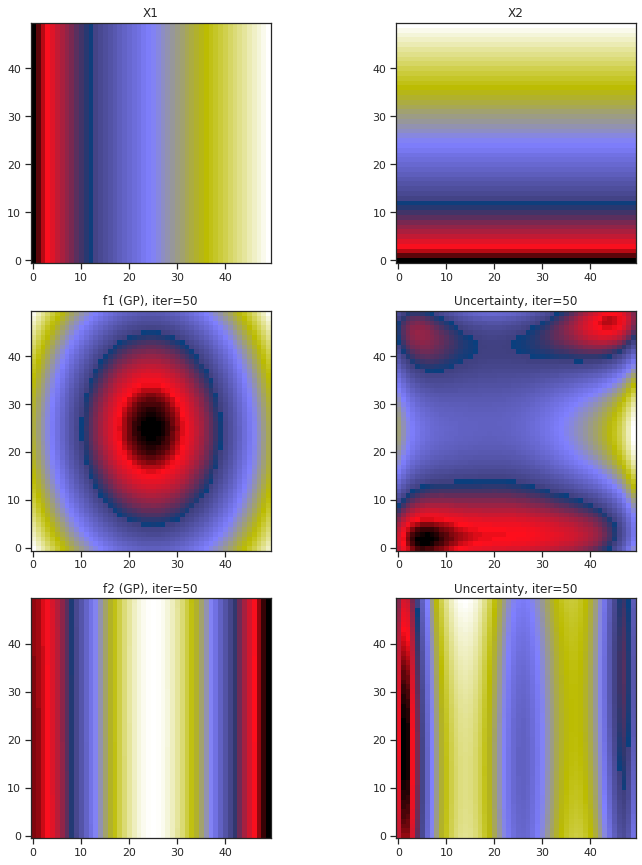

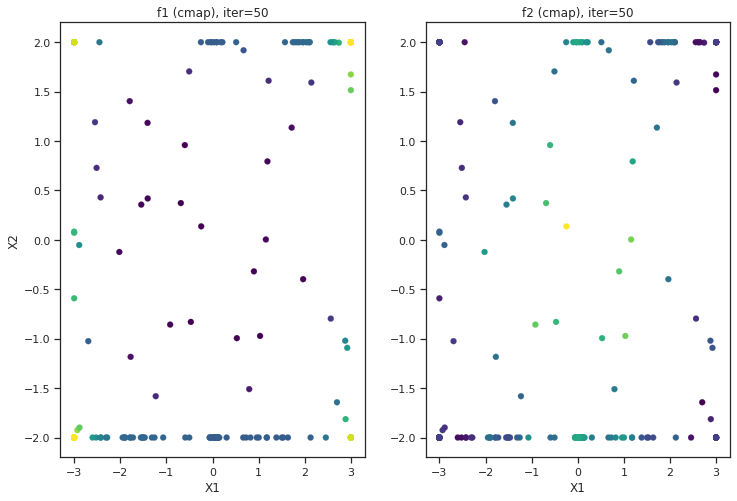

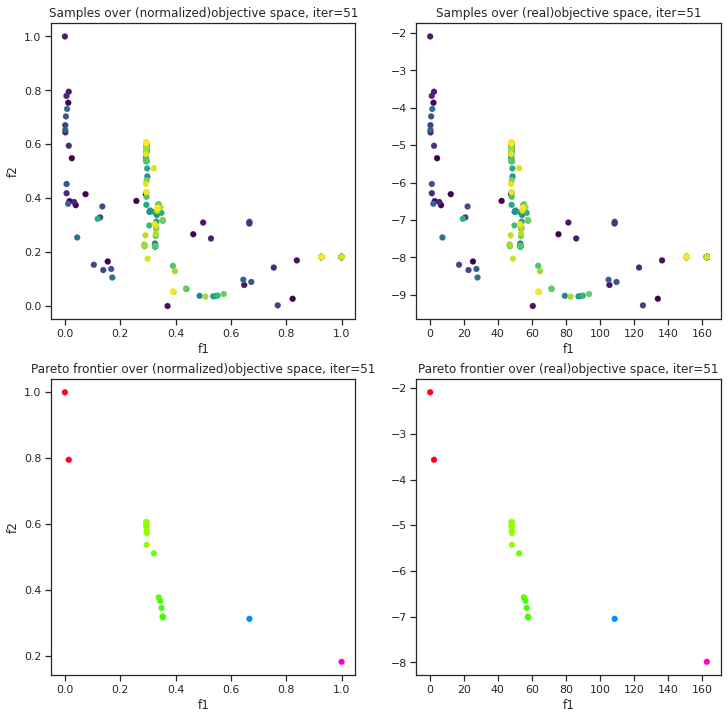

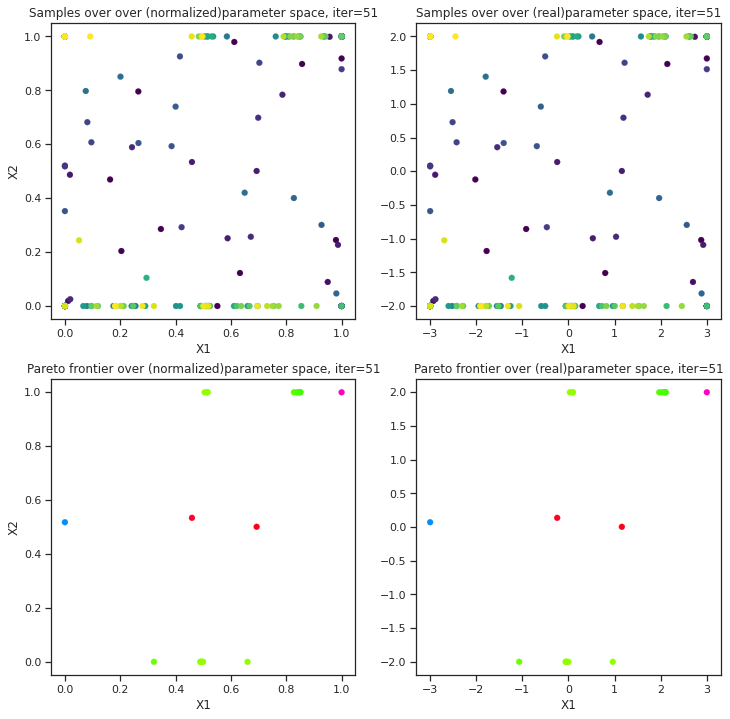

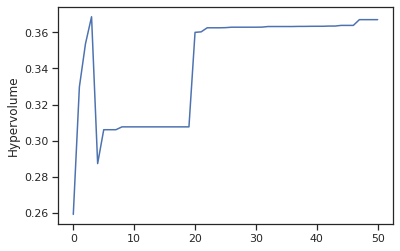

tensor(0.0130, dtype=torch.float64)
tensor(0.0007, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       8 |            - |            -
    2 |     200 |      14 |  0.191387722 |        ideal
    3 |     300 |      18 |  0.030616629 |        ideal
    4 |     400 |      26 |  0.137526363 |        ideal
    5 |     500 |      27 |  0.019992509 |        ideal
    6 |     600 |      34 |  0.011838254 |        ideal
    7 |     700 |      36 |  0.022968358 |        ideal
    8 |     800 |      46 |  0.013976818 |        ideal
    9 |     900 |      57 |  0.014916253 |        ideal
   10 |    1000 |      66 |  0.001367498 |            f
   11 |    1100 |      73 |  0.002086125 |            f
   12 |    1200 |      91 |  0.001344358 |            f
   13 |    1300 |     100 |  0.006443484 |        ideal
   14 |    1400 |     100 |  0.000854942 |            f
   15 |    1500 |     100 |  0.000907962 |  

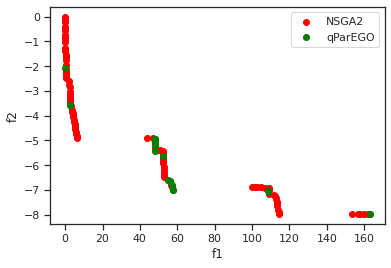

In [55]:
tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParEGO' -qParEGO
acquisition = 'qParEGO'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'X1'
param2 = 'X2'
# Choose any two objectives to do MOO (MOBO)-
obj1 = 'f1'
obj2 = 'f2'

#List of toy test functions
# 'ZDT1'
# '6HC-IAP'- Six hump Camel back - Inversed Ackley's path
testfunction = '6HC-IAP'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['max','max']

#Define parameter space based on above choice of params (2D only)
num_rows =50
num = 10  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

if (testfunction =='ZDT1'):
    X1 = np.linspace(0, 1, num_rows)
    test_X1 = np.linspace(0, 1, num_rows)
    X2 = np.linspace(0, 1, num_rows)
    test_X2 = np.linspace(0, 1, num_rows)
elif (testfunction =='6HC-IAP'):
    X1 = np.linspace(-3, 3, num_rows)
    test_X1 = np.linspace(-3, 3, num_rows)
    X2 = np.linspace(-2, 2, num_rows)
    test_X2 = np.linspace(-2, 2, num_rows)
else:
    print("Invalid test function")

MOBO_testfunc(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem, testfunction)

<h1> Physics based Numerical Model

Lets try with a physics based numerical Ferrosim Model - developed by Rama Vasudevan

In [6]:
#@title Installations
!pip install git+https://github.com/ramav87/FerroSim.git

  Cloning https://github.com/ramav87/FerroSim.git to /tmp/pip-req-build-vhb278zi
  Running command git clone -q https://github.com/ramav87/FerroSim.git /tmp/pip-req-build-vhb278zi
  Created wheel for FerroSim: filename=FerroSim-0.0.1-py3-none-any.whl size=6058 sha256=79a605ee3de6075965c3a6b1b561de0b74e28e036839b85f708975c1d868addf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ycx1vbh0/wheels/a3/cf/a5/e75b66abcad38f13ac2ffe7d2dd58dd6a290905bb77615463f
Successfully built FerroSim


In [7]:
from ferrosim import Ferro2DSim

<h1> MOBO framework (2D case - 2 objectives)

FerroSim model example

In [8]:
def cal_objective1(lattice_size, random_field, def_num, rTip):
    sim = Ferro2DSim(n=lattice_size, defect_number=def_num, rfield_strength=random_field, rTip=rTip)
    results = sim.runSim()
    l_area = ((sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum())/(100*250)
    switch_P = (sim.results['Polarization'][500] - sim.results['Polarization'][250])/100

    return l_area, switch_P

def cal_objective2(lattice_size, random_field, def_num, rTip):
    sim = Ferro2DSim(n=lattice_size, defect_number=def_num, rfield_strength=random_field, rTip=rTip)
    results = sim.runSim()
    l_area = ((sim.results['Polarization'][375:625]-sim.results['Polarization'][125:375]).sum())/(100*250)
    switch_P = (sim.results['Polarization'][500] - sim.results['Polarization'][250])/100
    target_switchP = 1.5
    tol_switchP = 0.05*target_switchP
    dist_target= np.exp((-(switch_P-target_switchP)**2)/tol_switchP**2)

    return l_area, dist_target

def normalize_get_initialdata_ferroSim(X1, X2, test_X1, test_X2, num_rows, num, problem, obj2, m):
    # Normalize X
    minX1 = min(X1)
    maxX1 = max(X1)
    minX2 = min(X2)
    maxX2 = max(X2)
    Xmin = np.hstack((minX1, minX2))
    Xmax = np.hstack((maxX1, maxX2))
    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)
    X1_norm = (X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    X2_norm = (X2 - Xmin[1]) / (Xmax[1] - Xmin[1])
    testX1_norm = (test_X1 - Xmin[0]) / (Xmax[0] - Xmin[0])
    testX2_norm = (test_X2 - Xmin[1]) / (Xmax[1] - Xmin[1])

    # Select starting samples randomly as training data
    testX1_norm = np.reshape(testX1_norm, (num_rows ** 2, 1))
    testX2_norm = np.reshape(testX2_norm, (num_rows ** 2, 1))
    test_X1 = np.reshape(test_X1, (num_rows ** 2, 1))
    test_X2 = np.reshape(test_X2, (num_rows ** 2, 1))
    np.random.seed(10)
    ind_start = np.random.choice(len(testX1_norm) - 1, size=num, replace=False)
    train_X = np.zeros((num, 2))
    train_X_norm = np.zeros((num, 2))
    train_y = np.zeros((num, 2))
    t_y = np.zeros((num_rows ** 2, 2))
    m = 0
    print("Function evaluaton for initial randomly selected samples")
    for i in range(0, num):
        train_X_norm[i, 0] = testX1_norm[ind_start[i]]
        train_X_norm[i, 1] = testX2_norm[ind_start[i]]
        train_X[i, 0] = test_X1[ind_start[i]]
        train_X[i, 1] = test_X2[ind_start[i]]
        print("Function eval #" + str(m + 1))
        if (obj2 == "switch_P"):
           LA, SP = cal_objective1(10, train_X[i, 0], int(train_X[i, 1]), rTip=3)
        else:
           LA, SP = cal_objective2(10, train_X[i, 0], int(train_X[i, 1]), rTip=3)

        if (problem[0] == 'min'):
            train_y[i, 0] = -LA  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 0] = -LA  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 0] = LA
            t_y[ind_start[i], 0] = LA

        if (problem[1] == 'min'):
            train_y[i, 1] = -SP  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
            t_y[ind_start[i], 1] = -SP  # By default, BO settting is for maximization, for minimization we just use f(x) =-f(x)
        else:
            train_y[i, 1] = SP
            t_y[ind_start[i], 1] = SP

        # testX1_norm[ind_start[i]] =-1
        # testX2_norm[ind_start[i]] =-1
        m = m + 1

    testX1_norm = np.reshape(testX1_norm, (num_rows, num_rows))
    testX2_norm = np.reshape(testX2_norm, (num_rows, num_rows))
    t_y = np.reshape(t_y, (num_rows, num_rows, 2))

    # Convert to torch
    train_X_norm = to.from_numpy(train_X_norm)
    train_X_norm = train_X_norm.double()
    train_Y = to.from_numpy(train_y)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm

    return X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m

def augment_newdata_ferroSim(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, obj2, m):
    nextX_norm = acq_X
    nextX = nextX_norm * (to.from_numpy(Xmax) - to.from_numpy(Xmin)) + to.from_numpy(Xmin)
    nextX = nextX.detach().numpy()
    train_X_norm = to.cat((train_X_norm, nextX_norm), 0)
    train_X_norm = train_X_norm.double()
    train_X = np.vstack((train_X, nextX))
    next_feval = to.empty(BATCH_SIZE, 2)
    print("Batch Function eval #" + str(m + 1))

    for j in range(0, BATCH_SIZE):
        # Function evaluation for new data
        print("Within batch: Function eval: " + str(j + 1) + " of " + str(BATCH_SIZE))
        if (obj2 == "switch_P"):
           LA, SP = cal_objective1(10, nextX[j, 0], int(nextX[j, 1]), rTip=3)
        else:
           LA, SP = cal_objective2(10, nextX[j, 0], int(nextX[j, 1]), rTip=3)

        if (problem[0] == 'min'):
            next_feval[j, 0] = -LA
        else:
            next_feval[j, 0] = LA
        if (problem[1] == 'min'):
            next_feval[j, 1] = -SP
        else:
            next_feval[j, 1] = SP

    train_Y = to.cat((train_Y, next_feval), 0)
    # Normalize Y
    testY1_norm = (train_Y[:, 0] - train_Y[:, 0].min()) / (train_Y[:, 0].max() - train_Y[:, 0].min())
    testY2_norm = (train_Y[:, 1] - train_Y[:, 1].min()) / (train_Y[:, 1].max() - train_Y[:, 1].min())
    train_Y_norm = to.empty(train_Y.__len__(), 2)
    train_Y_norm[:, 0] = testY1_norm
    train_Y_norm[:, 1] = testY2_norm
    m = m + 1
    return train_X, train_X_norm, train_Y, train_Y_norm, m






In [9]:
def MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem):
        ##MOBO framework#######
    m=0
    X1_norm, X2_norm, testX1_norm, testX2_norm, train_X, train_X_norm, train_Y, train_Y_norm, Xmin, Xmax, t_y, m=\
        normalize_get_initialdata_ferroSim(X1, X2, test_X1, test_X2, num_rows, num, problem, obj2, m)

    X1, X2 = np.meshgrid(X1, X2)
    test_X1, test_X2 = np.meshgrid(test_X1, test_X2)

    print("Initial evaluation complete. Start BO- acq func: " +str(acquisition))
    # Gp model fit
    gp_surro= optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)

    # compute pareto front
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_x = train_X[pareto_mask]
    pareto_y = train_Y[pareto_mask]
    # compute hypervolume
    hvs = []
    rf= to.tensor([0.0] * 2)-0.001
    hv = Hypervolume(ref_point=rf)
    volume = hv.compute(pareto_y_norm)
    hvs.append(volume)


    for i in range(1, N + 1):

        if (i == 1 or i == 10 or i == 20 or i == 30 or i == 40 or i == 90 or i == 140 or i == 190 or i == 240):
            #Calculate posterior for analysis for intermidiate iterations
            y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
            plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)
            plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)

        # List of acquisition functions as per user choice- functions from BOtorch packages
        if (acquisition == 'qEHVI'):

            acq_X, acq_val = optimize_qehvi(gp_surro, train_X_norm, train_Y_norm, rf, BATCH_SIZE)
            val = to.mean(acq_val)

        elif (acquisition == 'qParEGO'):

            acq_X, acq_val = optimize_qparego(gp_surro, train_X_norm, train_Y_norm, BATCH_SIZE)
            val = to.mean(acq_val)

    ################################################################
        ## Find next point which maximizes the learning through exploration
        if (i == 1):
            val_ini = val
        # Check for convergence
        if ((val) < 0):  # Stop for negligible expected improvement
            print("Model converged due to sufficient learning over search space ")
            break
        else:
            # Evaluate true function for new data, augment data
            train_X, train_X_norm, train_Y, train_Y_norm, m = augment_newdata_ferroSim(acq_X, train_X, train_X_norm, train_Y, Xmin, Xmax, BATCH_SIZE, num_rows, problem, obj2, m)

            #Update Pareto front, compute hypervolume
            # compute pareto front
            pareto_mask_norm = is_non_dominated(train_Y_norm)
            pareto_y_norm = train_Y_norm[pareto_mask_norm]
            pareto_x_norm = train_X_norm[pareto_mask_norm]
            pareto_mask = is_non_dominated(train_Y)
            pareto_x = train_X[pareto_mask]
            pareto_y = train_Y[pareto_mask]
            # compute hypervolume
            volume = hv.compute(pareto_y_norm)
            hvs.append(volume)

            # Updating GP model, conditioning on new data
            # Gp model fit
            gp_surro = optimize_hyperparam_trainGP(train_X_norm, train_Y_norm)


    ## Final posterior prediction after all the sampling done

    if (i == N):
        print("Max. sampling reached, model stopped")

    #Posterior calculation with converged GP model
    y_pred_means, y_pred_vars = cal_posterior(gp_surro, testX1_norm, testX2_norm, t_y, num_rows)
    plot_exploration_results(X1, X2, y_pred_means, y_pred_vars, train_X, train_Y, i, param1, param2, obj1, obj2, problem)


    # Plotting pareto frontier #

    # compute pareto front
    pareto_mask_norm = is_non_dominated(train_Y_norm)
    pareto_y_norm = train_Y_norm[pareto_mask_norm]
    pareto_x_norm = train_X_norm[pareto_mask_norm]
    pareto_mask = is_non_dominated(train_Y)
    pareto_x = train_X[pareto_mask]
    pareto_y = train_Y[pareto_mask]
    if (i == N):
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, N, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    else:
        plotPareto(pareto_y, pareto_y_norm, pareto_x, pareto_x_norm, train_Y, train_Y_norm, train_X, train_X_norm, num, i - 1, BATCH_SIZE, param1, param2, obj1, obj2, problem)
    # compute hypervolume
    #volume = hv.compute(pareto_y_norm)
    #hvs.append(volume)
    plt.plot(hvs)
    plt.ylabel("Hypervolume")
    plt.show()

    print(val_ini)
    print(val)

     #Compare with Pareto solutions using NGSA2 (this is only for test purpose- not a part of MOBO framework)
    print("Run NSGA 2 for test function-- Without MOBO")
    from pymoo.algorithms.nsga2 import NSGA2
    from pymoo.model.problem import Problem
    from pymoo.optimize import minimize
    from pymoo.visualization.scatter import Scatter

    if (obj2 == "switch_P"):
        class MyProblem(Problem):

            def __init__(self):
                super().__init__(n_var=2,
                                n_obj=2,
                                n_constr=0,
                                xl=np.array([0, 0]),
                                xu=np.array([100, 100]),
                                elementwise_evaluation=True)

            def _evaluate(self, x, out, *args, **kwargs):

                x1 = x[0]
                x2 = x[1]
                LA, SP = cal_objective1(10, x1, int(x2), rTip=3)
            
                #Transform to min-max problem
                f1 = LA
                f2 = -SP
                out["F"] = [f1, f2]
                #out["G"] = [g1, g2]
        
    else:
        class MyProblem(Problem):

            def __init__(self):
                super().__init__(n_var=2,
                                n_obj=2,
                                n_constr=0,
                                xl=np.array([0, 0]),
                                xu=np.array([100, 100]),
                                elementwise_evaluation=True)

            def _evaluate(self, x, out, *args, **kwargs):

                x1 = x[0]
                x2 = x[1]
                LA, SP = cal_objective2(10, x1, int(x2), rTip=3)
            
                #Transform to min-max problem
                f1 = LA
                f2 = -SP
                out["F"] = [f1, f2]
                #out["G"] = [g1, g2]


    problem_ferro = MyProblem()

    algorithm = NSGA2(pop_size=11)

    res = minimize(problem_ferro,
                  algorithm,
                  ("n_gen", 20),
                  verbose=True,
                  seed=1,
                  save_history=True)


    #plot = Scatter()
    #Transforming to true values for maximization problem
    #res.F = -res.F
    #plot.add(res.F, color='red', label = 'NSGA2')
    #plot.add(pareto_y[:, 0], pareto_y[:, 1], color='green', label = str(acquisition))
    if (problem[0]=='min'): #Transform to original function value
        pareto_y[:,0] = -pareto_y[:,0]
    if (problem[1]=='min'): #Transform to original function value
        pareto_y[:,1] = -pareto_y[:,1]

    plt.scatter(res.F[:, 0], -res.F[:, 1], color='red', label = 'NSGA2')
    plt.scatter(pareto_y[:, 0], pareto_y[:, 1], color='green', label = str(acquisition))
    plt.xlabel(str(obj1))
    plt.ylabel(str(obj2))
   
    plt.legend(loc="best")
    plt.show()

<h1>User Inputs

**Provide BATCH_SIZE #** (default = 4)

**We include 2 acquistion functions-**
1. qEHVI 
2. qParEGO

**We can switch the optimization problem for objective 1 and 2 individually-**
1. Maximization problem (Default setting in BO)
2. Minimization problem

Example: problem =['min','max'] means obj 1 and 2 will be minimized and maximized respectively

**Other user inputs-**
1. num_rows (define the image map density (num_rows X num_rows), default = 20)
2. num (# of starting samples, default = 20)
3. N (maximum BO iteration, default =45)

<h1>Analysis 2a

field strength vs defect#

lattice grid size =10

20x20 grid space, Max func evaluation- 50 (max iter)x 4(batch_size) + 20(starting samples)

$defect = [0, 100]; fStrength =[0, 100]$

**Minimize Loop Area and Maximize Switchable Polarization** - Adaptive sampling to balance between low Loop Area and high Switchable Polarization and find the pareto frontier.

With qParEGO

Run MOBO - this will take a while to run...

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


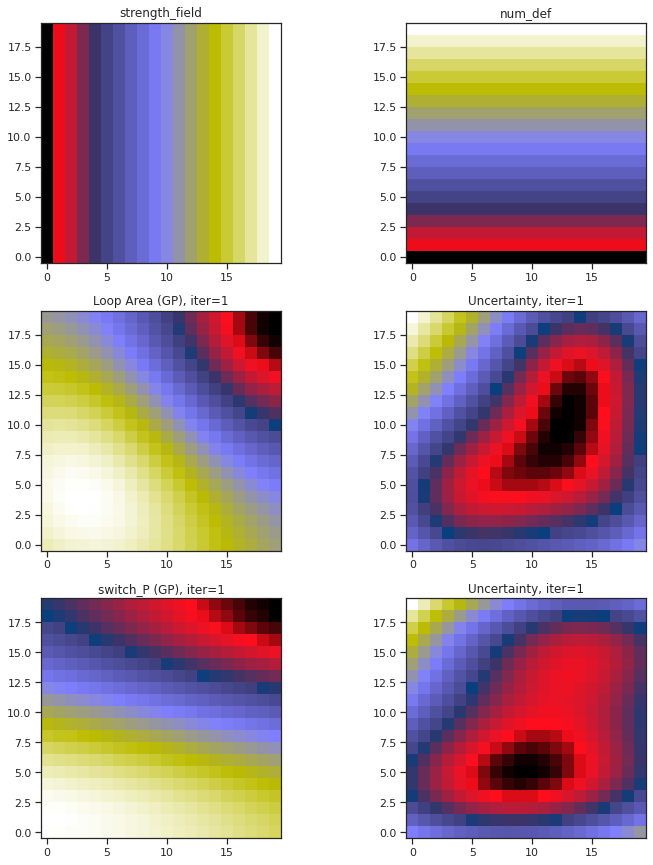

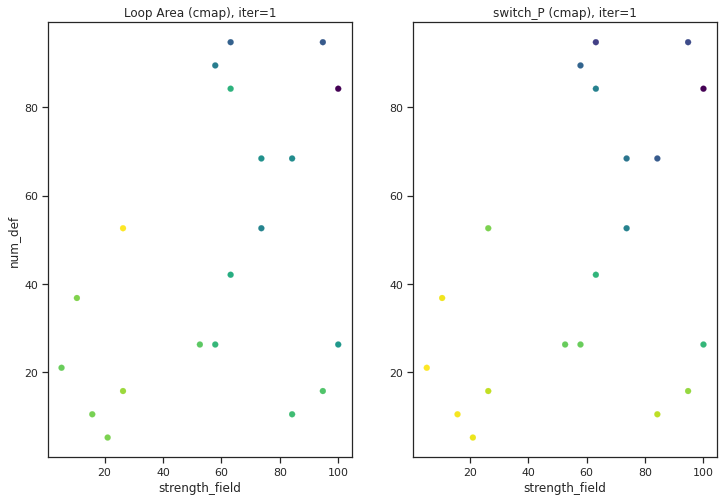

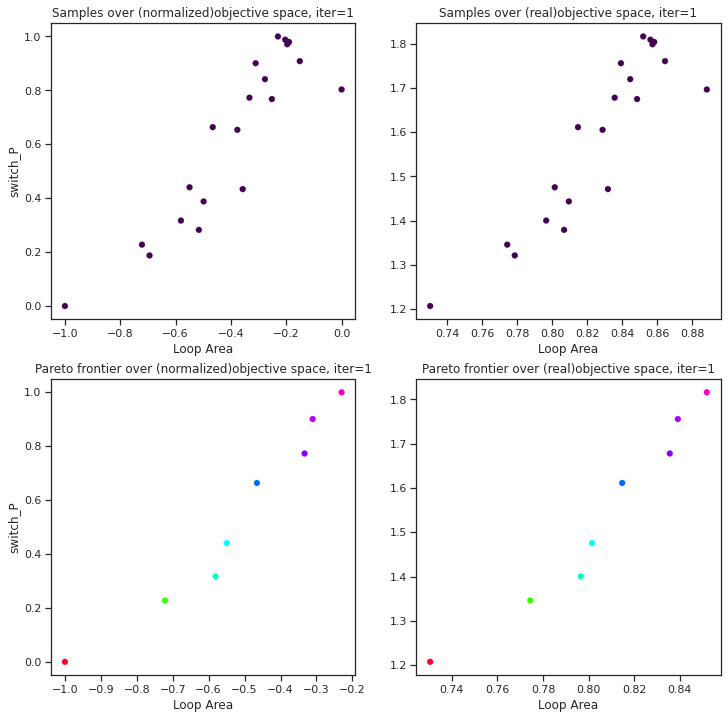

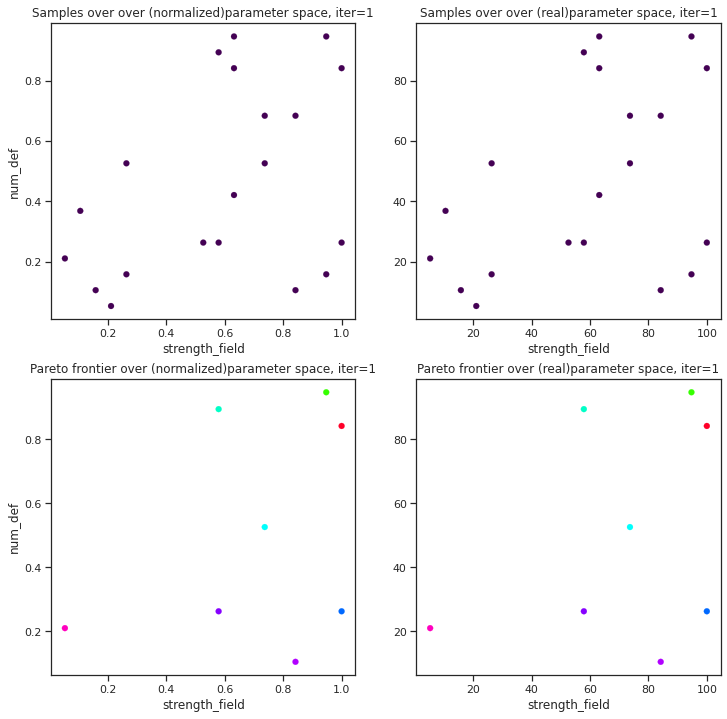

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


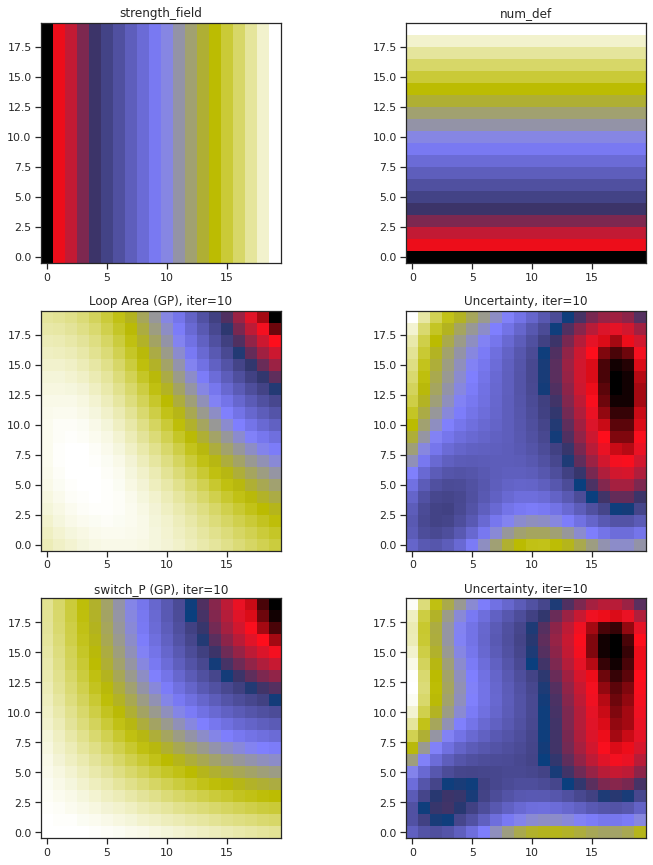

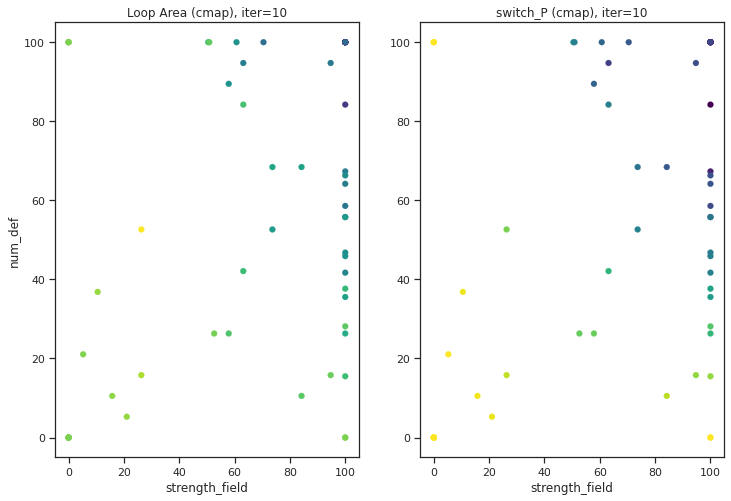

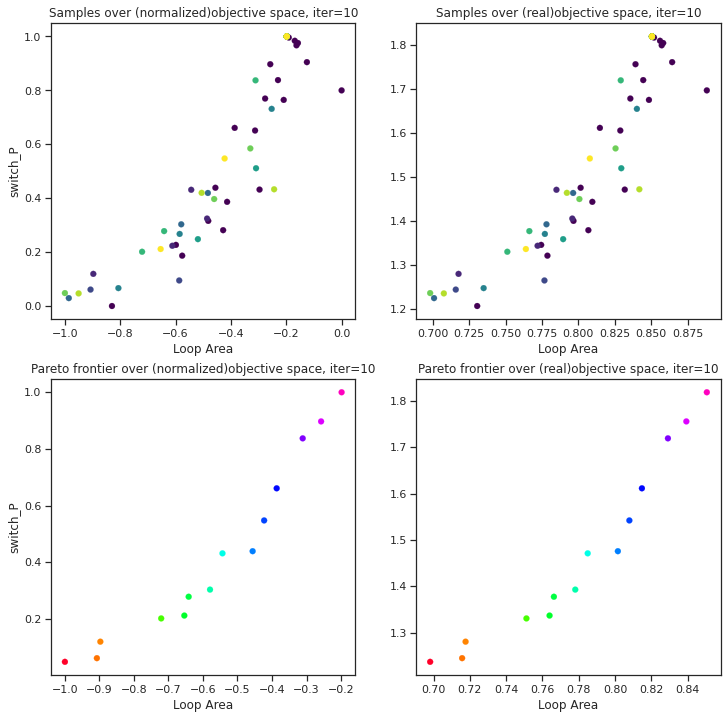

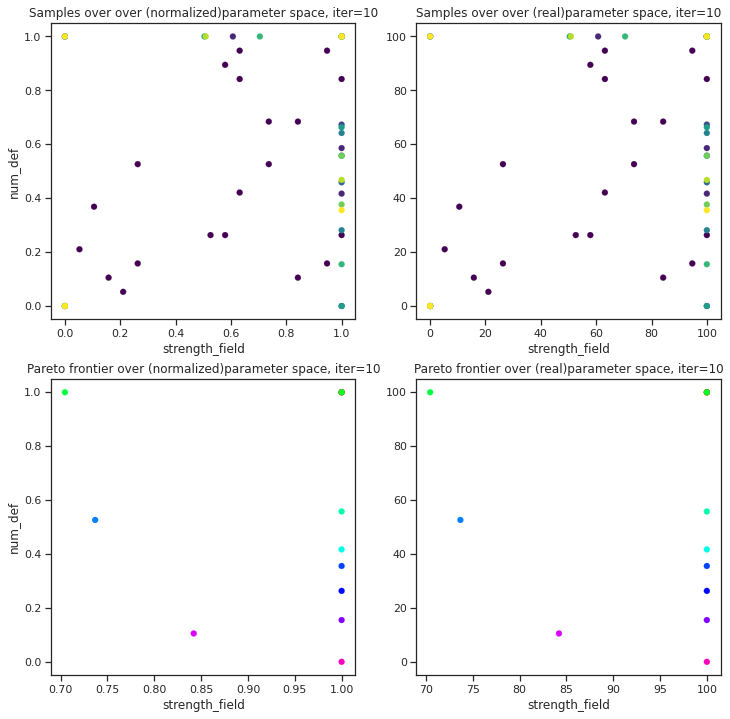

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


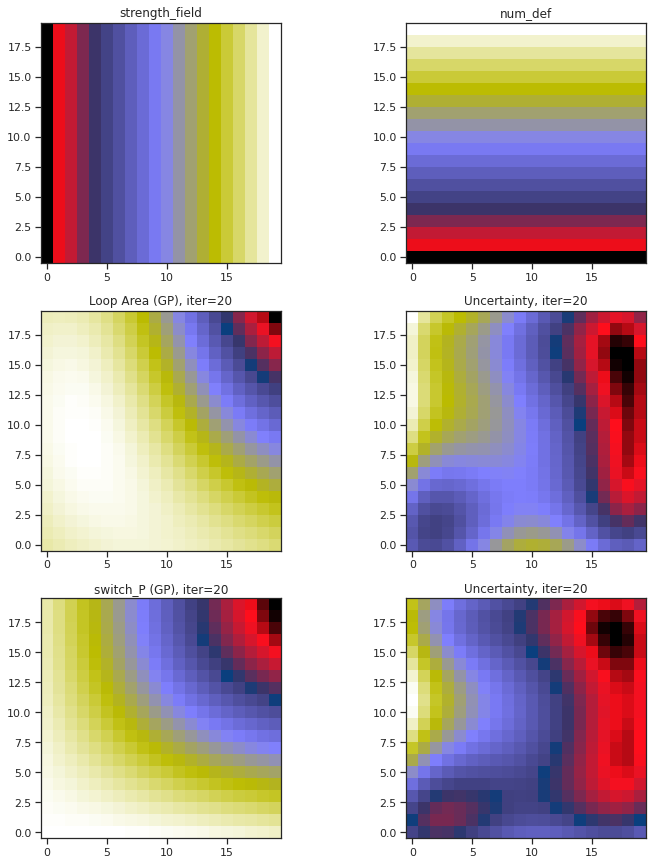

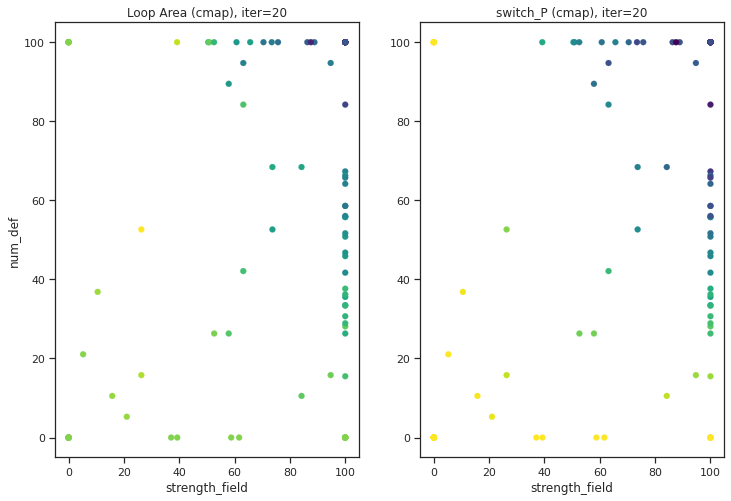

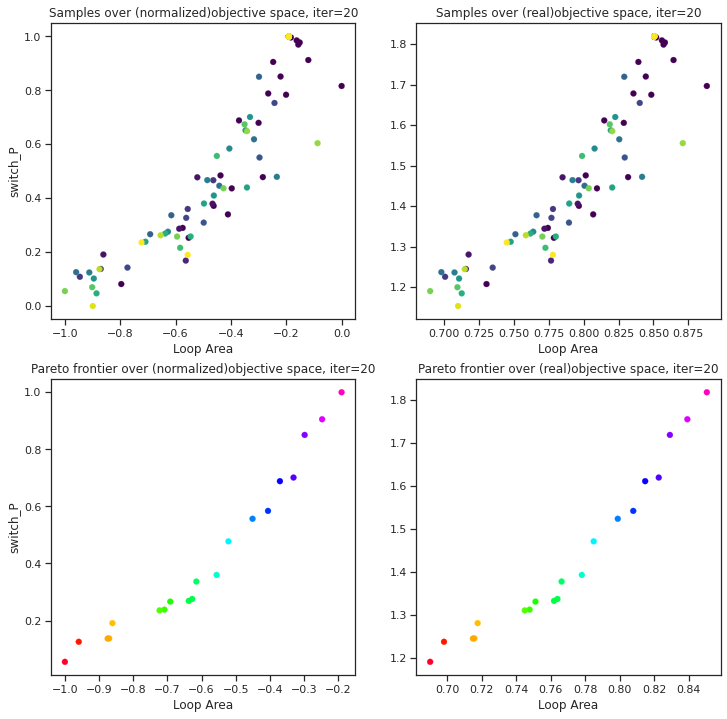

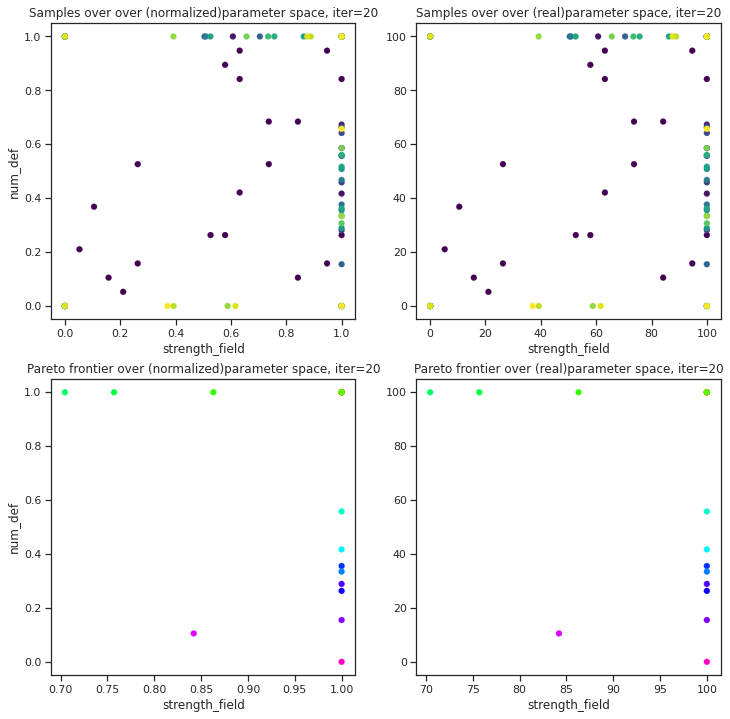

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


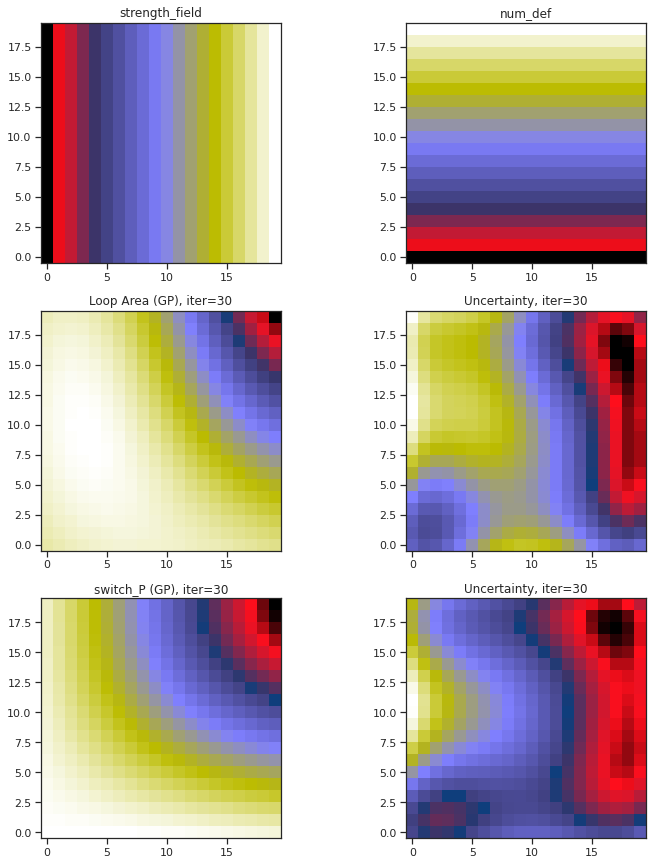

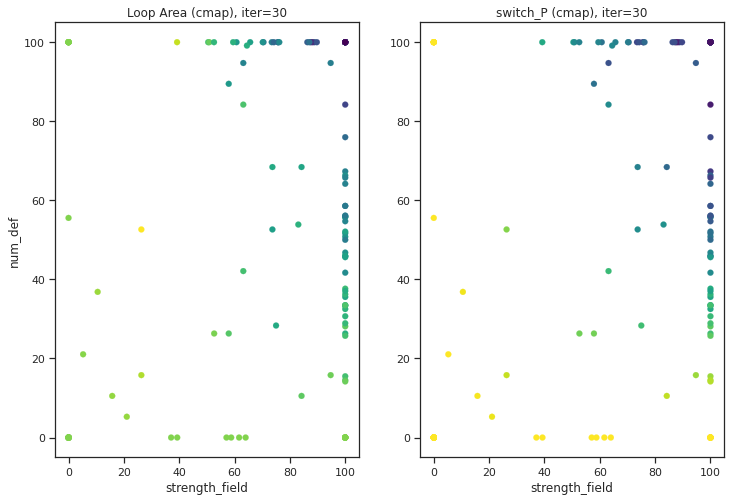

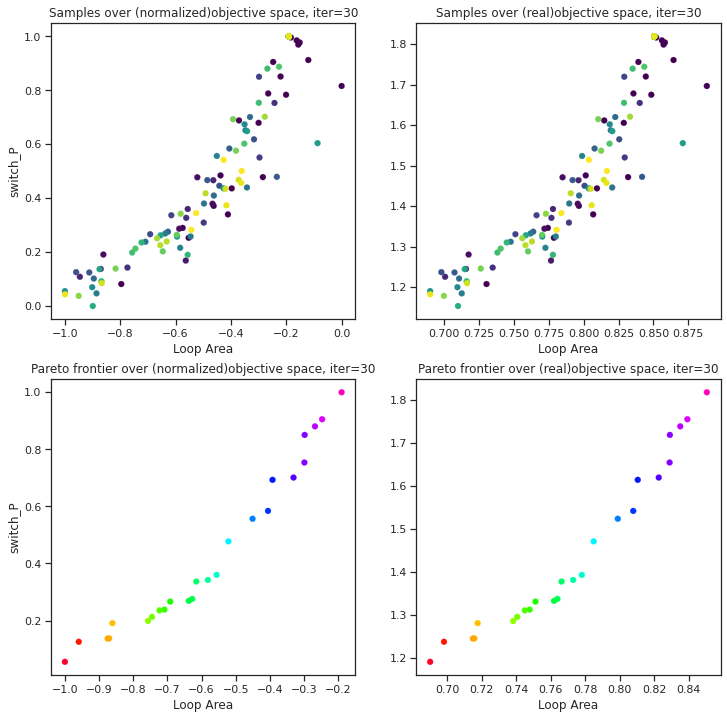

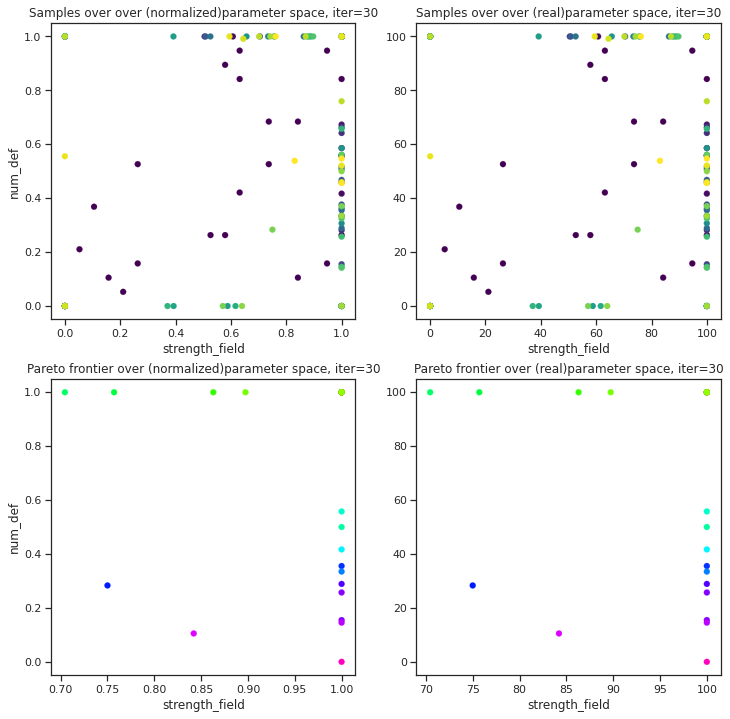

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #69
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


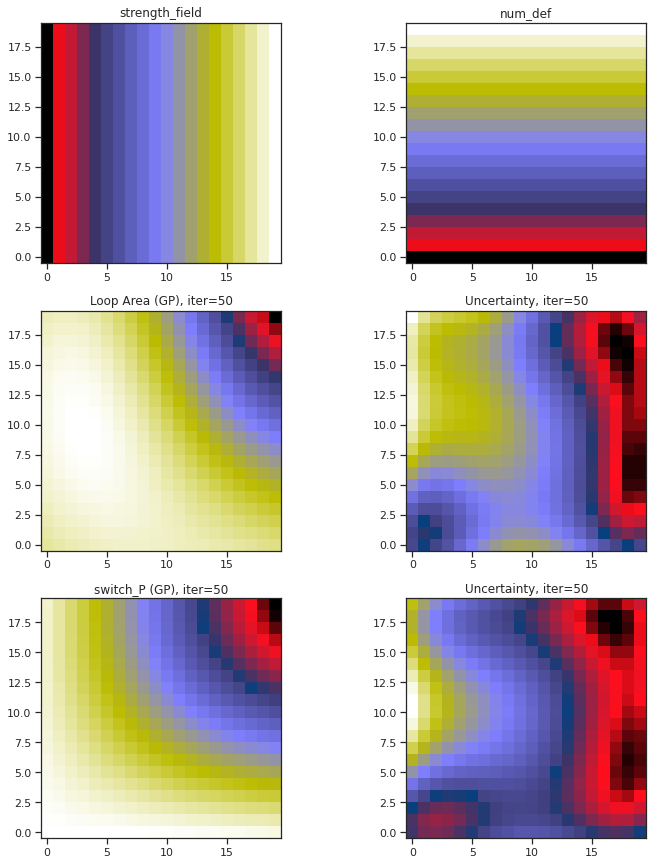

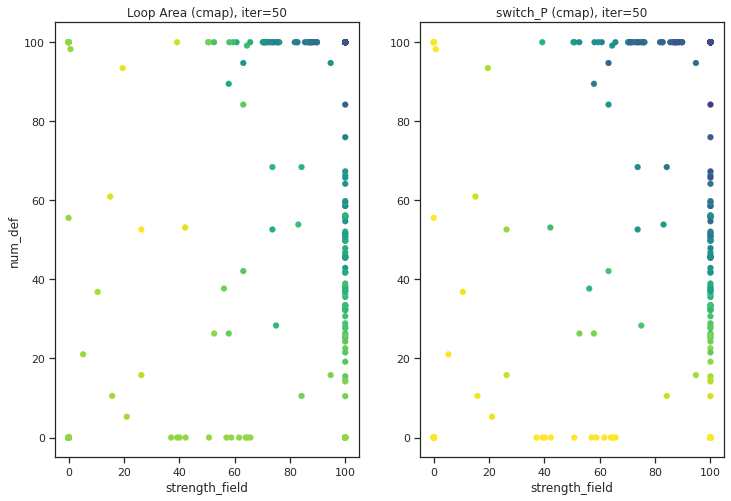

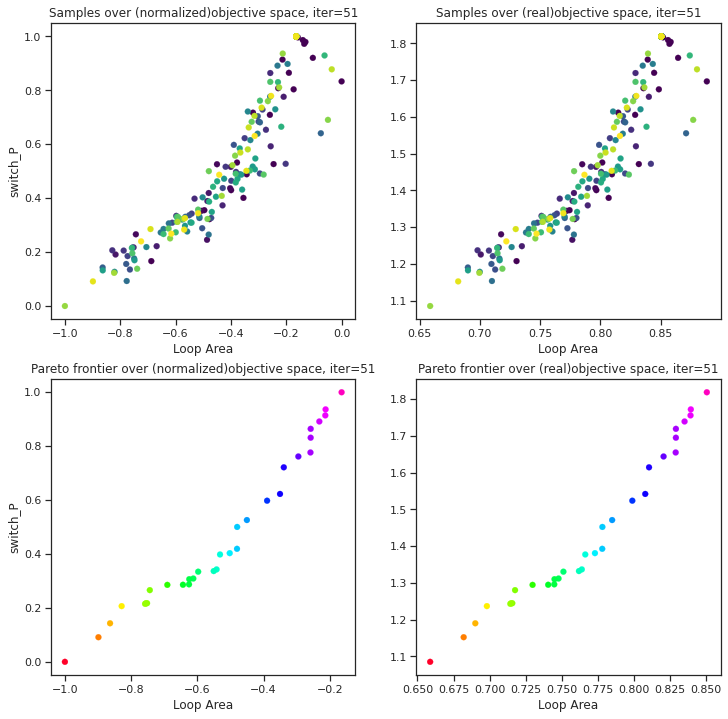

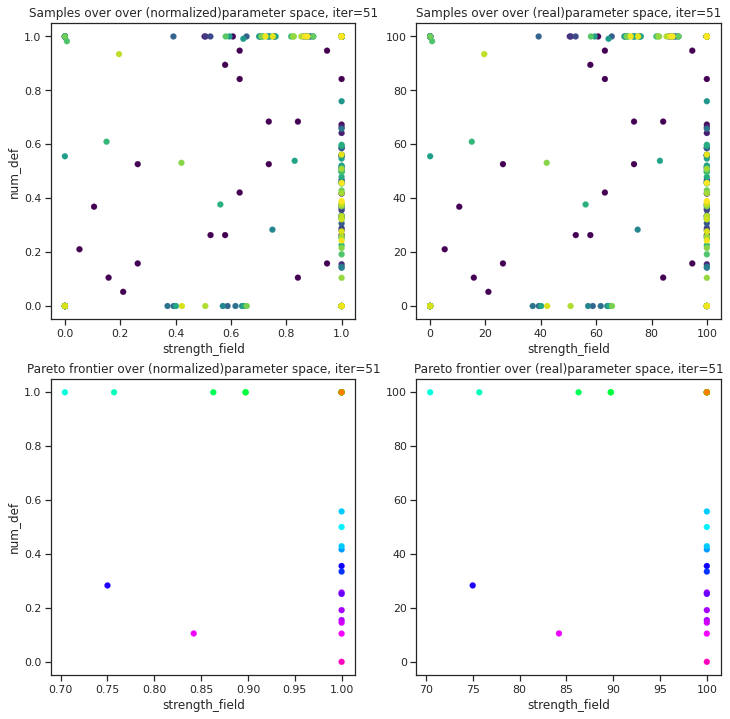

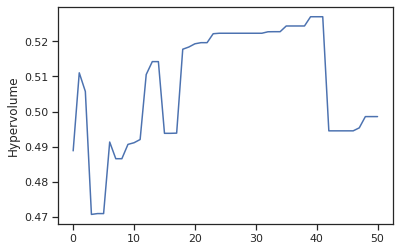

tensor(0.0100, dtype=torch.float64)
tensor(0.0011, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      11 |       2 |            - |            -
    2 |      22 |       3 |  0.220395483 |            f
    3 |      33 |       5 |  0.137822809 |        ideal
    4 |      44 |      11 |  0.269755369 |        ideal
    5 |      55 |      11 |  0.050271806 |        nadir
    6 |      66 |      11 |  0.037417343 |            f
    7 |      77 |      11 |  0.035131426 |        ideal
    8 |      88 |      11 |  0.070514604 |        ideal
    9 |      99 |      11 |  0.020804942 |            f
   10 |     110 |      11 |  0.028643322 |        ideal
   11 |     121 |      11 |  0.019408022 |        ideal
   12 |     132 |      11 |  0.016743199 |            f
   13 |     143 |      11 |  0.048920666 |        ideal
   14 |     154 |      11 |  0.017701496 |            f
   15 |     165 |      11 |  5.48866E-08 |  

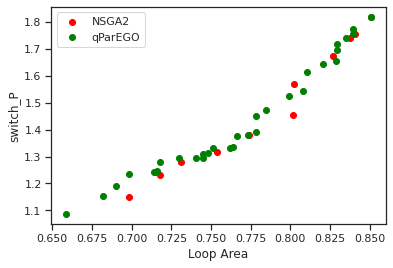

In [10]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qParEGO'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'strength_field'
param2 = 'num_def'
# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'switch_P'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def



MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


With qEIHV

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


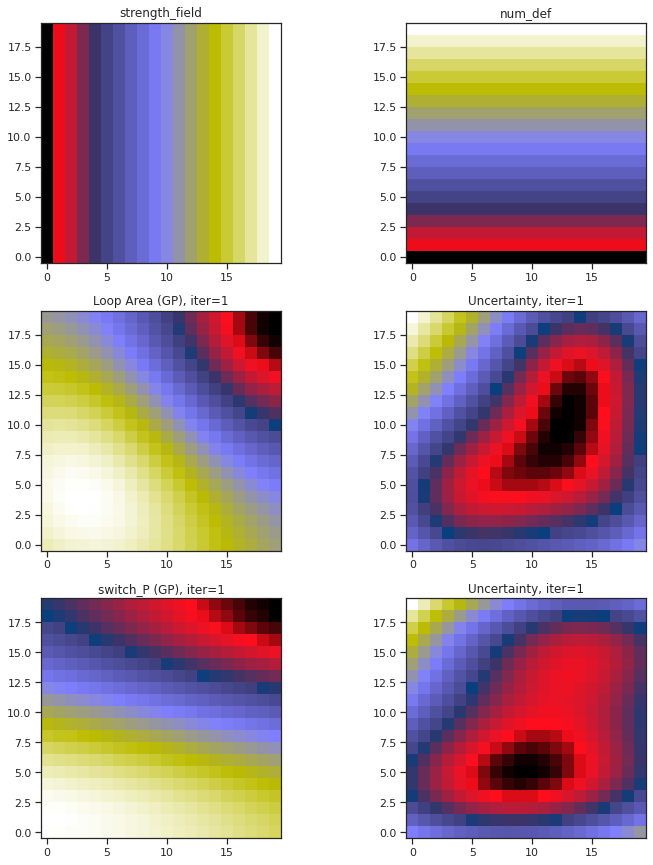

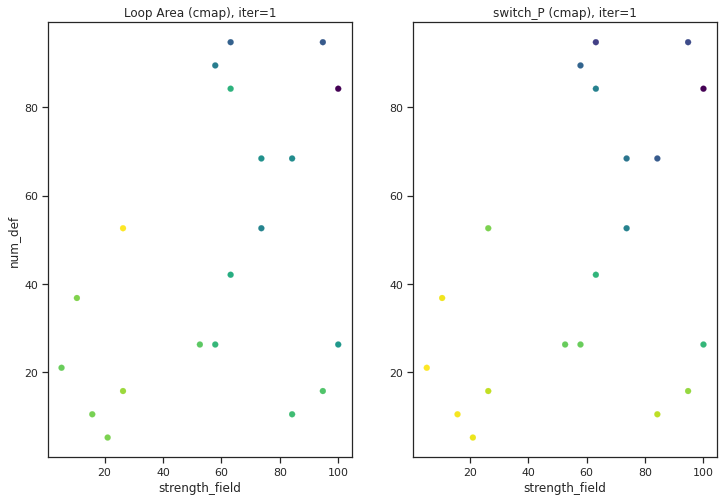

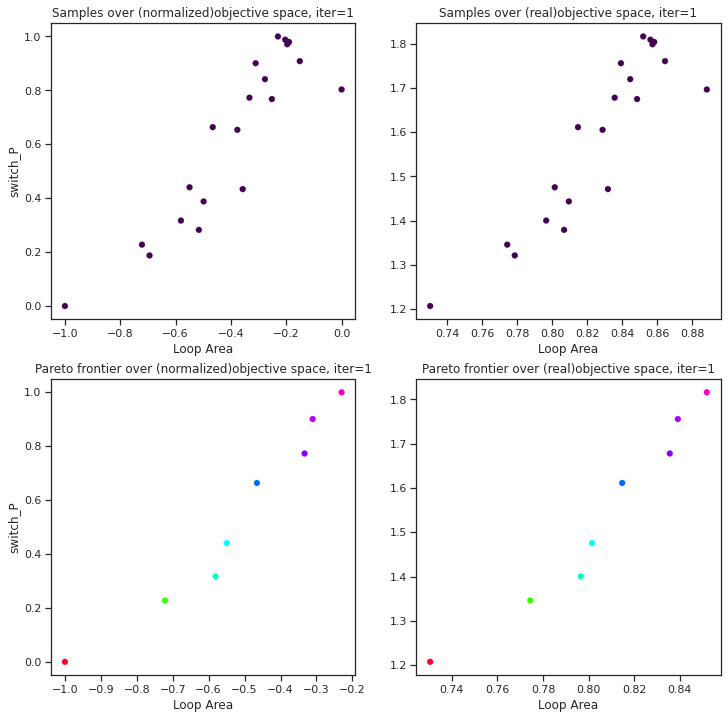

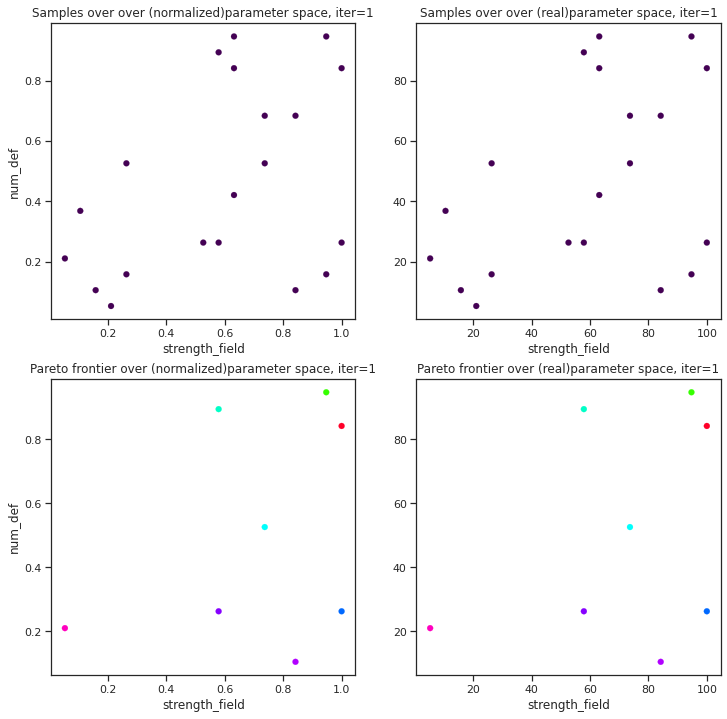

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


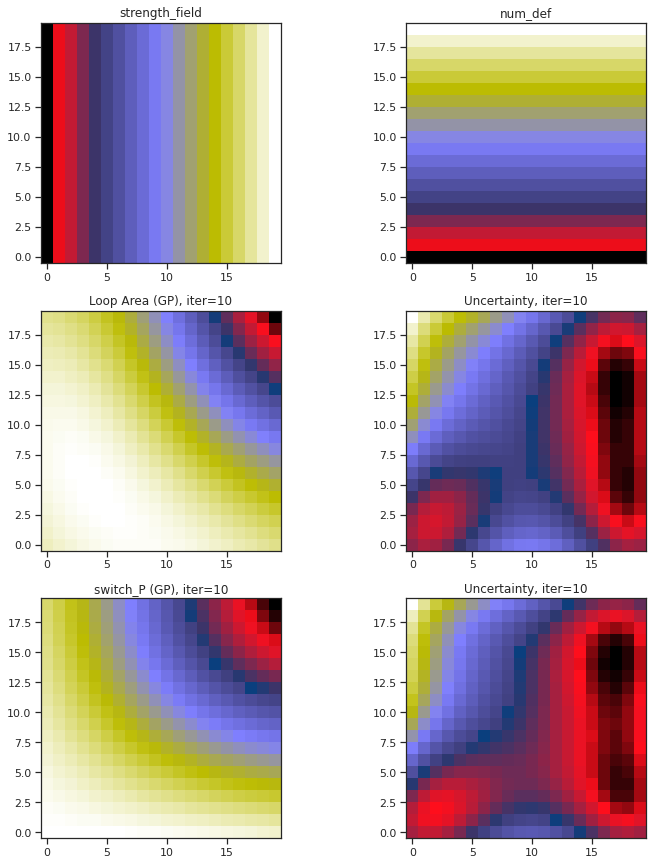

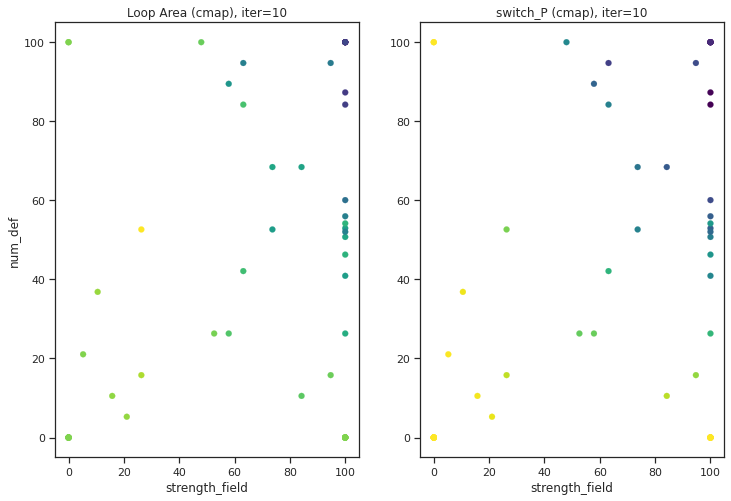

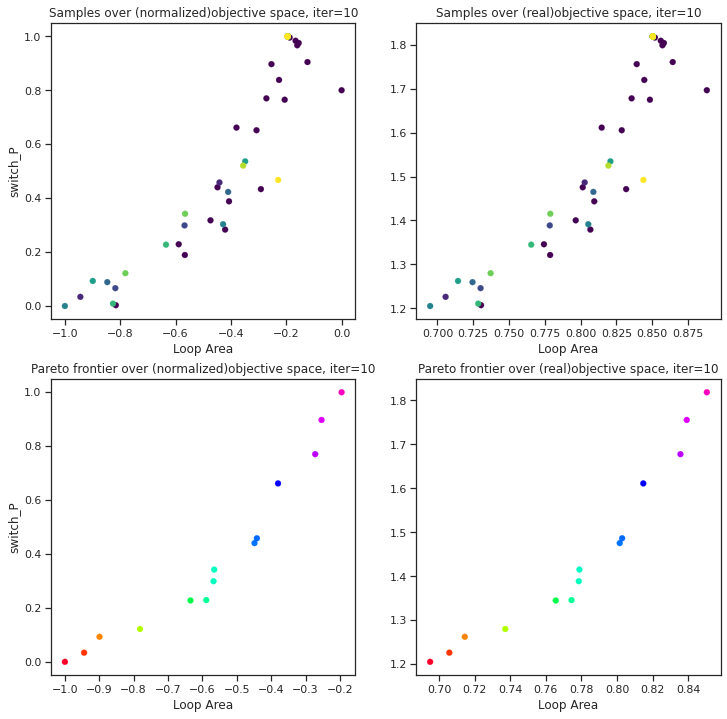

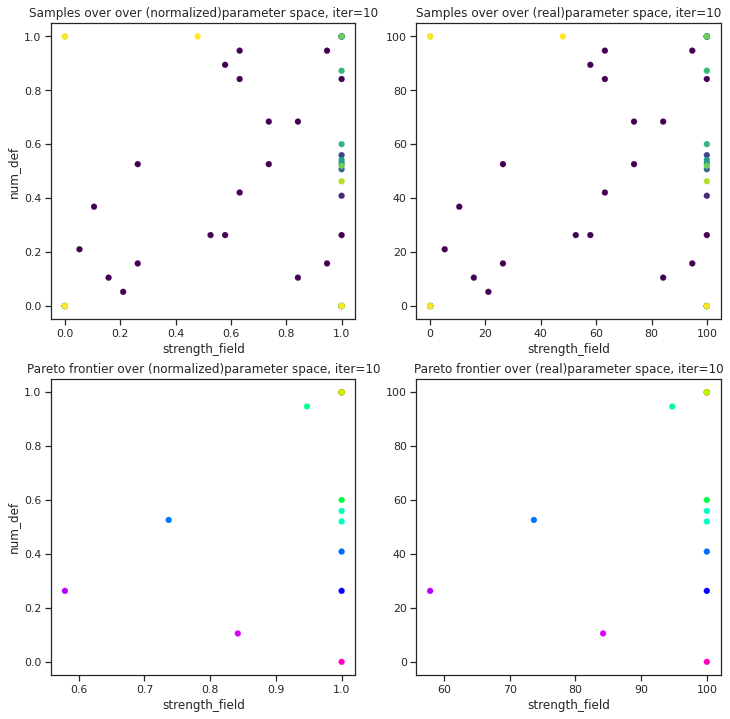

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


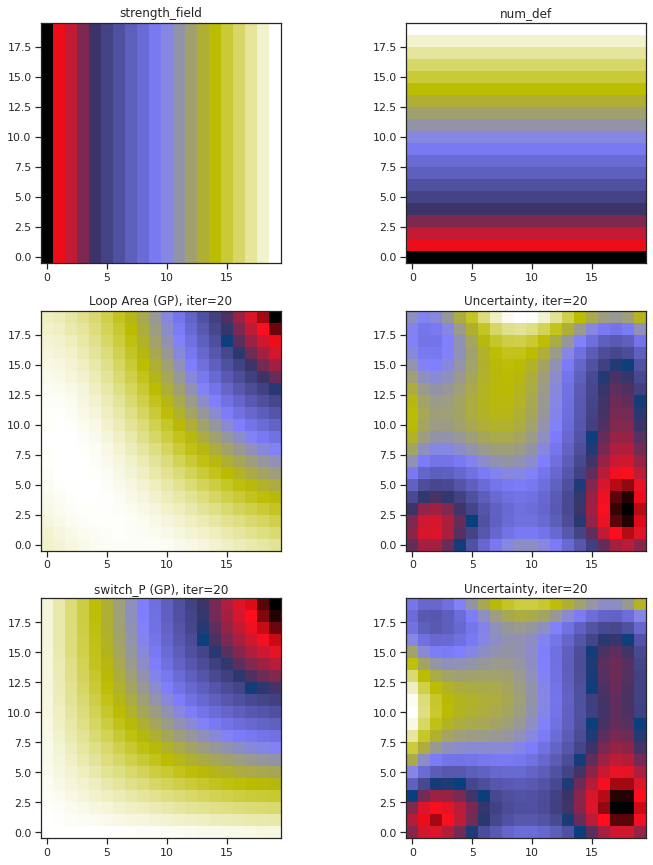

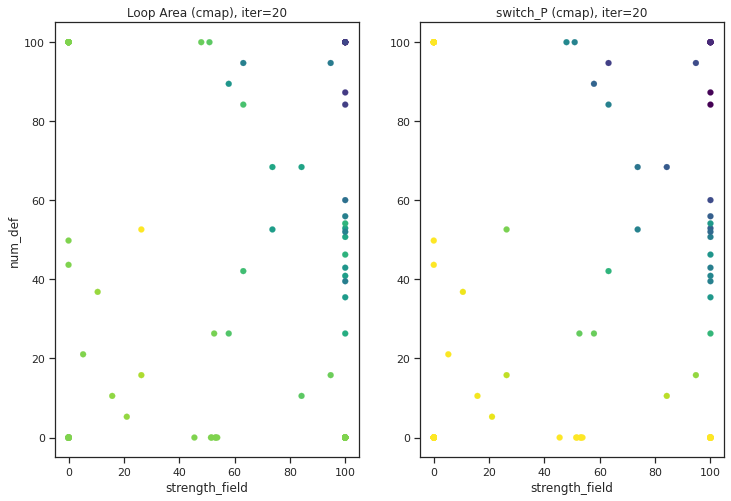

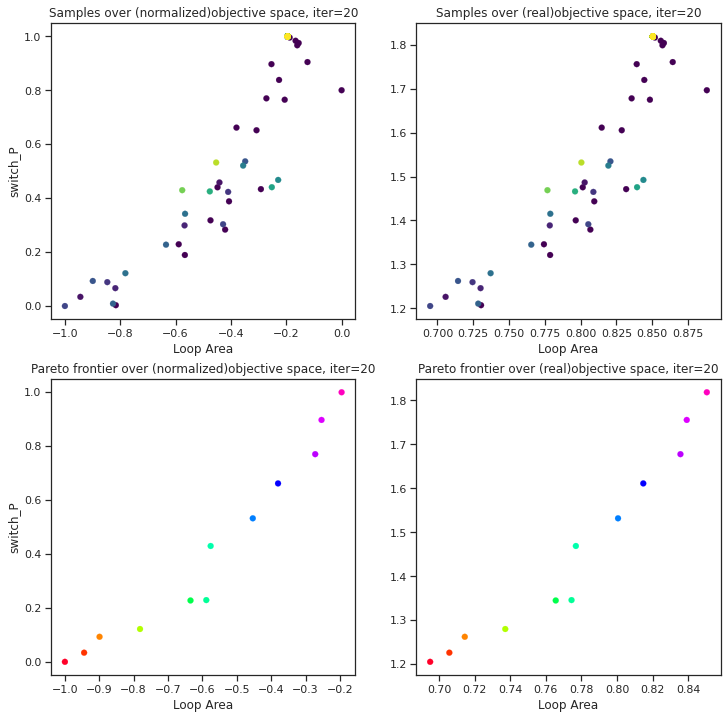

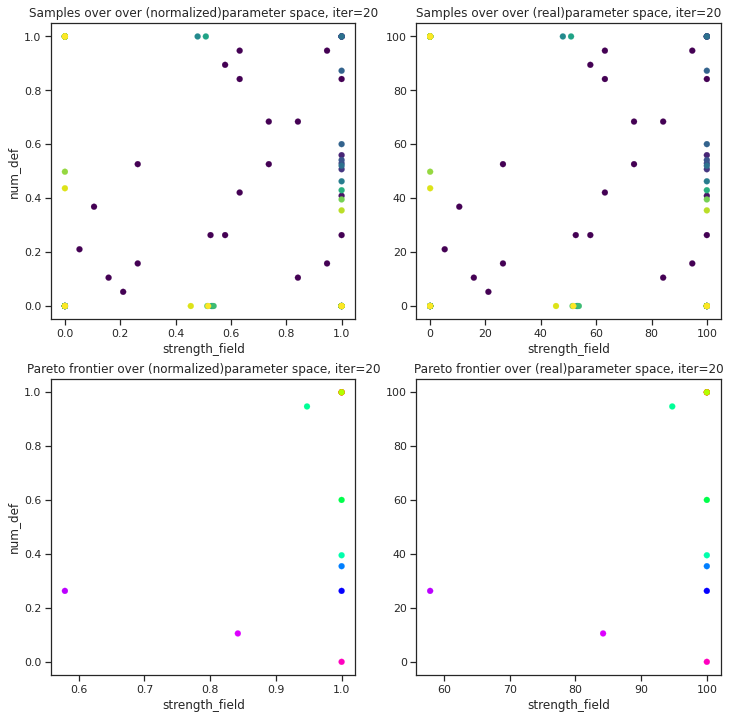

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


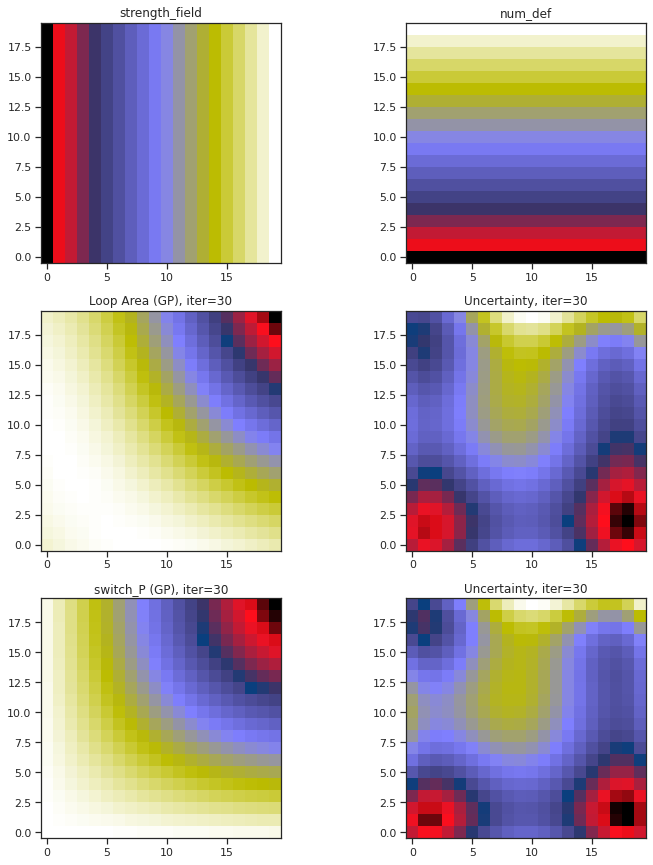

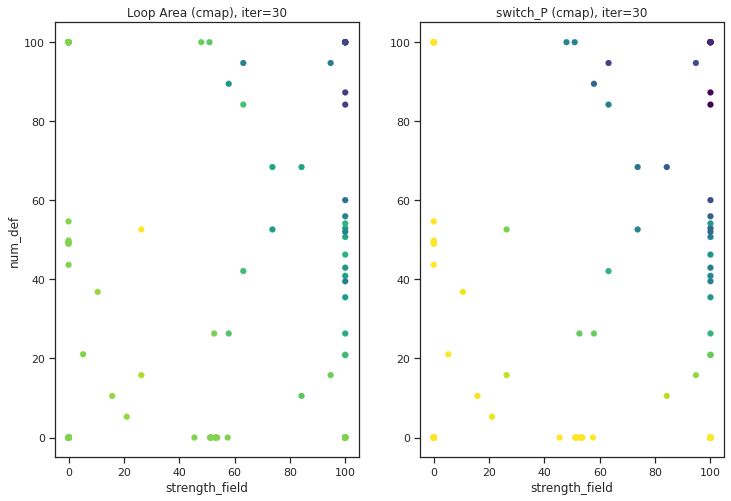

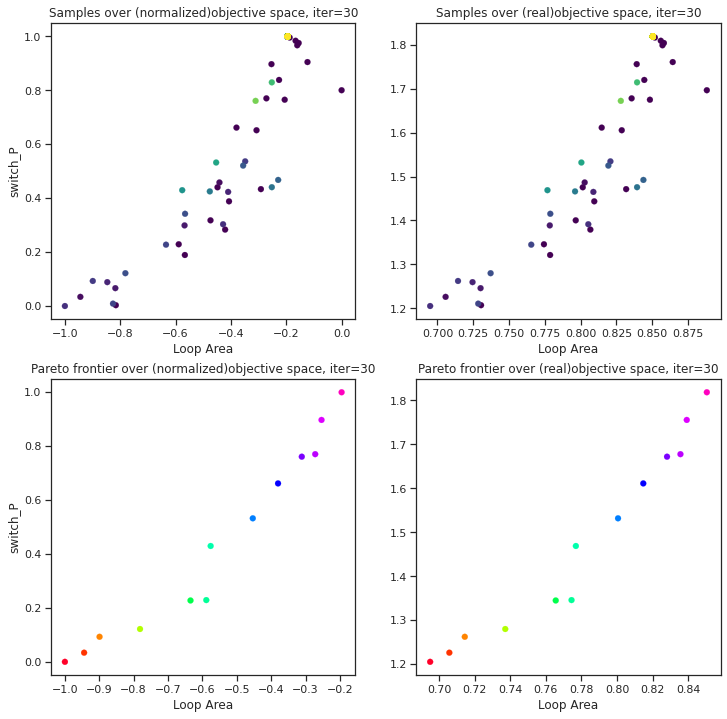

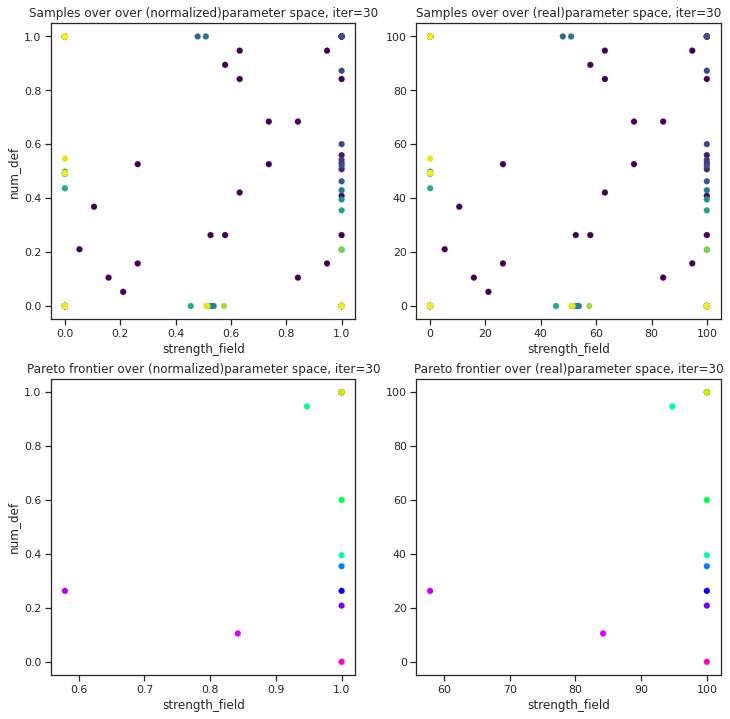

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


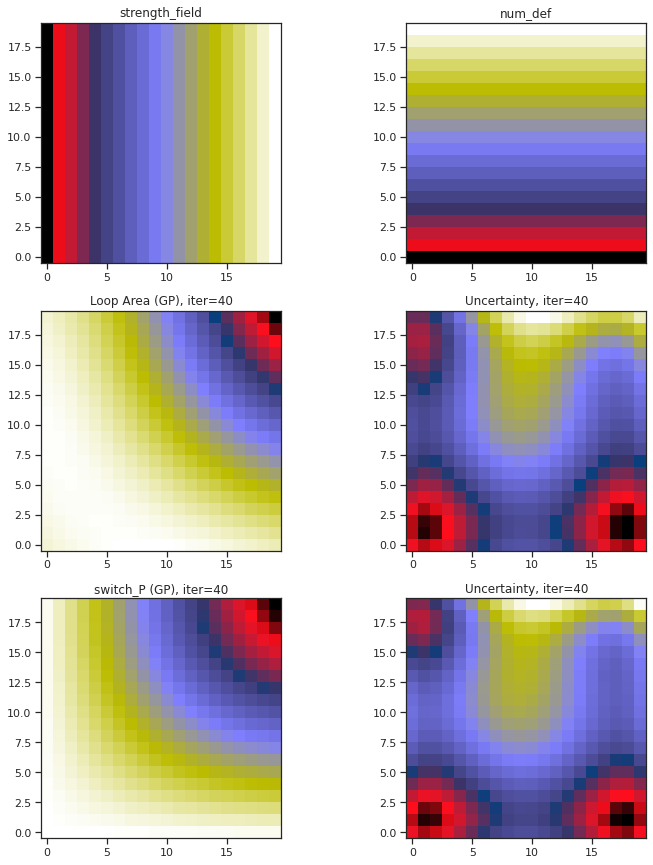

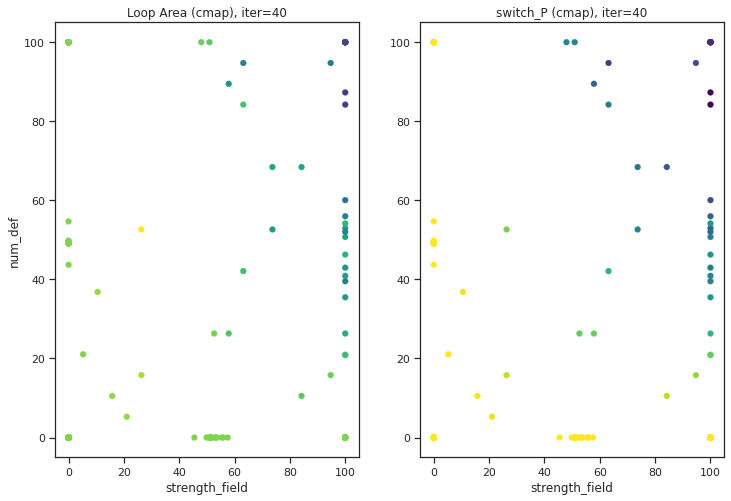

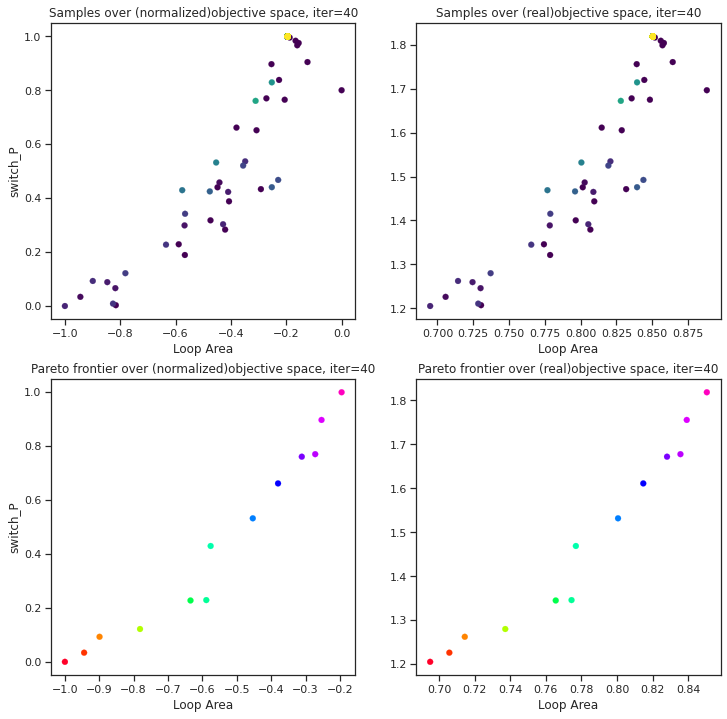

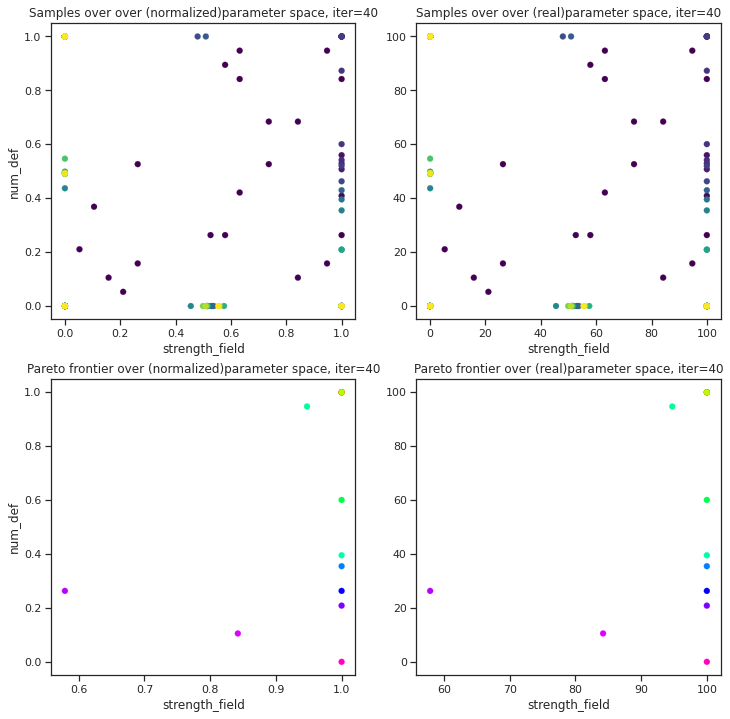

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #69
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


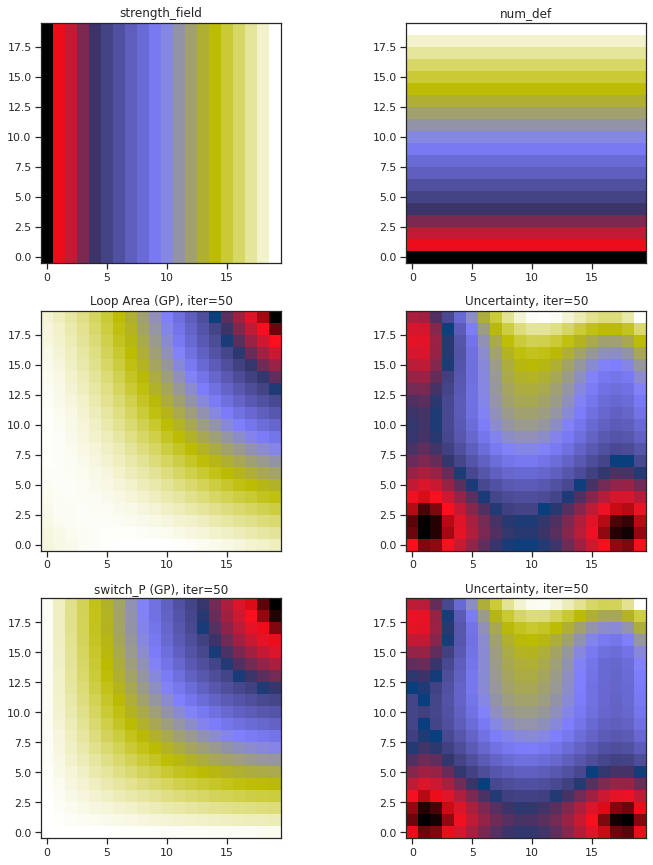

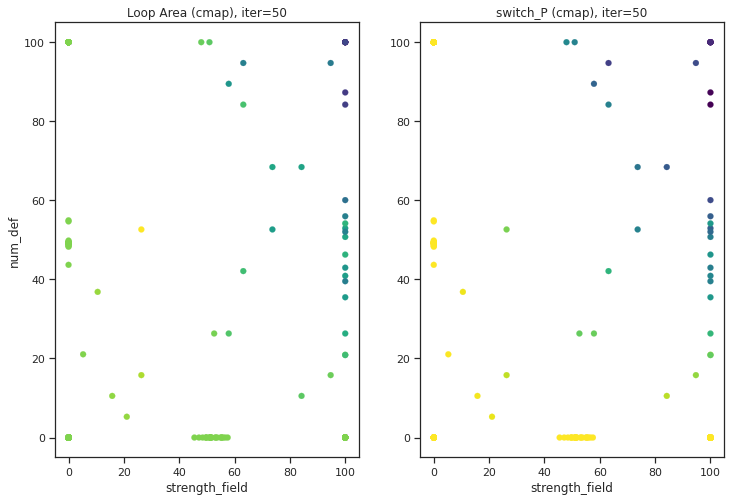

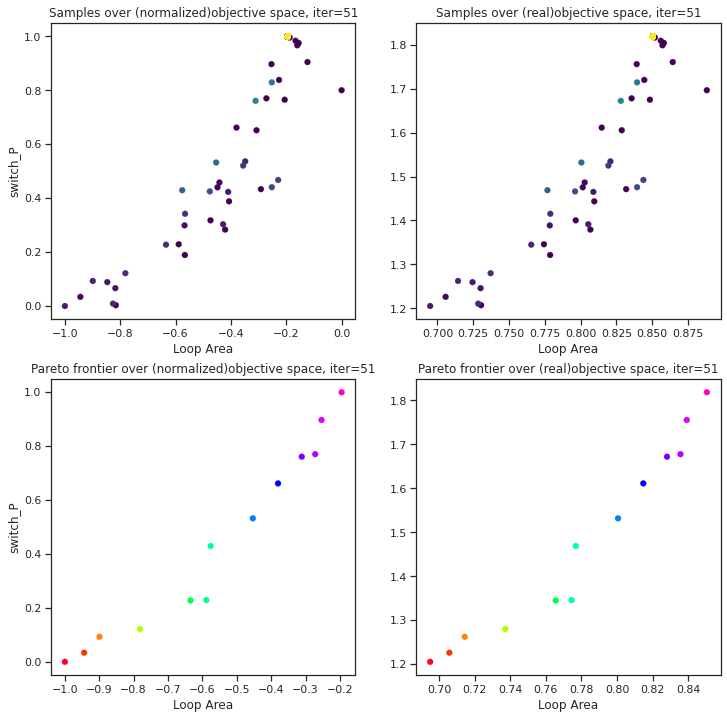

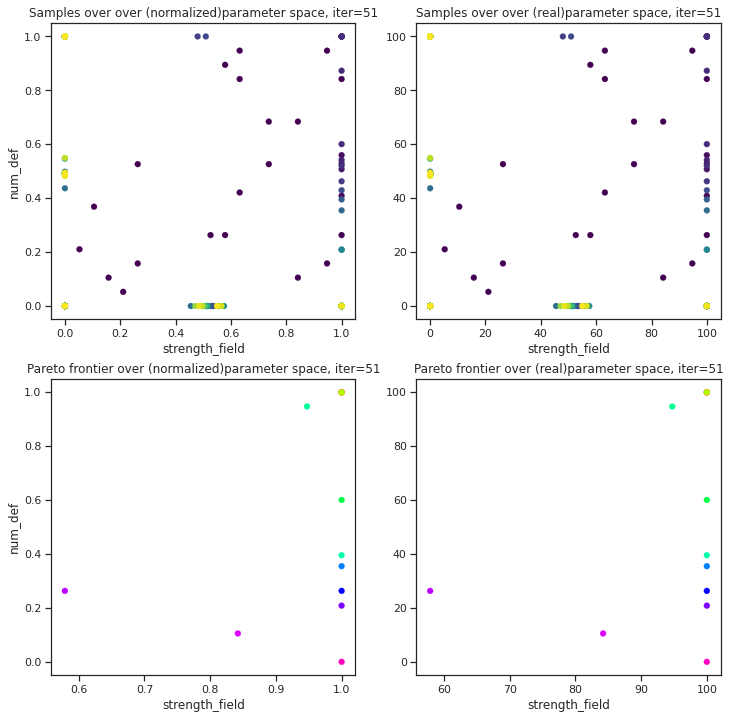

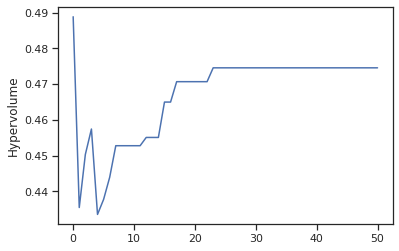

tensor(0.0391, dtype=torch.float64)
tensor(0.0108, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      11 |       2 |            - |            -
    2 |      22 |       3 |  0.220395483 |            f
    3 |      33 |       5 |  0.137822809 |        ideal
    4 |      44 |      11 |  0.269755369 |        ideal
    5 |      55 |      11 |  0.050271806 |        nadir
    6 |      66 |      11 |  0.037417343 |            f
    7 |      77 |      11 |  0.035131426 |        ideal
    8 |      88 |      11 |  0.070514604 |        ideal
    9 |      99 |      11 |  0.020804942 |            f
   10 |     110 |      11 |  0.028643322 |        ideal
   11 |     121 |      11 |  0.019408022 |        ideal
   12 |     132 |      11 |  0.016743199 |            f
   13 |     143 |      11 |  0.048920666 |        ideal
   14 |     154 |      11 |  0.017701496 |            f
   15 |     165 |      11 |  5.48866E-08 |  

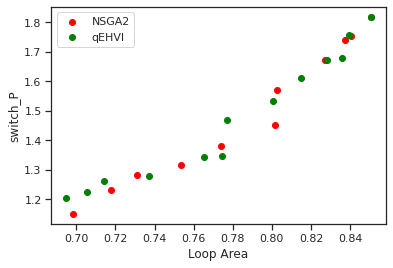

In [11]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qEHVI'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'strength_field'
param2 = 'num_def'
# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'switch_P'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def



MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


<h1>Analysis 2b

**Minimize Loop Area and Maximize User Set target of a Swichable Polarization** 

$P_0 = 1.50$, $\delta_P =.075$

With qParEGO

Run MOBO - this will take a while to run...

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qParEGO


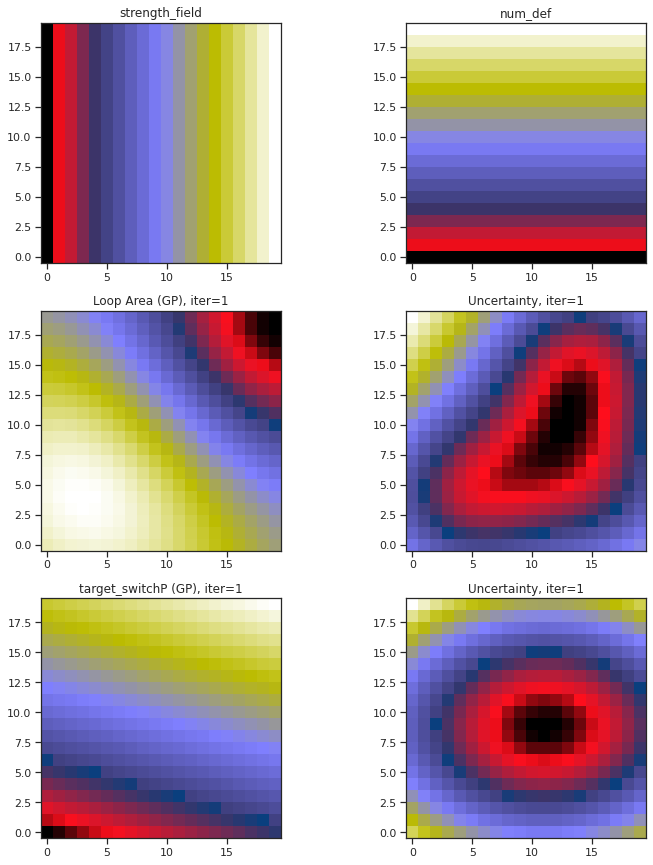

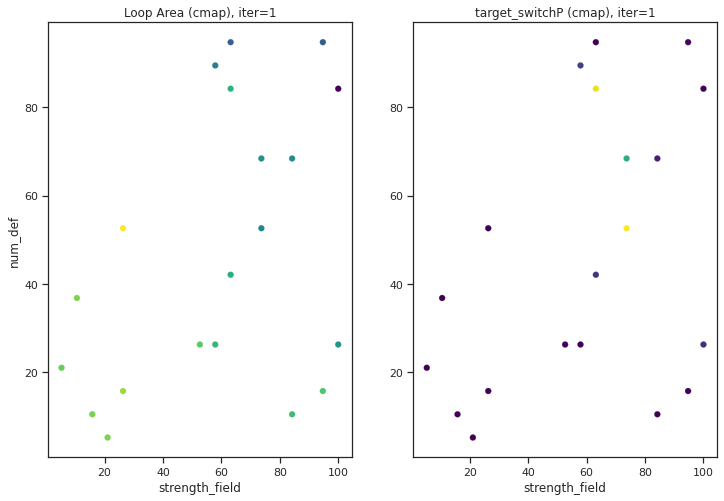

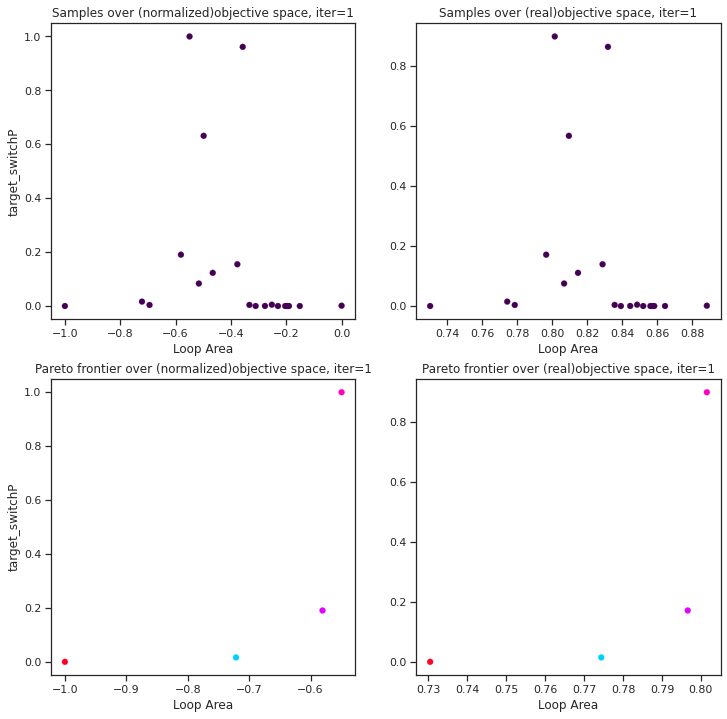

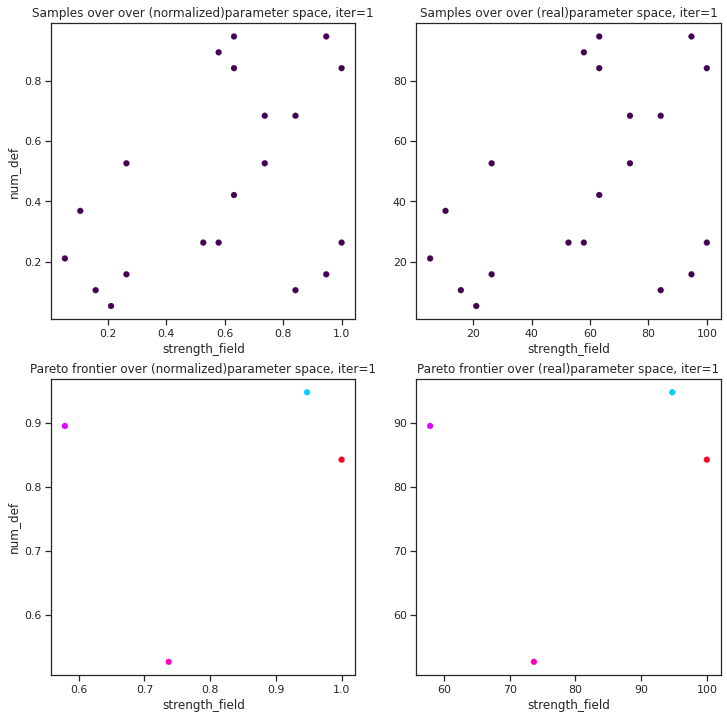

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


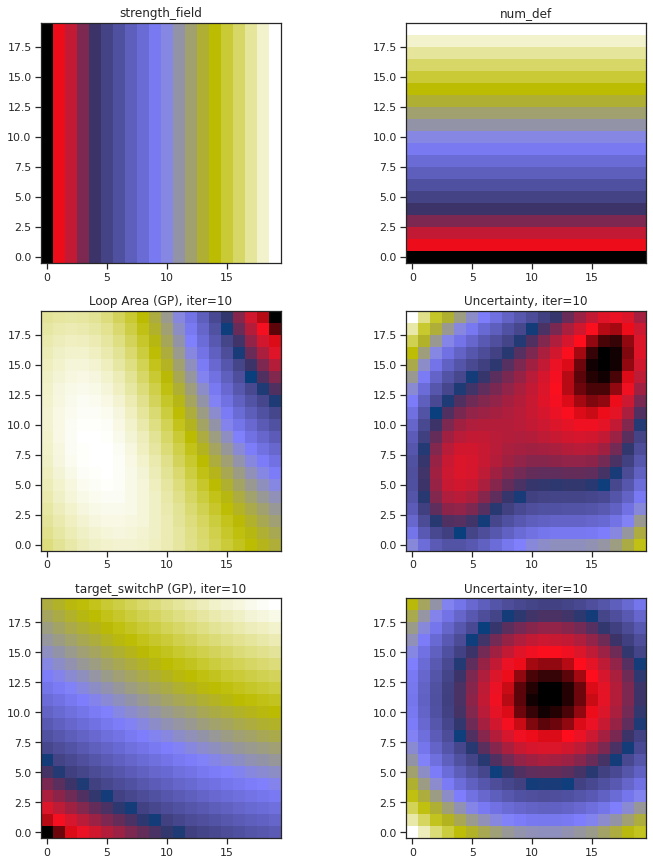

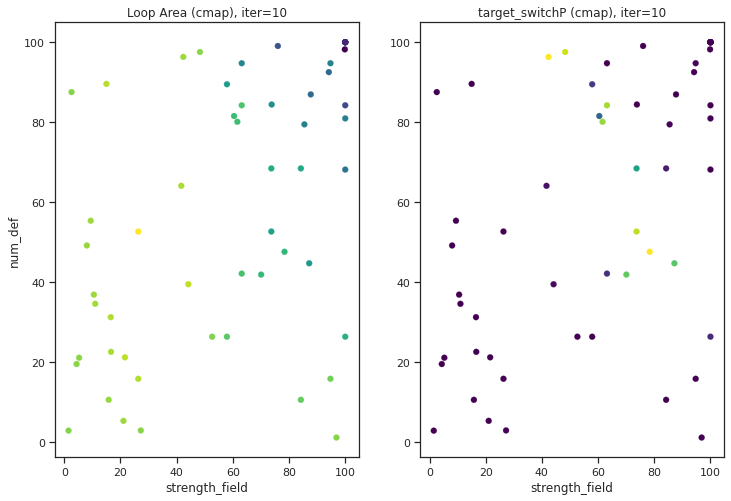

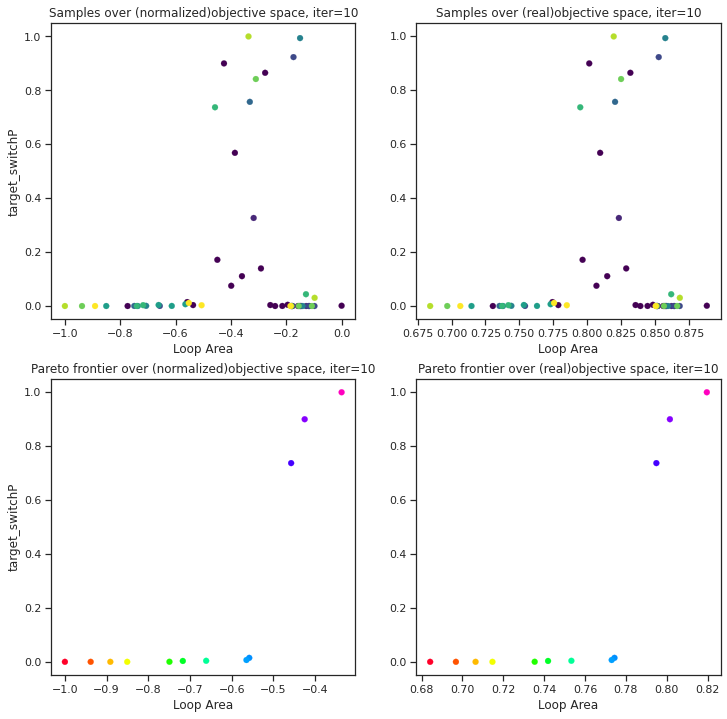

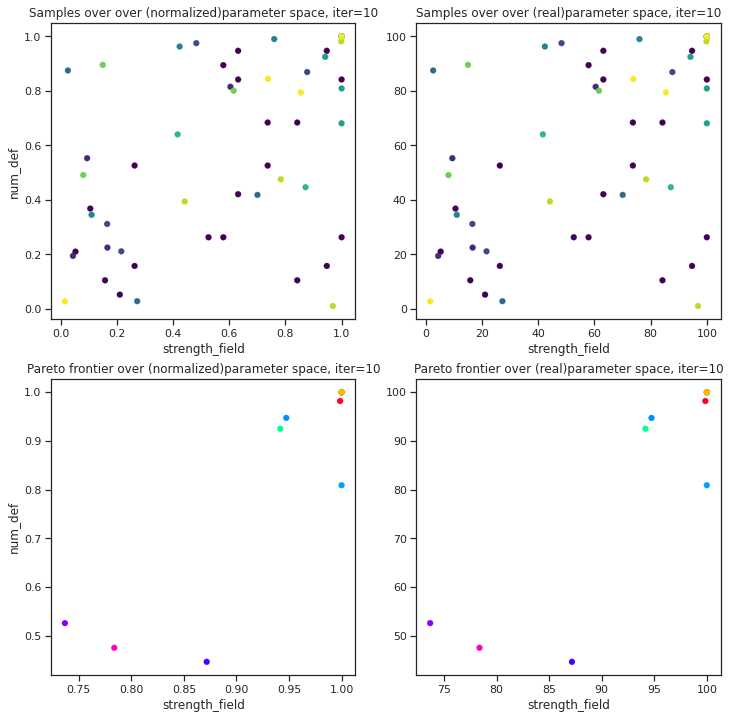

Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

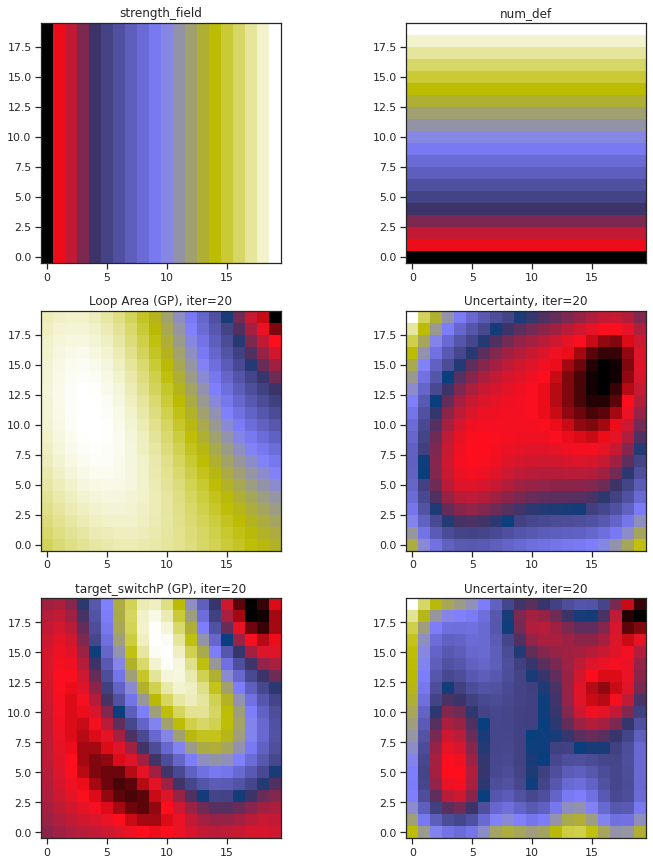

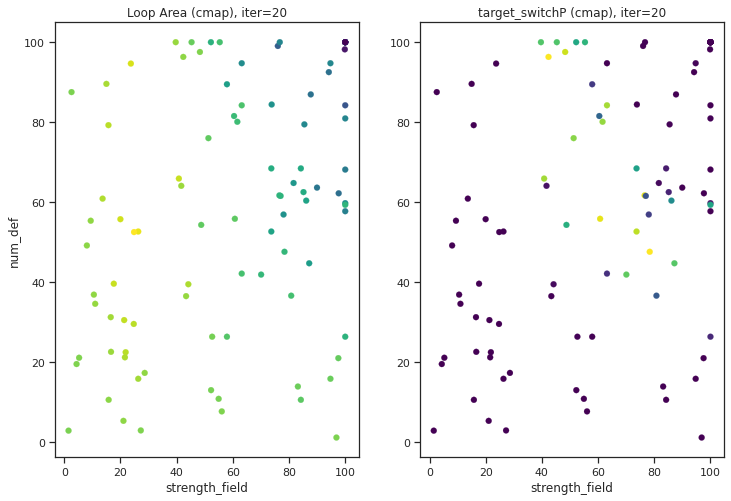

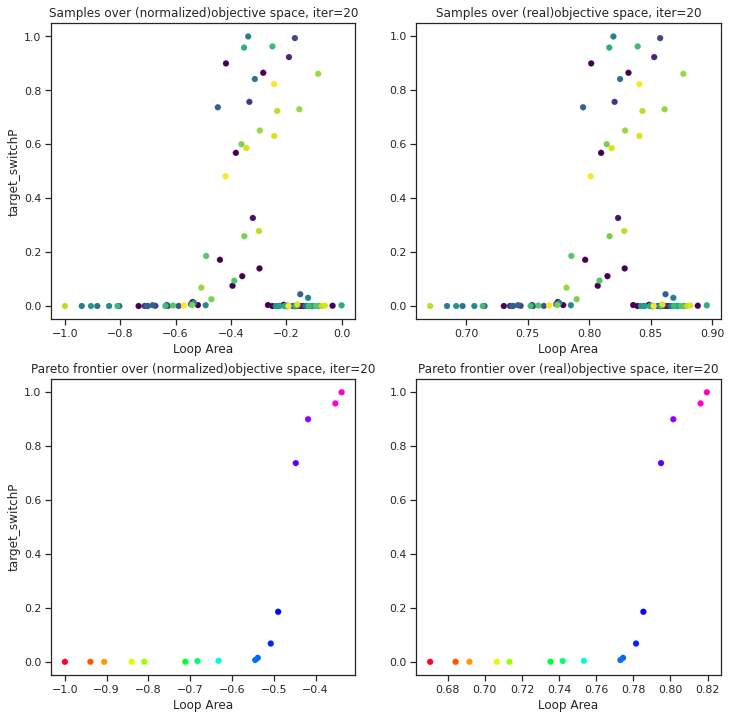

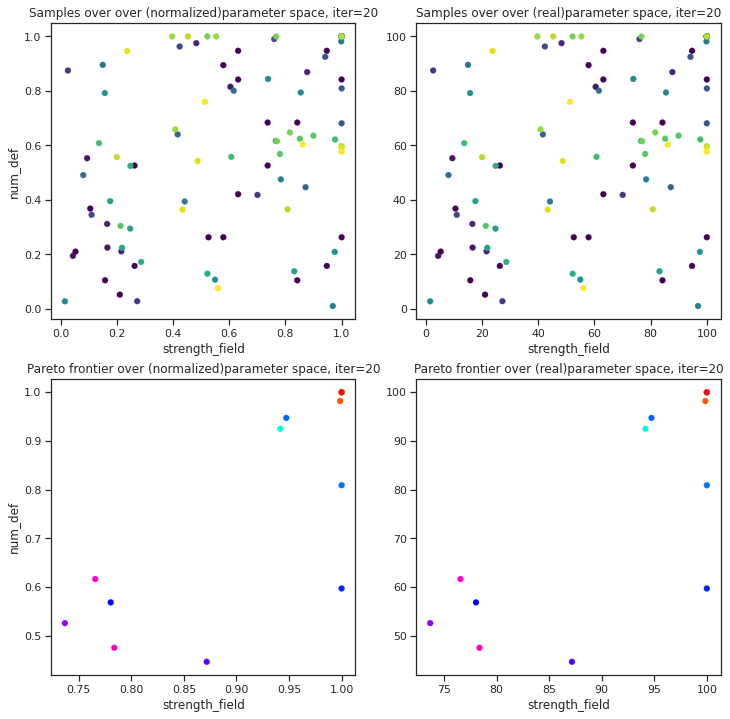

Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

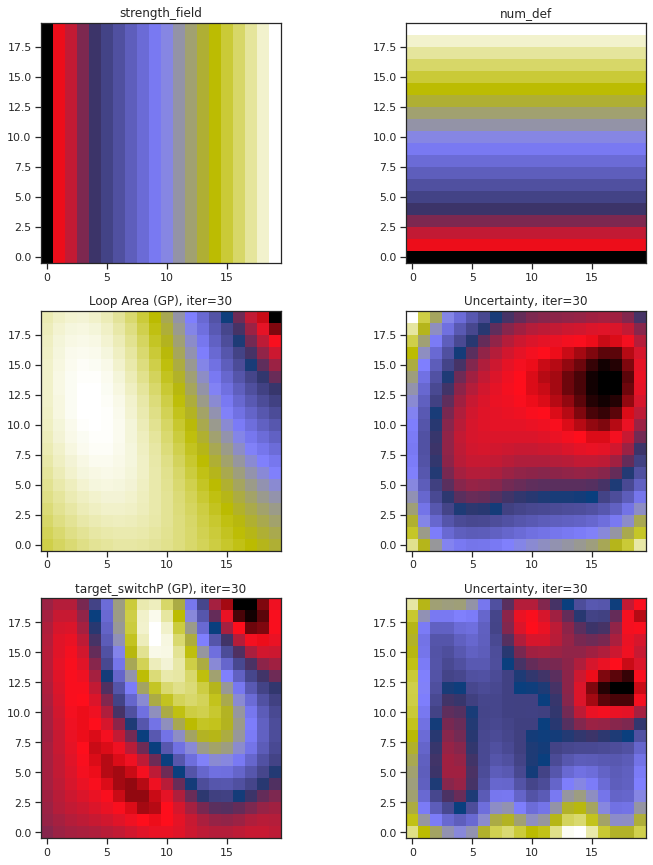

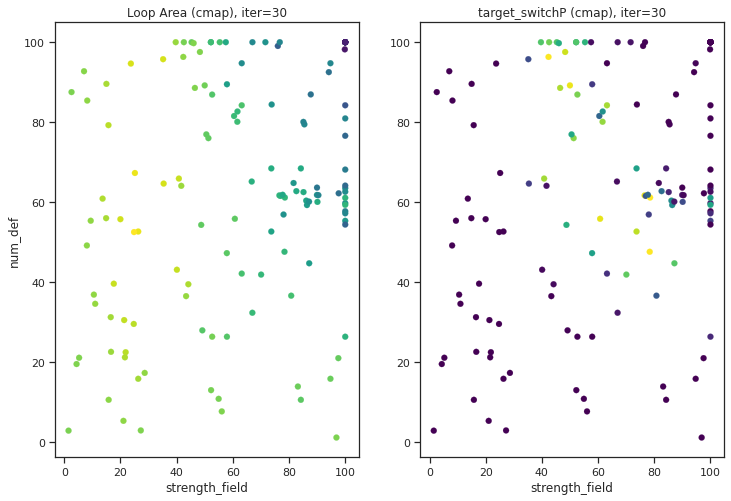

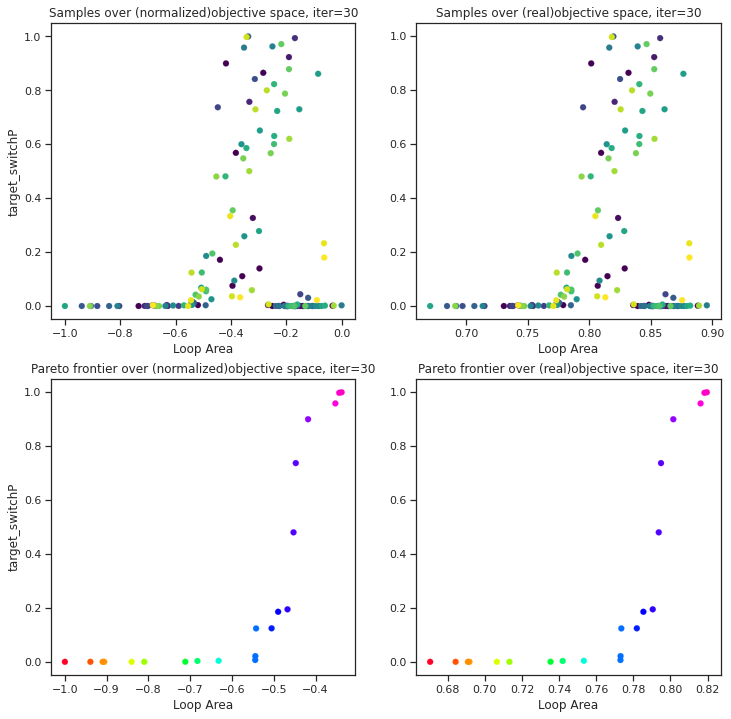

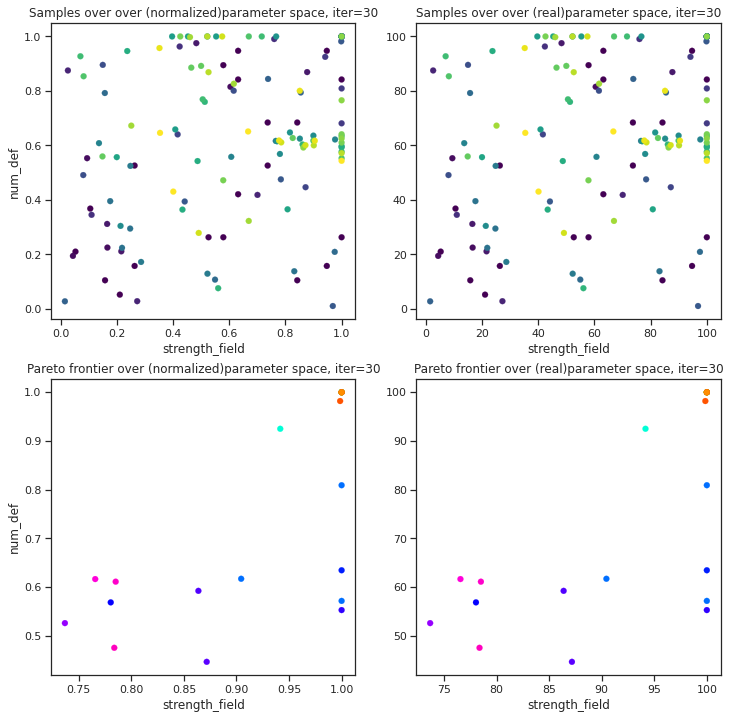

Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #56
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #57
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #58
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #59
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


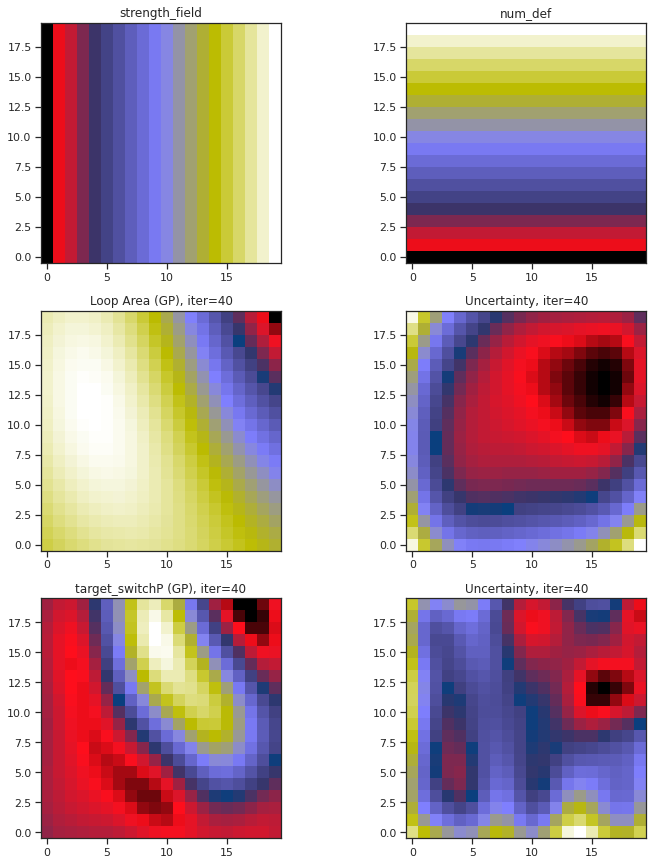

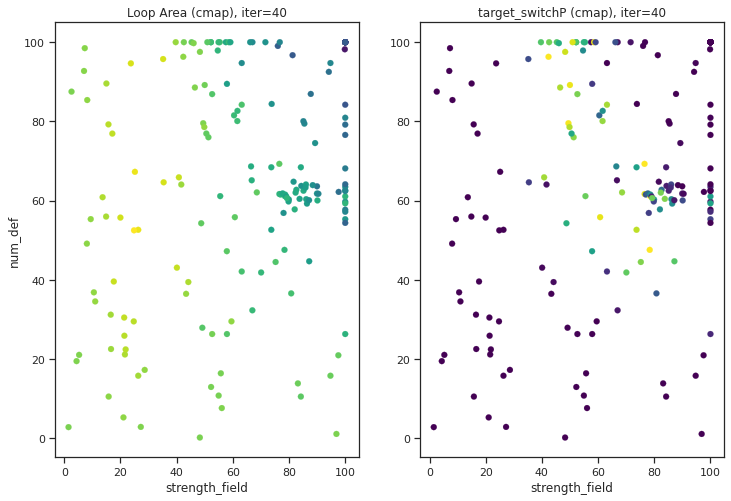

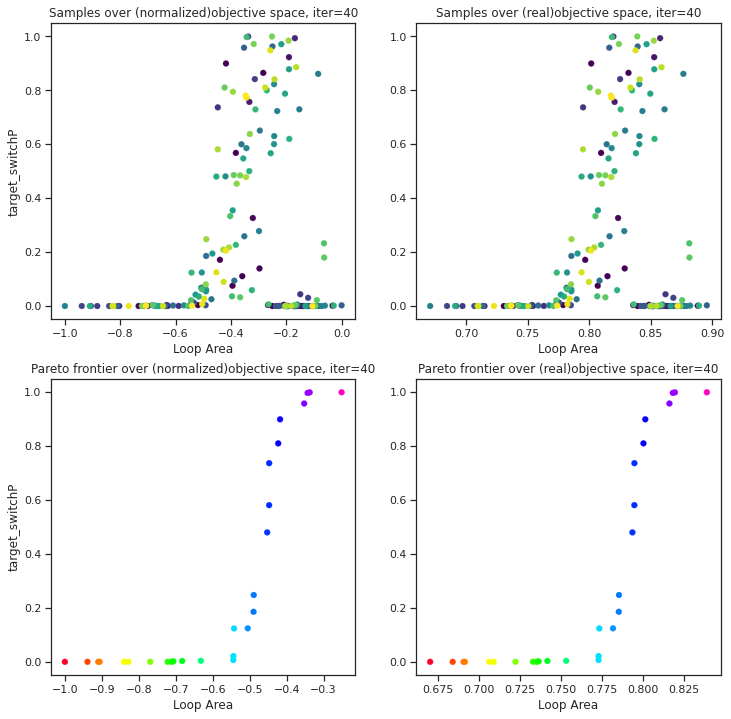

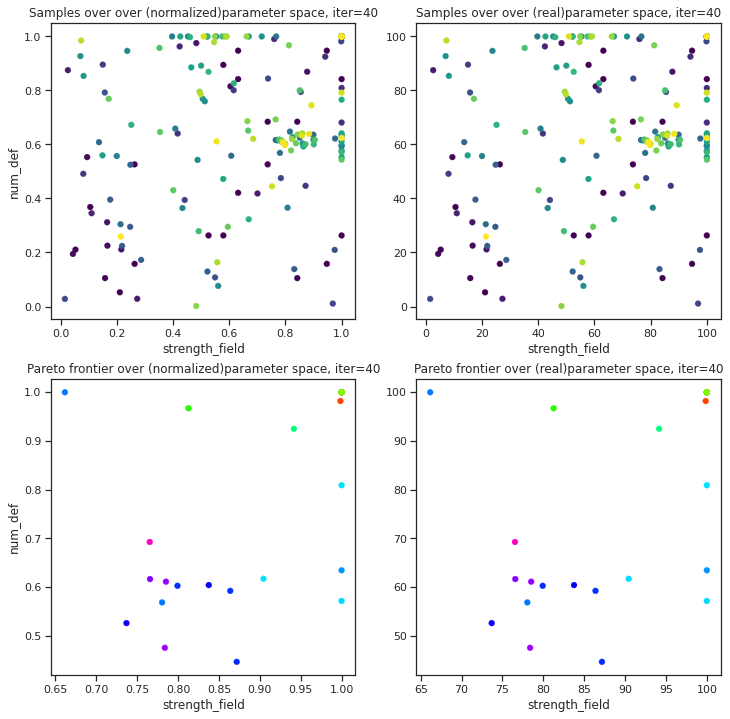

Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


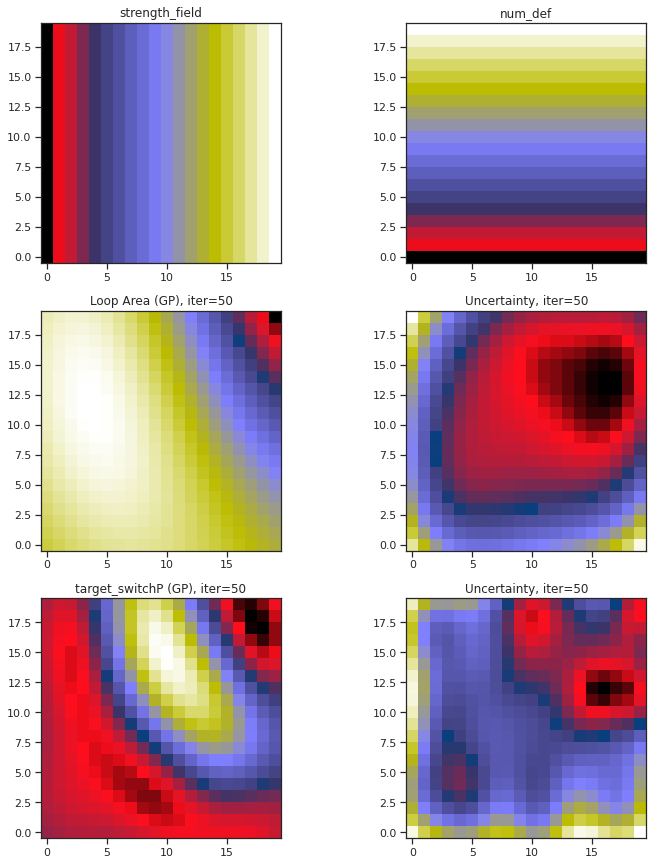

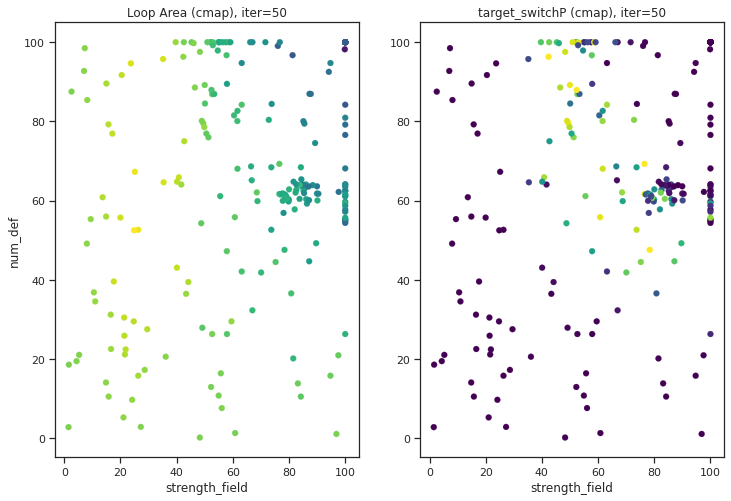

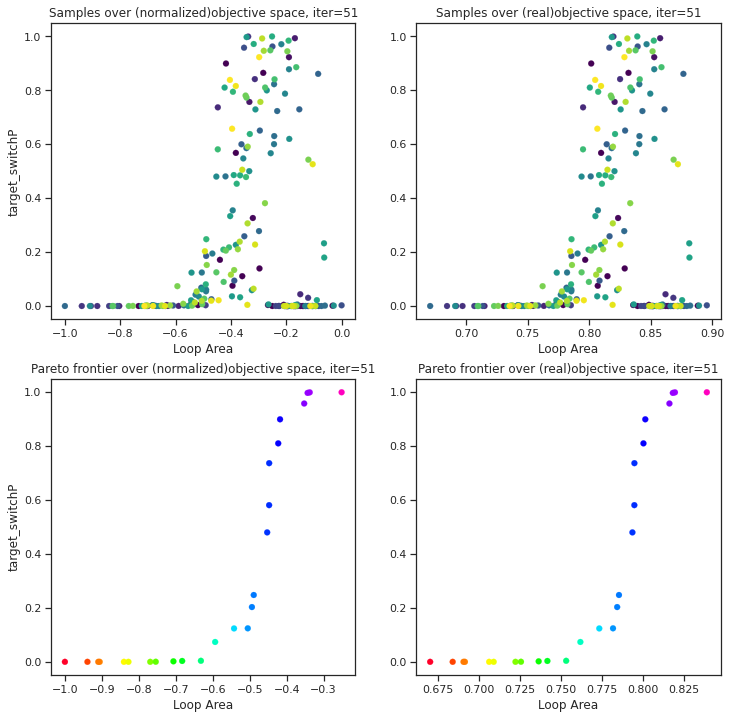

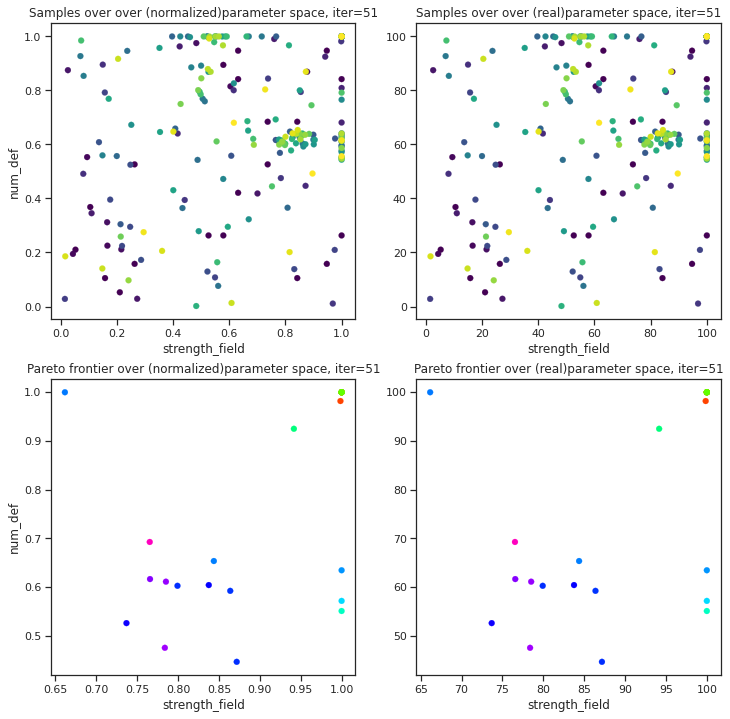

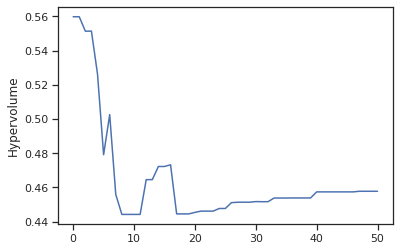

tensor(0., dtype=torch.float64)
tensor(0.0004, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      11 |       2 |            - |            -
    2 |      22 |       5 |  0.196651934 |        ideal
    3 |      33 |       8 |  0.058701042 |            f
    4 |      44 |      11 |  0.104872646 |        ideal
    5 |      55 |      11 |  0.020150028 |        ideal
    6 |      66 |      11 |  0.010461790 |        ideal
    7 |      77 |      11 |  0.089185305 |        ideal
    8 |      88 |      11 |  0.015492657 |            f
    9 |      99 |      11 |  0.037692319 |            f
   10 |     110 |      11 |  0.010600083 |            f
   11 |     121 |      11 |  0.183275281 |        ideal
   12 |     132 |      11 |  0.004242419 |            f
   13 |     143 |      11 |  0.008333255 |            f
   14 |     154 |      11 |  0.127649102 |        nadir
   15 |     165 |      11 |  0.010048163 |      

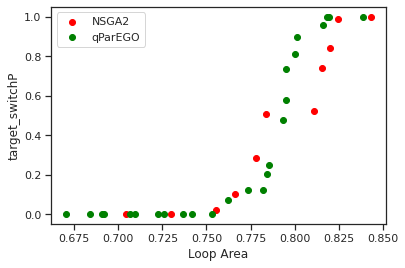

In [10]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qParEGO'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'strength_field'
param2 = 'num_def'
# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'target_switchP'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def



MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


With qEIHV

Function evaluaton for initial randomly selected samples
Function eval #1
Function eval #2
Function eval #3
Function eval #4
Function eval #5
Function eval #6
Function eval #7
Function eval #8
Function eval #9
Function eval #10
Function eval #11
Function eval #12
Function eval #13
Function eval #14
Function eval #15
Function eval #16
Function eval #17
Function eval #18
Function eval #19
Function eval #20
Initial evaluation complete. Start BO- acq func: qEHVI


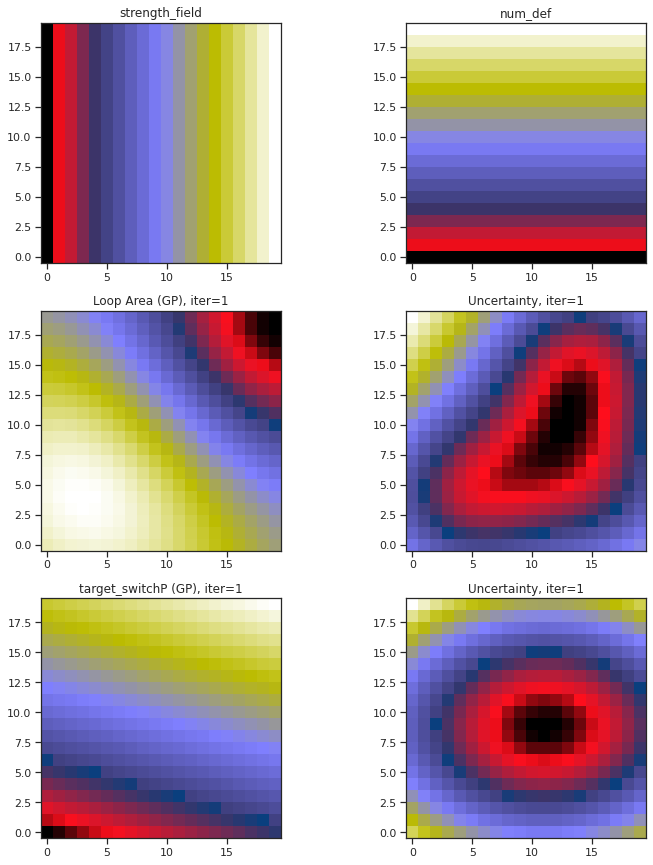

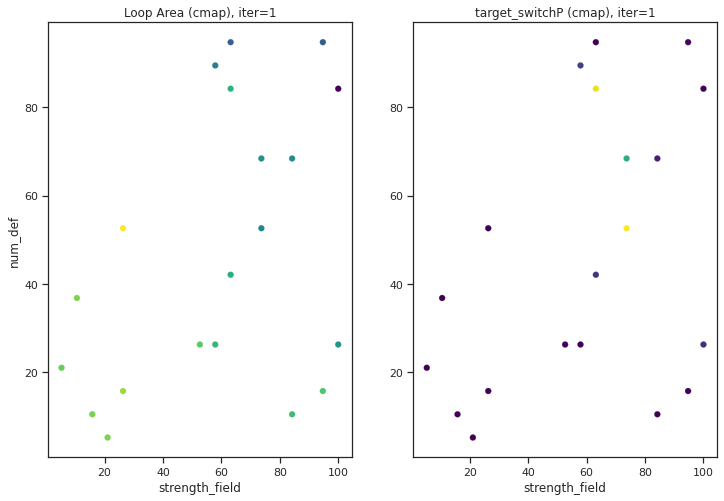

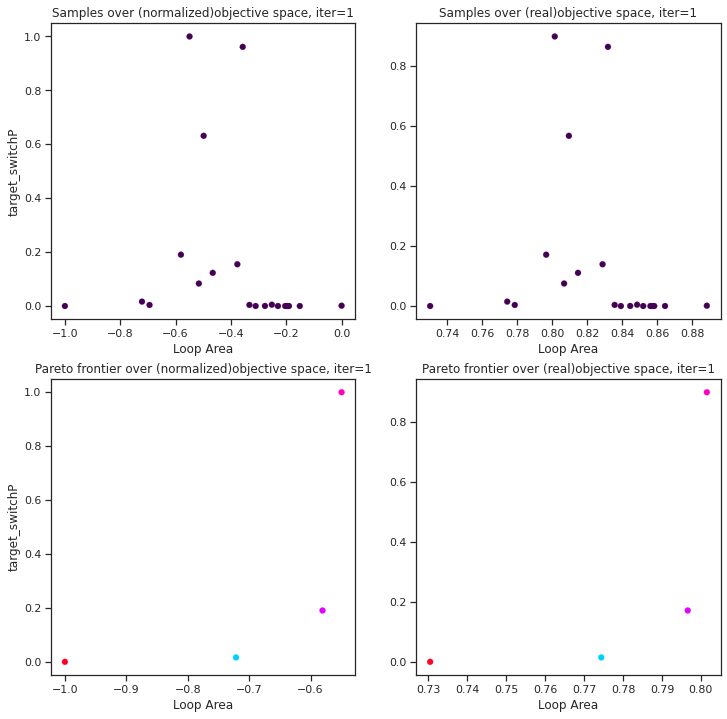

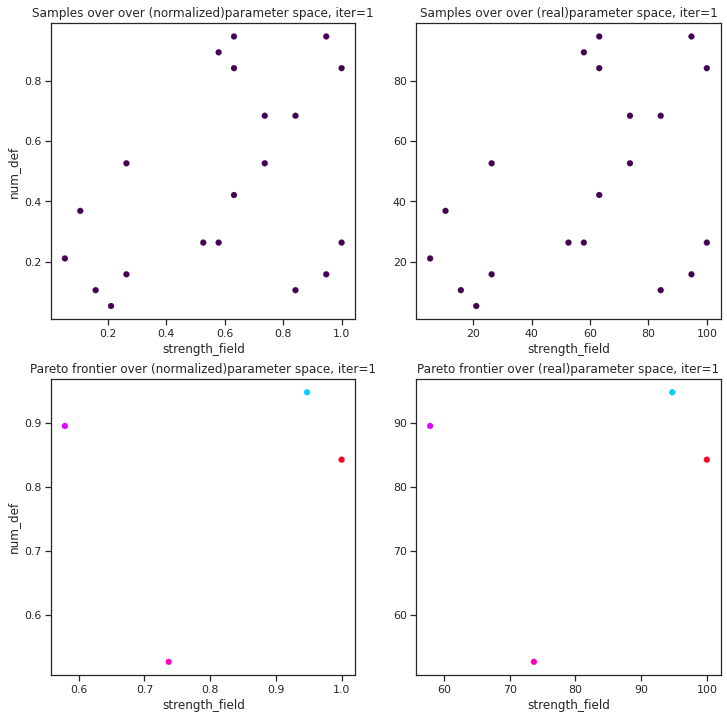

Batch Function eval #21
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #22
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #23
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #24
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #25
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #26
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #27
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #28
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #29
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


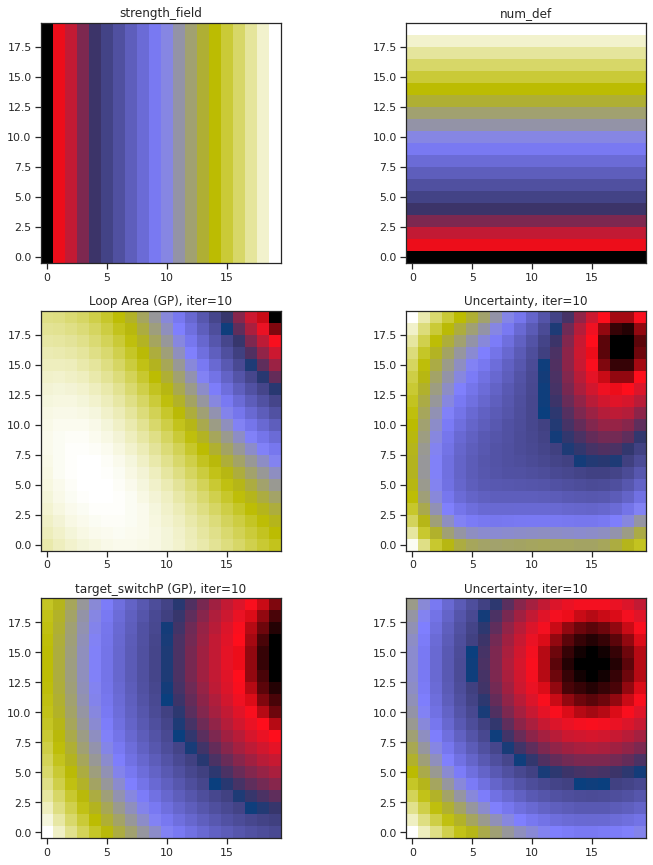

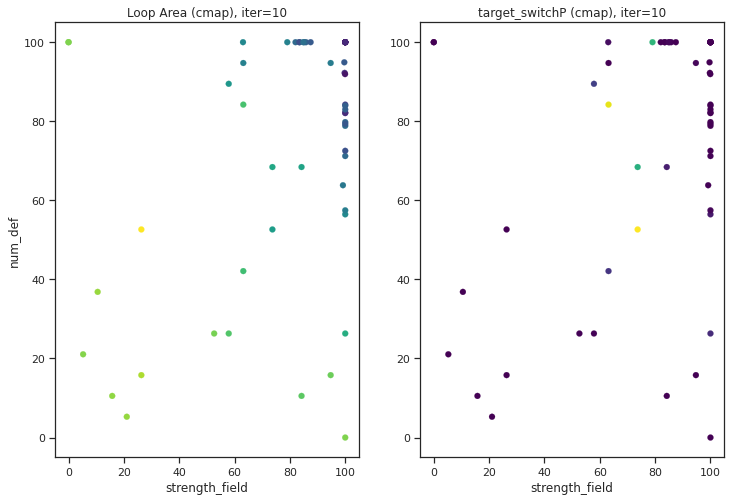

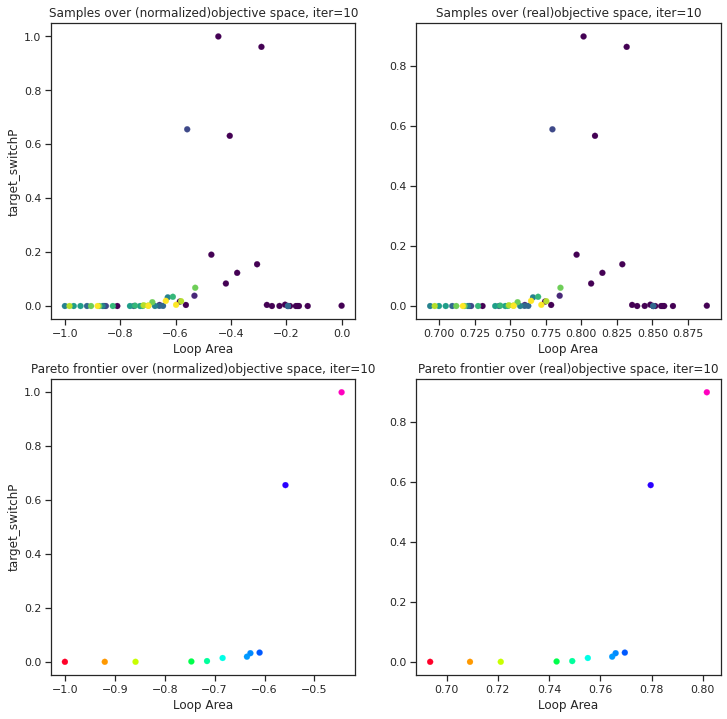

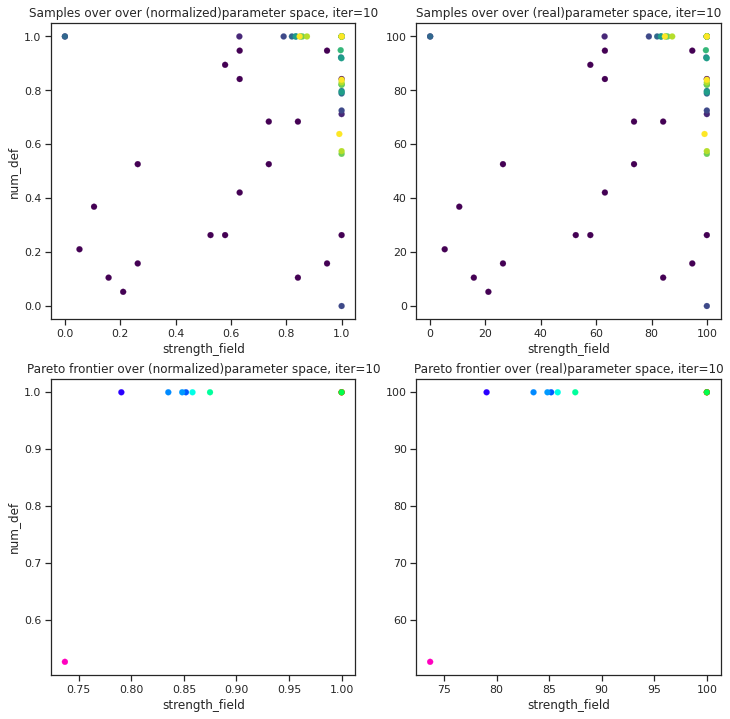

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #30
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #31
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #32
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #33
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #34
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #35
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #36
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #37
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #38
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #39
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


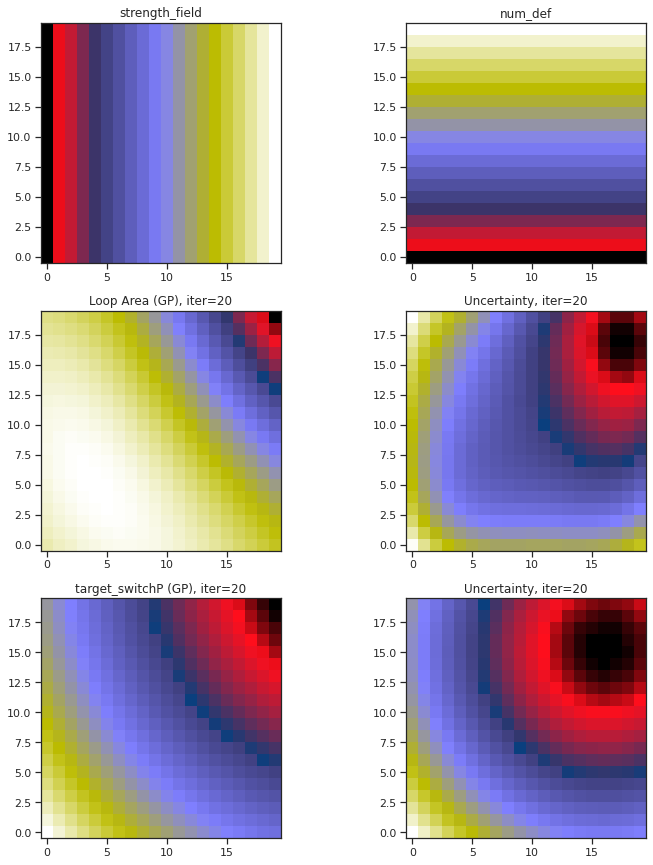

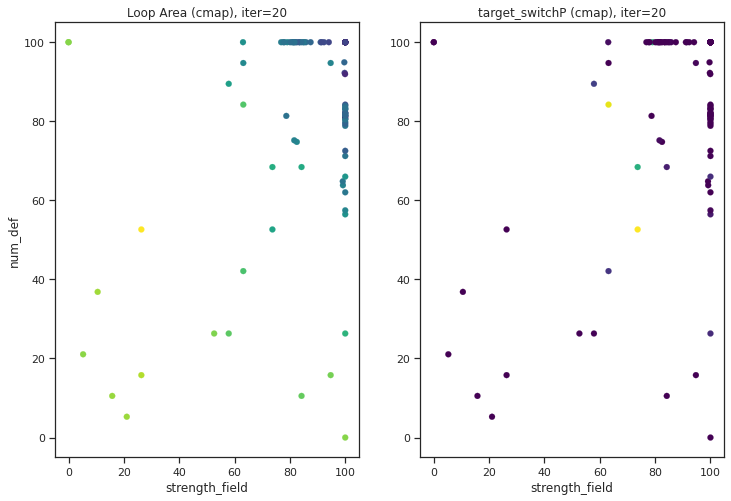

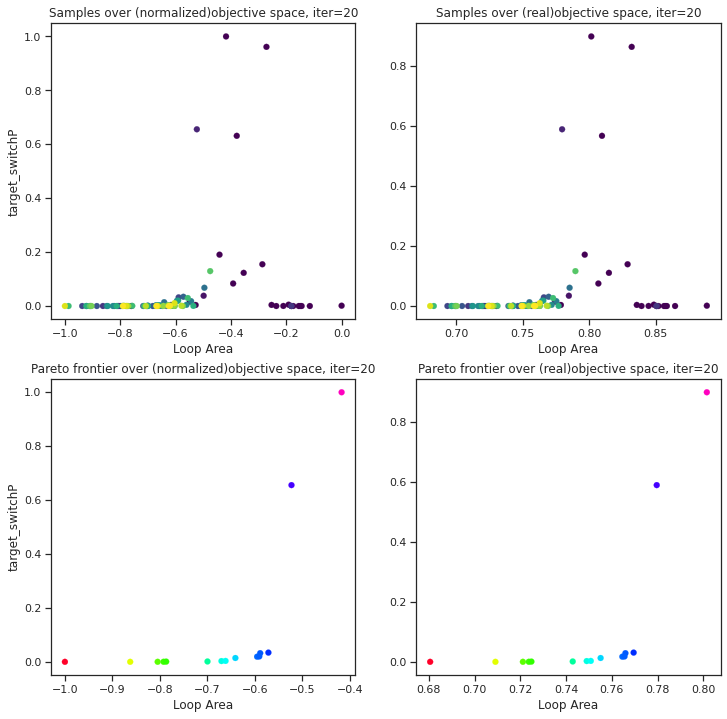

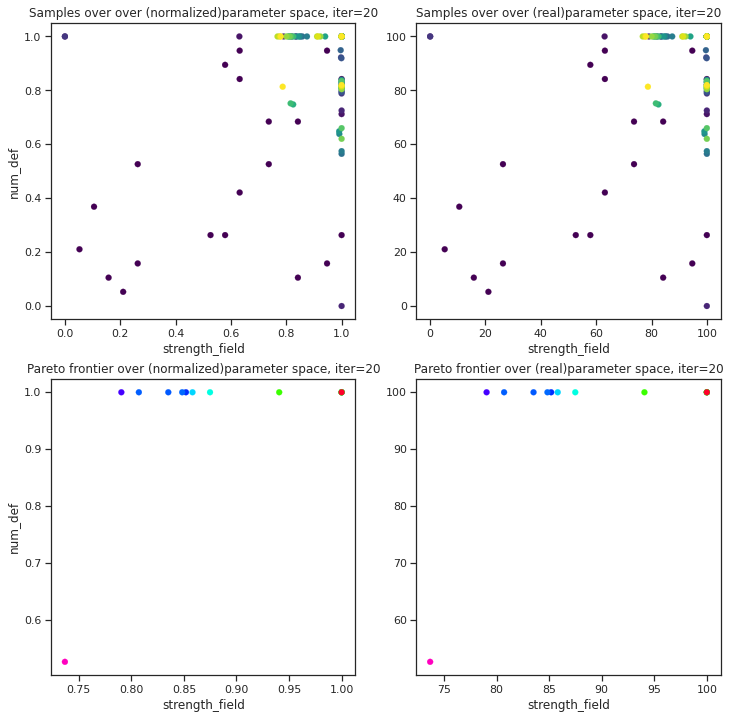

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #40
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #41
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #42
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #43
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #44
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #45
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #46
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #47
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #48
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #49
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


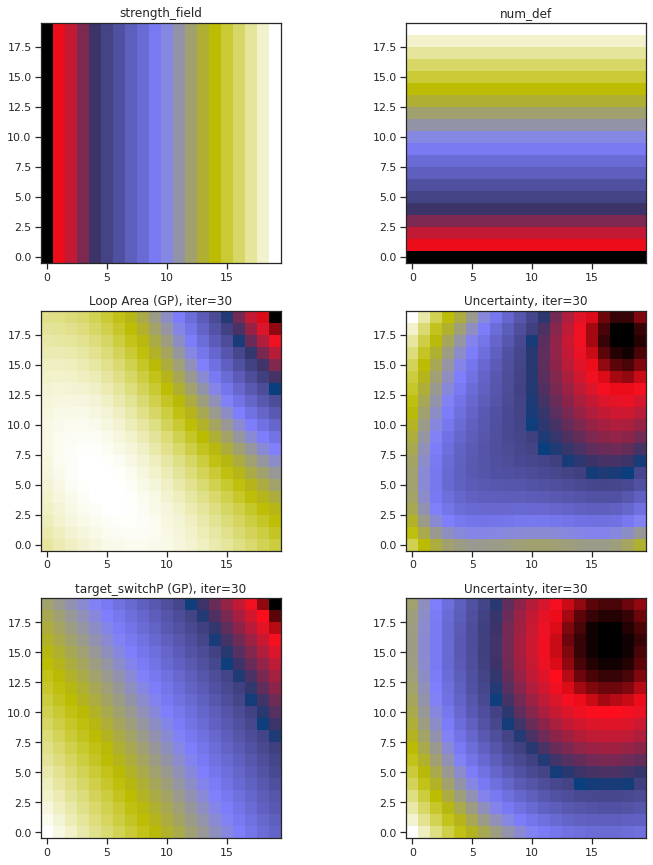

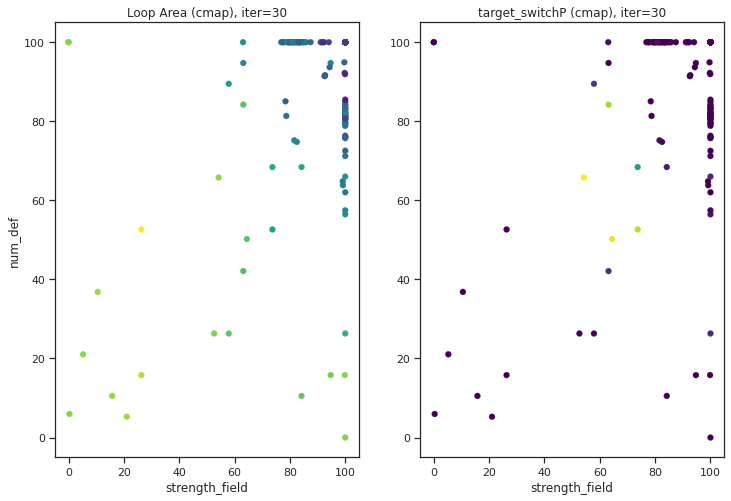

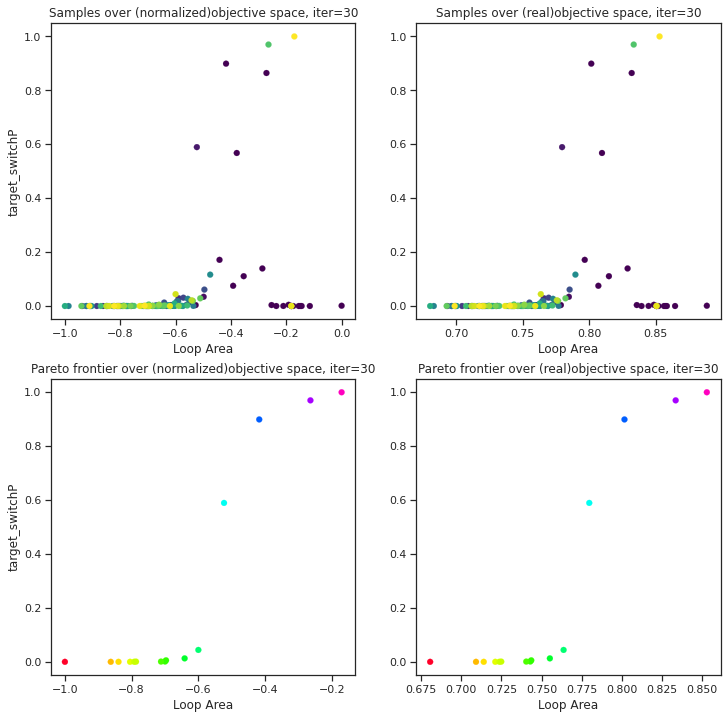

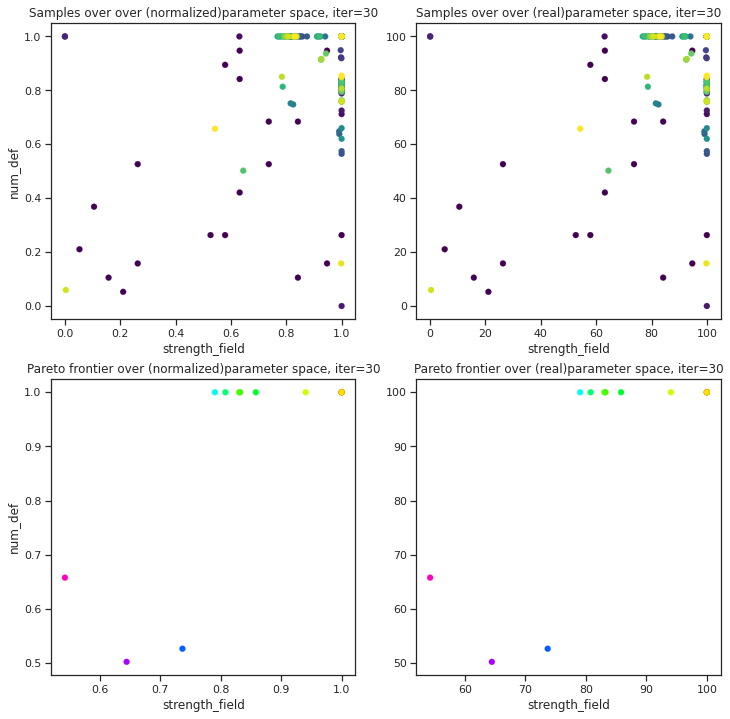

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #50
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #51
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #52
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #53
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #54
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #55
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval:

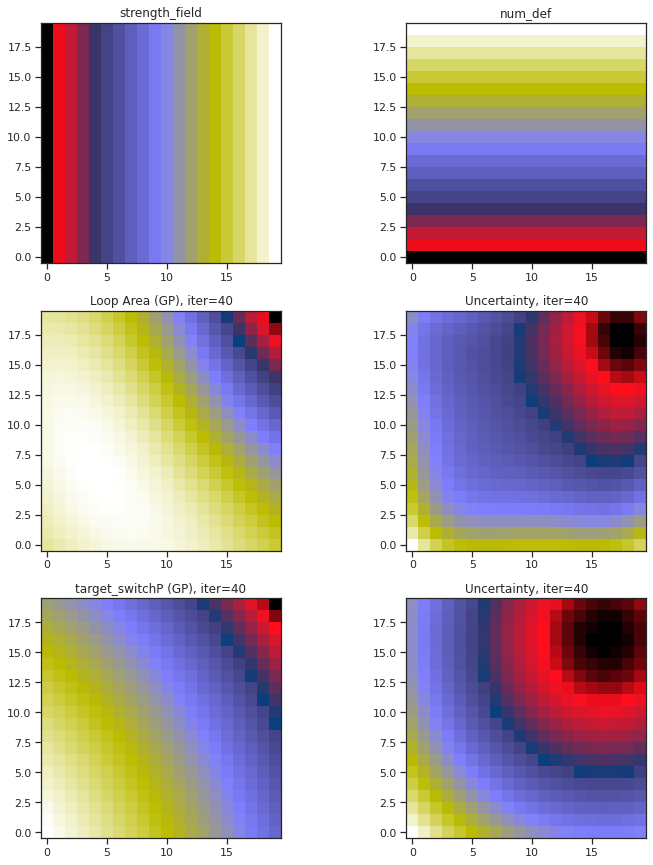

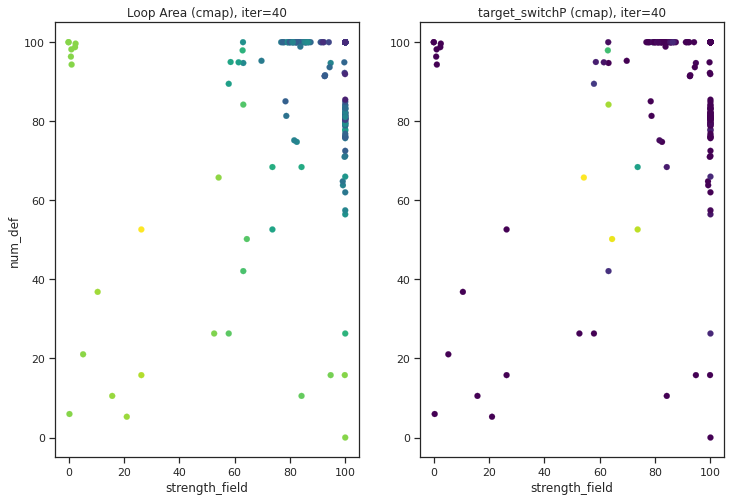

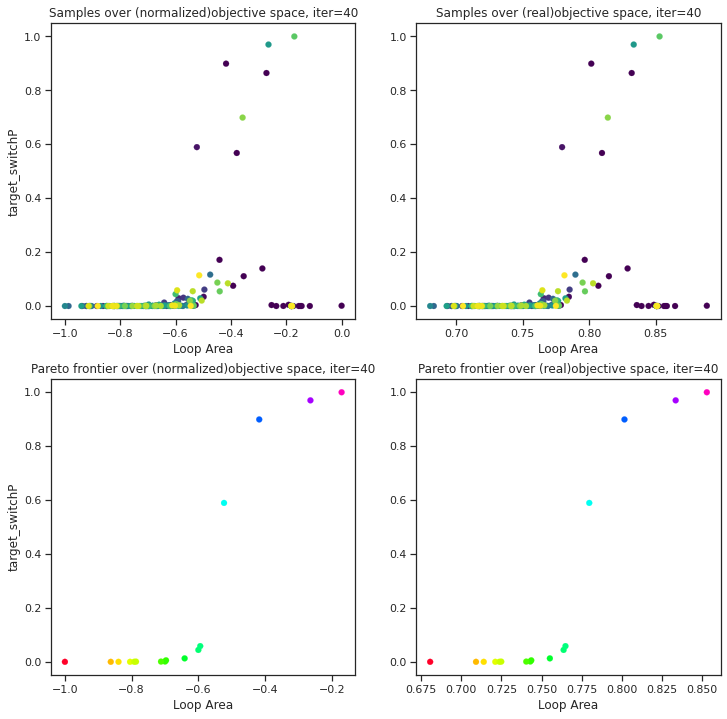

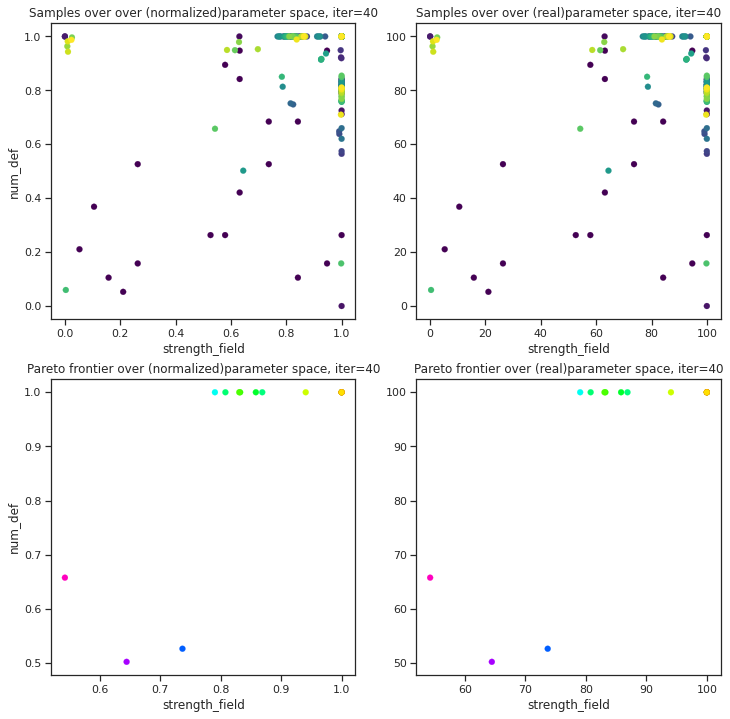

/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #60
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #61
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #62
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #63
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #64
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #65
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #66
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #67
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4


/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)
/usr/local/lib/python3.7/dist-packages/gpytorch/utils/cholesky.py:44: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


Batch Function eval #68
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #69
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Batch Function eval #70
Within batch: Function eval: 1 of 4
Within batch: Function eval: 2 of 4
Within batch: Function eval: 3 of 4
Within batch: Function eval: 4 of 4
Max. sampling reached, model stopped


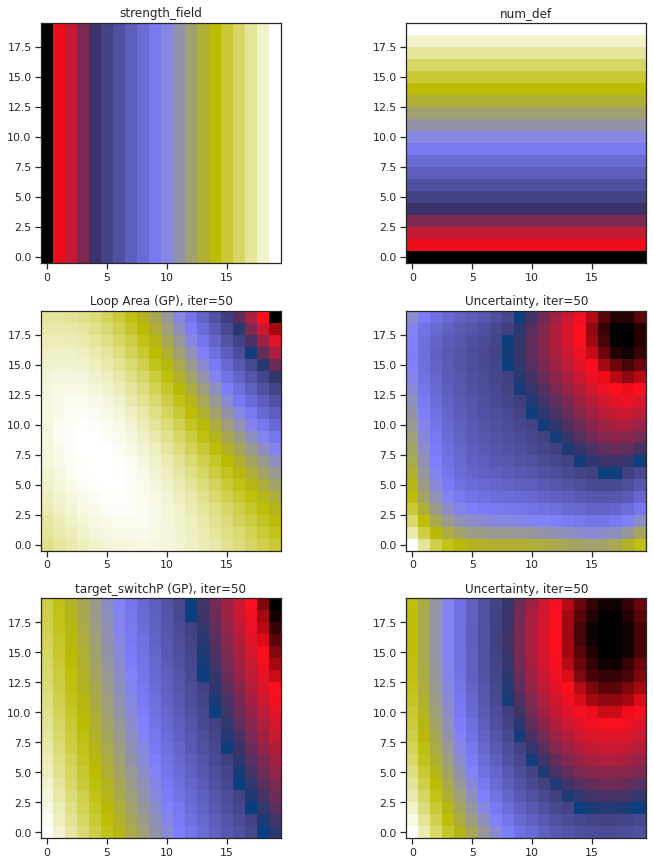

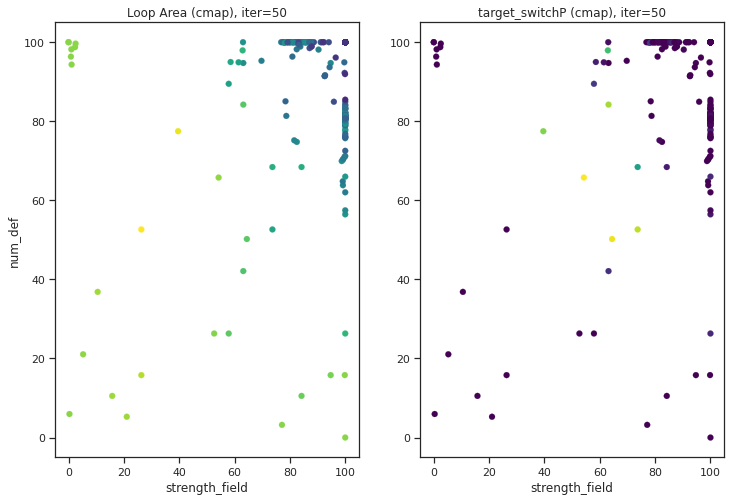

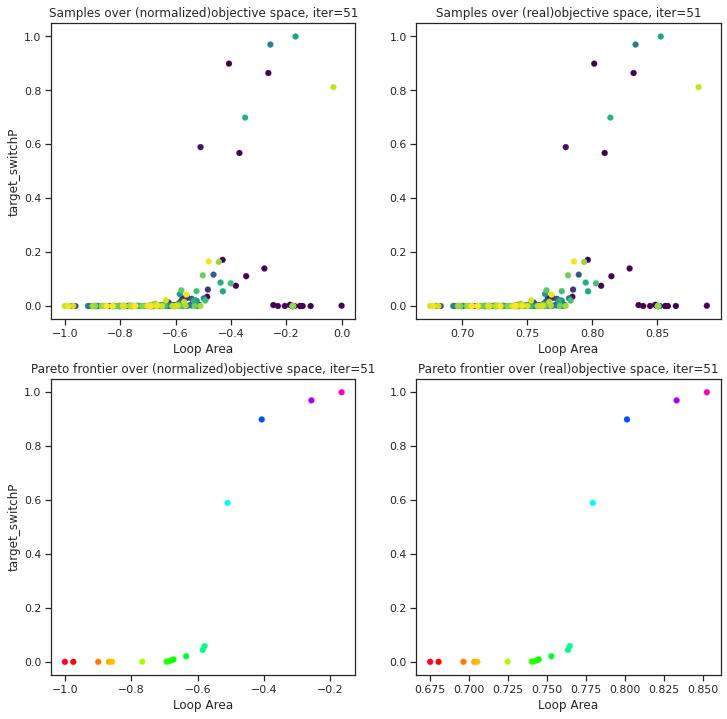

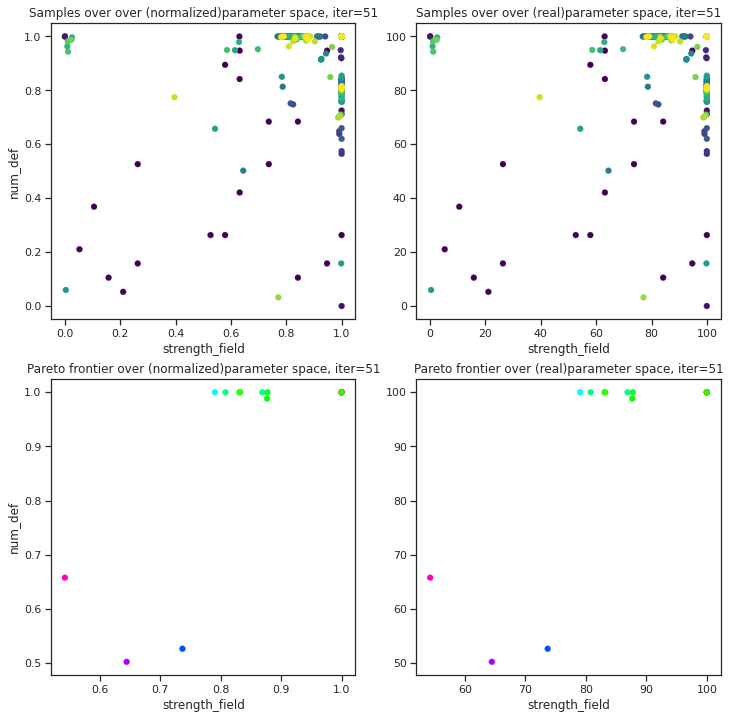

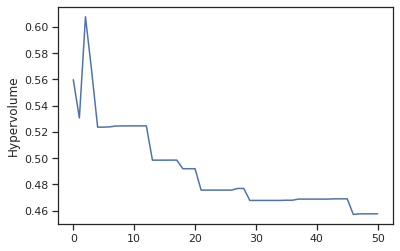

tensor(0.0065, dtype=torch.float64)
tensor(0.0074, dtype=torch.float64)
Run NSGA 2 for test function-- Without MOBO
n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |      11 |       2 |            - |            -
    2 |      22 |       5 |  0.196651934 |        ideal
    3 |      33 |       8 |  0.058701042 |            f
    4 |      44 |      11 |  0.104872646 |        ideal
    5 |      55 |      11 |  0.020150028 |        ideal
    6 |      66 |      11 |  0.010461790 |        ideal
    7 |      77 |      11 |  0.089185305 |        ideal
    8 |      88 |      11 |  0.015492657 |            f
    9 |      99 |      11 |  0.037692319 |            f
   10 |     110 |      11 |  0.010600083 |            f
   11 |     121 |      11 |  0.183275281 |        ideal
   12 |     132 |      11 |  0.004242419 |            f
   13 |     143 |      11 |  0.008333255 |            f
   14 |     154 |      11 |  0.127649102 |        nadir
   15 |     165 |      11 |  0.010048163 |  

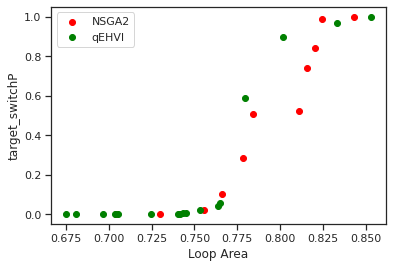

In [11]:
####################### Run BO ##############################

tkwargs = {
    "dtype": to.double,
    "device": to.device("cuda" if to.cuda.is_available() else "cpu"),
}
BATCH_SIZE = 4 #For each iteration in BO, how many future samples we select in batch

# List of options
# 'qEHVI'- Expected Hypervolume acquistion function
# 'qParego' -qParEGO
acquisition = 'qEHVI'

#List of control params- Temp, rho, h, deltaG
# Choose any two control params to create the parameter space considering the same order-
param1 = 'strength_field'
param2 = 'num_def'
# Choose any two objectives to do MOO (MOBO)-
# Choose objective 2 either 'switch_P'- swichable polarization or 'target_switchP' - setting a target value for switchable P which the user want to achieve.
obj1 = 'Loop Area'
obj2 = 'target_switchP'

# Input choice of problem- where it is minimization or maximization for objective 1 and 2 respectively
# List of options
# 'min'- Minimization
# 'max' -Maximization (default setting)
problem =['min','max']

#Define parameter space based on above choice of params (2D only)
num_rows =20
num = 20  # Starting samples
#N = (0.1 * num_rows ** 2) - num  # Maximum evaluations
#N = int(N)
N=50

num_def = np.linspace(0, 100, num_rows)
test_num_def = np.linspace(0, 100, num_rows)
strength_field = np.linspace(0, 100, num_rows)
test_strength_field = np.linspace(0, 100, num_rows)

X1 = strength_field
test_X1 = test_strength_field
X2 = num_def
test_X2 = test_num_def



MOBO_ferroSim(X1, X2, test_X1, test_X2, num_rows, N, BATCH_SIZE, param1, param2, obj1, obj2, acquisition, problem)


<h1> Make Movies from results

In [13]:
from google.colab import drive

#drive.mount('/content/gdrive', force_remount=True)
#root_path1 = 'gdrive/My Drive/MOBO/6HC-IAC_qParEGO/Movies1/' 
#root_path2 = 'gdrive/My Drive/MOBO/6HC-IAC_qParEGO/Movies2/' 
#root_path3 = 'gdrive/My Drive/MOBO/6HC-IAC_qParEGO/Movies3/' 

#aoi.utils.animation_from_png(png_dir=str(root_path1), moviename="GP_6HC-IAC_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path2), moviename="ParetoObj_6HC-IAC_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path3), moviename="ParetoX_6HC-IAC_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)

In [14]:
#drive.mount('/content/gdrive', force_remount=True)
#root_path1 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies1/' 
#root_path2 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies2/' 
#root_path3 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies3/' 
#root_path4 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies4/' 
#root_path5 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies5/' 
#root_path6 = 'gdrive/My Drive/MOBO/FerroSim/LAvsSwitchP/Movies6/' 

#aoi.utils.animation_from_png(png_dir=str(root_path1), moviename="GP_Ferro_SwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path2), moviename="ParetoObj_Ferro_SwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path3), moviename="ParetoX_Ferro_SwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path4), moviename="GP_Ferro_SwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path5), moviename="ParetoObj_Ferro_SwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path6), moviename="ParetoX_Ferro_SwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)

Mounted at /content/gdrive


In [15]:
#drive.mount('/content/gdrive', force_remount=True)
#root_path1 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies1/' 
#root_path2 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies2/' 
#root_path3 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies3/' 
#root_path4 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies4/' 
#root_path5 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies5/' 
#root_path6 = 'gdrive/My Drive/MOBO/FerroSim/LAvsTargetSwitchP/Movies6/' 

#aoi.utils.animation_from_png(png_dir=str(root_path1), moviename="GP_Ferro_TargetSwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path2), moviename="ParetoObj_Ferro_TargetSwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path3), moviename="ParetoX_Ferro_TargetSwtichP_qParEGO", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path4), moviename="GP_Ferro_TargetSwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path5), moviename="ParetoObj_Ferro_TargetSwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)
#aoi.utils.animation_from_png(png_dir=str(root_path6), moviename="ParetoX_Ferro_TargetSwtichP_qEIHV", savedir="/content/gdrive/My Drive/MOBO/", remove_dir=False)

Mounted at /content/gdrive
